# Brock Mirman (1972) model

## Description

This is the textbook neoclassical growth model with a known (linear solution). Consider an agent maximizing her inter-temporal discounted utility
\begin{equation}
\begin{split}
\max_{\{c_t\}_{t=0}^{\infty}} E\Big[ \sum_{t=0}^{\infty} \beta^t u(c_t)\Big]
\end{split}
\end{equation}
with $y_0$ given. She enters period $t$ with income $y_t$ and chooses her consumption level $c_t$ subject to the constraints $0\leq c_t \leq y_t$. What is saved in the current period is used for production to generate income next period.

Income next period is stochastic and takes the following form: $y_{t+1} = g(y_t - c_t)\eta_{t+1}$ with $\eta$ denoting i.i.d. productivity shocks.

Let us assume that preferences can be represented by a logarithmic utility function $u(c)=\log(c)$, the production function is Cobb-Douglas $g(k) = k^\alpha$, the discount factor is positive but strictly less than one, $\beta \in (0,1)$, and that productivity shocks are lognormally distributed $\eta_{t} \equiv \eta(\nu_t) = \exp(\mu + \nu_t)$, with $\nu$ a standard normal random variable.

Solving the model involves finding the value of the parameter vector $\theta$ such that the consumption function $c(y|\theta)$ satisfies the Euler equation characterizing the model:

\begin{equation}\label{eq:Euler_sgm}
E_{\nu}\Big[ \beta \frac{c_t}{c_{t+1}} \alpha k_t^{\alpha -1}\exp(\nu_{t+1})  \Big] = 1
\end{equation}

Greater tractability is achieved by working with a transformed version of the left-hand side of the previous equation:
\begin{equation}\label{eq:Euler_sgm_transformed}
E_{\nu}\Big[ \exp \Big( \log \big( \beta \frac{c_t}{c_{t+1}} \alpha k_t^{\alpha -1}\exp(\nu_{t+1}) \big) \Big) \Big] \approx E_{\nu}\Big[ 1 + \log \big( \alpha \beta ) + \tilde{c}_t - \tilde{c}_{t+1} +(\alpha -1) \tilde{k}_t + \nu_{t+1} \Big]
\end{equation}

where the tilde notation is used to refer to the logarithm of the variable, for instance $\tilde{c_t} = \log(c_t)$, and making use of the approximation $\exp(x) \approx 1 + x$ for $x$ small. Hence, the Euler equation can be rewritten as
\begin{equation}\label{eq:Euler_sgm_transformed_2}
E_{\nu}\Big[\log \big( \alpha \beta ) + \tilde{c}_t - \tilde{c}_{t+1} +(\alpha -1) \tilde{k}_t +\nu_{t+1} \Big] = 0
\end{equation}

where $\tilde{y}_{t+1} = \alpha \tilde{k}_t + \nu_{t+1}$ and $\tilde{c}_{t+1} = \log\big(c(y_{t+1}| \theta) \big)$.

It is easy to verify that the optimal behavior for the agent is to consume a fixed fraction of her cash on hand $y$. More specifically, the optimal consumption policy function is given by $c^{*}(y_t) = (1 - \alpha \beta) y_t$, or equivalently $\tilde{c}^{*}(y_t) = (1 - \alpha \beta) + \tilde{y}$.

## The bc-MC Operator

Assuming the solution is not known beforehand, we are approximating the decision function with an artificial neural network (ANN) $c(y) \approx c(y|\theta)$. The loss function for the ANN is:

$$\mathcal{L}(\theta) =  E_{s}\Big( E_{s}\Big( f(s, \varepsilon) \Big)^2 \Big) $$

Let's approximate the loss function with the bc-MC operator:

$$\mathcal{L}_{M,N}(\theta) = \frac{2}{MN(N-1)} \sum_{m=1}^{M} \sum_{1\leq i < j}^{n} f(s_m, \epsilon_{m}^{(i)})f(s_m, \epsilon_{m}^{(j)}) $$

where $\epsilon^{(k)}$ for $k=1, 2, ..., N$ are $N$ i.i.d shocks with the same distribution as $\epsilon$. These $N$ shocks are independent from each other.


## 0. Dependencies

Load packages and define some options and parameters.

In [1]:
on_Colab = True
# Install deps on Colab
if on_Colab == True:
    !pip install quantecon interpolation chaospy torchcontrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 5.2 MB/s eta 0:00:00
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7517 sha256=ff59df6f2ca5cd3e06b2b278c3291796fccd803b994d50441e377da5932b6907
  Stored in directory: /root/.cache/pip/wheels/4e/e6/4d/ca9241b0fd2036630ed1674493738e27be708978362dac7cf4
Successfully built torchcontrib
  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import quantecon as qe
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit, float64
from numba.experimental import jitclass

import random
import scipy.stats
import chaospy  ## for quadrature (expectations)
from itertools import product
import os

import tensorflow as tf
import time
from math import sqrt
import seaborn as sns; sns.set()
from tqdm import tqdm as tqdm # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass
from scipy.stats import norm

import torch
from torch import nn
from torch.utils.data import DataLoader
# To create copies of NN
import copy
# To use sparse kronecker product
from scipy import sparse
from torchcontrib.optim import SWA
from torch.nn.utils import clip_grad_norm_

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.special import erfinv, erf

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
cpuinfo.get_cpu_info()

{'python_version': '3.10.12.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 2,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Xeon(R) CPU @ 2.20GHz',
 'hz_advertised_friendly': '2.2000 GHz',
 'hz_actual_friendly': '2.2000 GHz',
 'hz_advertised': [2200000000, 0],
 'hz_actual': [2199998000, 0],
 'model': 79,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'adx',
  'aes',
  'apic',
  'arat',
  'arch_capabilities',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'clflush',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cx16',
  'cx8',
  'de',
  'erms',
  'f16c',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hypervisor',
  'ibpb',
  'ibrs',
  'invpcid',
  'invpcid_single',
  'lahf_lm',
  'lm',
  'mca',
  'mce',
  'md_clear',
  'mmx',
  'movbe',
  'msr',
  'mtrr',
  'nonstop_tsc',
  'nopl',
  'nx',
  'osxsave',
  'pae',
  'pat',
  'pcid',
  'pclmulqdq',
  'pdpe1gb

In [4]:
# Display version of python currently used
!python3 --version

Python 3.10.12


In [5]:
# Display which version of packages I am using
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.17.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.2
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chaospy==4.3.13
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.7
cufflinks==0.17.3
cupy-cuda12x==12.2.0
cvxopt==1.3.2
cvxpy==1.3.2


In [6]:
seed_number = 1234 #1234
random.seed(seed_number) # For replicability reasons
print(random.random())
torch.manual_seed(seed_number)

0.9664535356921388


In [7]:
# Plotting options
plot_scale = 1.25
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
# Controlling fontsizes
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE =  SMALL_SIZE + 4
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE

# Option when reading and saving output csv.file
read_from_csv = True #read from disk
save_to_csv = True #save to disk
run_analysis = True #start the analysis (can be very long)
linewidth_chosen = 2

In [8]:
current_wd = os.getcwd()
output_extension = "BM_3"
output_folder = current_wd  + f"/output/{output_extension}/"
# Create folder if does not exist:
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)

if on_Colab == True:
  # Mount gdrive
  from google.colab import drive
  drive.mount('/gdrive')

  # Small test
  with open('/gdrive/My Drive/foo.txt', 'w') as f:
    f.write('Hello Google Drive!')
  !cat '/gdrive/My Drive/foo.txt'

  # Create directory
  path = f"/gdrive/My Drive/{output_extension}"
  # Create folder if does not exist:
  if not os.path.exists(path):
    # If it doesn't exist, create it
    os.mkdir(path)

# Import functions from notebook
if on_Colab == False:
    %run functions_BM.ipynb
else:
    # Where functions are stored
    %run "/gdrive/My Drive/Colab Notebooks/functions_BM.ipynb"

Mounted at /gdrive
Hello Google Drive!

In [9]:
# Store parameters
class MyParams():
    def __init__(self, N, M, lr, pre_train_model, nb_epochs, order_gauss, σ_e, use_Sobol, optimizer,
                α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen):
        # Safety checks:
        if α_chosen > 1:
            raise Exception(f"α = {α_chosen} bigger than 1")
        if β_chosen > 1:
            raise Exception(f"β = {β_chosen} bigger than 1")
        # distribution shocks
        ## "Lognormal": legacy from WP version. contains a typo
        ## "Lognormal_2": lognormal (log(e_t) then is normal)
        ## "Beta": beta distribion
        ## "Trunc_Lognormal": lognormal, but truncated:
        ## "Normal": normal distribution
        self.list_e_distribution_allowed = ["Lognormal_2", "Beta", "Trunc_Lognormal", "Lognormal", "Normal"]
        # disribution state
        ## "Lognormal_2": lognormal (log(y_t) then is normal). Use ergodic distribution of log(y_t)
        ## "Lognormal_3": lognormal (log(y_t) then is normal). Std. dev different from true ergodic distribution.
        ## "Uniform": y_t from Uniform
        ## "Normal": y_t from normal
        ## "Uniform_centered": y_t from uniform, centered around ss for y_t
        self.x_distribution_allowed = ["Lognormal_2", "Lognormal_3", "Uniform", "Normal", "Uniform_centered"]
        if e_distribution_chosen not in  self.list_e_distribution_allowed:
            raise Exception(f"e_distribution_chosen: {e_distribution_chosen} not allowed")
        if x_distribution_chosen not in   self.x_distribution_allowed:
            raise Exception(f"x_distribution_chosen: {x_distribution_chosen} not allowed")
        # OptimalGrowthModel
        self.α = α_chosen #0.4 #0.4 #0.9 #0.4 #0.4
        self.β = β_chosen #0.99 #0.96 #0.96 #0.96#
        self.f = lambda k: k**self.α
        self.u = lambda c: np.log(c)
        self.f_prime = lambda k: self.α * (k**(self.α - 1))
        self.u_prime=  lambda c: 1/c
        self.u_prime_inv =  lambda c: 1/c
        # True function
        self.true_cst = (1 - self.α * self.β) #true constant param
        ## True bias and true weight make sense when the network is just sigmoid(nn.Sequential(nn.Linear(1, 1)))
        self.true_bias = (torch.logit(torch.tensor([self.true_cst]))).detach().numpy() #true bias of the ANN
        self.true_weight = 0.0 #true weight of the ANN
        true_function = lambda x: self.true_cst * x #True solution
        self.true_function = true_function
        # Non-stochastic SS
        self.y_ss = (self.α*self.β)**(self.α/(1 - self.α))
        self.k_ss = (self.α*self.β)**(1/(1 - self.α))
        self.c_ss = self.true_function(self.y_ss)
        # Standard shocks
        #σ_e = σ_e # for large shocks, it is better to use MC, for small shock: all-in-one
        #μ_e = 0.0 #location parameter shocks
        # Values passed as inputs
        self.N = N #number of draws inside expectation
        self.M = M #number of draws outside expecation
        self.MN = int(self.M*self.N)
        # To keep constant the number of function evaluations
        self.T = int(self.MN/2) #number of draws all in on expectation
        self.σ_e = σ_e
        self.μ_e = 0.0
        self.e_distribution = e_distribution_chosen #"Lognormal_2" #"Lognormal_2" #"Beta" #"Trunc_Lognormal" #"Lognormal_2" #"Normal"
        # When working with truncated distributions
        self.trunc_low = -4 #0.5 #-1 #-2
        self.trunc_high = 2 #0.5 #1 #2
        # Simulate true model
        self.df_series, self.series_names, self.list_mean, self.list_std, self.list_CI_lower, self.list_CI_upper = sim_true_model(self.α, self.β, self.f, self.e_distribution, self.μ_e, self.σ_e, self.trunc_low, self.trunc_high, 10000)
        # Standard error X (if drawing from Normal)
        self.σ_x = 1.0
        self.x_distribution = x_distribution_chosen #"Lognormal_2" #"Lognormal_2" #"Uniform" #"Normal" #Uniform or Normal or "Lognormal_2"
        # Draw from model
        x_low = self.list_CI_lower[self.series_names.index('y')] #params.list_CI_lower[params.series_names.index('y')] #0.5 ##0.1 #1
        x_high = self.list_CI_upper[self.series_names.index('y')] #params.list_CI_upper[params.series_names.index('y')] #1.5 ##4.0 #3
        # When y_t is lognormal. Ergodic distribution at true value
        self.mm = self.α/(1 - self.α)*np.log(self.α*self.β) # mean log(y_t)
        self.ss = np.sqrt((self.σ_e**2)/(1 - self.α**2)) # std log(y_t)
        # When using Lognormal_3 for state
        ## when alpha=0.36 and beta = 0.96
        ##Kappa N*=100: 0.0019935763981368095
        ##Kappa N*=3: 0.019735399459103867
        self.ss_Lognormal_3 = 0.0019 #0.1 #0.0019 #0.1 #0.002 # 0.0019
        #p = 0.05
        #val_p_low = np.exp(mm + np.sqrt(2*(ss**2))*erfinv(2*p - 1))
        #p = 0.95
        #val_p_high = np.exp(mm + np.sqrt(2*(ss**2))*erfinv(2*p - 1))
        if self.e_distribution  == "Trunc_Lognormal":
            self.x_low = np.exp(self.mm + self.ss*self.trunc_low) #
            self.x_high = np.exp(self.mm + self.ss*self.trunc_high) #
        elif self.e_distribution  == "Beta":
            self.x_low = np.exp(self.mm + 0/(1 - self.α)) #
            self.x_high = np.exp(self.mm + 1/(1 - self.α))  #
        elif self.x_distribution  == "Uniform_centered": #Uniform centered at the true mean
            tol_mean = 0.0069/2
            self.x_low = np.exp(self.mm - tol_mean)
            self.x_high = np.exp(self.mm + tol_mean)
        else:
            self.x_low = x_low
            self.x_high =  x_high
        # Vectorized Monte Carlo requires the creation of some objects
        # To repeat vectors
        repeat_vector = torch.ones(N) #to repeat the same value n times using a matrix multiplication
        # To calculate the expectation wrt future shocks using a matrix multiplication
        A = sparse.eye(M)
        B = sparse.csr_matrix(np.ones(N)/N)
        # Sparse kronecker product. Then convert to pytorch sparse
        W = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B))
        self.repeat_vector = repeat_vector
        self.W = W
        # Use for the bc-MC operator
        self.W_expanded = create_W_expanded_matrix(self.M, self.N)
        # Learning parameters
        self.lr = lr #learning rate
        self.momentum = 0.9 #momentum for SGD with momentum
        self.optimizer = optimizer #"Adam" #default: #Adam or SGD or SWA
        self.freq_gamma = 0.95
        self.use_scheduler = False #False #True #default: True
        self.pre_train_model = pre_train_model #default: False (not used)
        self.nb_epochs = nb_epochs
        self.nb_epochs_pre_train = int(self.nb_epochs/1)
        self.freq_scheduler = 500 #int(self.nb_epochs/10)
        # Sobol sampling
        self.soboleng = torch.quasirandom.SobolEngine(dimension=1)
        self.soboleng_M = torch.quasirandom.SobolEngine(dimension=M)
        self.soboleng_T = torch.quasirandom.SobolEngine(dimension=self.T)
        self.use_Sobol = use_Sobol #Sobol for dimension M
        self.use_Sobol_T = use_Sobol #Sobol for all-in-one
        # GAUSSIAN QUADRATURE
        # self.distrib = chaospy.J(chaospy.Normal(μ_e, σ_e))
        self.distrib = chaospy.LogNormal(self.μ_e, self.σ_e)
        self.order_gauss = order_gauss
        nodes, weights = dist(self.order_gauss, self.distrib, rule = "gaussian", sp=False)
        self.nodes = nodes
        self.weights = weights
        self.weights_torch = torch.tensor(weights)
        self.nodes_torch = torch.tensor(np.transpose(self.nodes).squeeze(1))
        # Save the number of points for the guassian quadrature:
        self.N_gaussian = len(self.weights_torch)
        # Repeat nodes to match the number of function evaluations for the expectation
        #self.nodes_torch_repeated = self.nodes_torch.repeat(self.M)
        # CREATE A W MATRIX FOR GAUSSIAN QUADRATURE:
        #B_gaussian = sparse.csr_matrix(self.weights_torch)
        # Sparse kronecker product. Then convert to pytorch sparse
        #self.W_gaussian = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B_gaussian))
        # Test points
        self.nb_points_accuracy = 100
        # If uniform
        ## not the ergodic distribution for y
        #self.xvec_test_torch = torch.linspace(self.x_low, self.x_high, self.nb_points_accuracy).unsqueeze(1) #add a dimension
        # If drawing from true ergodic distribution for y
        ## y is lognormal
        self.xvec_test = np.random.lognormal(self.mm, self.ss, size=self.nb_points_accuracy)
        self.f_true = np.expand_dims(self.true_function(self.xvec_test),1) # true value of c(y_t)
        self.xvec_test_torch = torch.tensor(self.xvec_test).unsqueeze(1).float()
        self.n_nodes = len(self.weights_torch)
        # CREATE A W MATRIX FOR GAUSSIAN QUADRATURE:
        self.A_gaussian = sparse.eye(self.nb_points_accuracy)
        self.B_gaussian = sparse.csr_matrix(self.weights_torch)
        # Sparse kronecker product. Then convert to pytorch sparse
        self.W_gaussian = sparse_mx_to_torch_sparse_tensor(sparse.kron(self.A_gaussian, self.B_gaussian))
        self.swa_start = 1000
        self.swa_freq= 10
        # Check bad combinations
        if (self.optimizer == "SWA") & (self.use_scheduler == True):
            raise('opt SWA and use_schedule = True')

In [10]:
M_chosen = 100 #1 #100 # Outer expectation
N_chosen = 2 #200 #2 # Inner expectation
lr_chosen = 1e-2 #3 #3 #1e-2 #1e-1 ## learning rate
pre_train_model_chosen = False
nb_epochs_chosen = 10000 #2000 #10000
order_gauss = 5
# RESUSCITATING REAL BUSINESS CYCLES
# https://www.nber.org/system/files/working_papers/w7534/w7534.pdf
# Quarterly: rho = 0.979, sdtdev 0.0072
# Yearly: rho_y = rho^4. stddev sqrt(rho^6 + rho^4 + rho^2 + 1)*sdtdev \approx sqrt(4)*stdev because rho approx 1
# Gives: stdev log(a): 0.03519247176117002
σ_e_chosen = 0.05 #0.03519247176117002 #0.1 #0.5 #1.5 #.5 #1.5 #1.5 #1.5 #1.5 #1.5 #2 #0.5 #np.sqrt(0.25) #np.sqrt(1.5) #1.5 #std deviation of shocks
use_Sobol_chosen = False #use Sobol sampling in the state space
optimizer_chosen = "Adam" #"SGD" #"Adam" #"SGD"
initial_guess = [2.0, 2.0] #initial guess for the model

α_chosen = 0.36 #0.96 #0.36 #0.4
β_chosen = 0.96 #0.96
# 1. Default
## Draw y_tilde from true ergodic
#e_distribution_chosen = "Lognormal_2"
#x_distribution_chosen = "Lognormal_2"
# 2. Illustrative
## Draw y_tilde from lognormal with std dev. different from ergodic
e_distribution_chosen = "Lognormal_2"
x_distribution_chosen = "Lognormal_2" #"Lognormal_3"

params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen,
                  nb_epochs_chosen, order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                  α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)

print("nb epochs: {}".format(params.nb_epochs))
print("W.shape: {}".format(params.W.shape))
print("W_expanded.shape: {}".format(params.W_expanded.shape))
print("M: {}".format(params.M))
print("N: {}".format(params.N))
print("MN: {}".format(params.MN))
print("T: {}".format(params.T))
print("use_Sobol: {}".format(params.use_Sobol))
print("Number nodes Gaussian Q: {}".format(params.nodes.shape))
print("N Gaussian: {}".format(params.N_gaussian))
print("lr: {}".format(params.lr))
print("σ_e: {}".format(params.σ_e))
print("optimizer: {}".format(params.optimizer))
print("Initial guess: {}".format(initial_guess))
print("y_ss: {}".format(params.y_ss))
print("k_ss: {}".format(params.k_ss))
print("c_ss: {}".format(params.c_ss))
print(f"weights torch: {params.weights_torch}")
print(f"nodes torch: {params.nodes_torch}")
print(f"{params.x_low}")
print(f"{params.x_high}")

# Calculate variance of loss
# Used below
# params, nb_epoch_opt_M_N, nb_rep, nb_draws_loss, list_M, list_N
nb_iter_model = 200 # nb iterations before calculating the variance
nb_rep_model = 20 #number of repetitions of the process: iter model -> calculate variance of loss
nb_draws_var = 500 #number of independent draws to calculate the variance

# Grid M and grid N
T = (params.M*params.N)/2
#grid_N = np.concatenate((np.ones(1), np.array([N for N in range(2, 200+2, 2)])))
#grid_N = np.array([N for N in range(2, 2*params.T+2, 2)])
# Non-evenly spaced grid
grid_N = np.array([N for N in range(2, params.T+2, 2)])
# Same as:
# grid_N = np.arange(2, params.T+2, 2)
grid_M = 2*T/grid_N

is_int = grid_M % 1 == 0
grid_N = grid_N[is_int]
grid_M = grid_M[is_int]

print(grid_N)
print(grid_M)
print(grid_N*grid_M)

theory_N_opt = 2 + (1 - params.α**2)*(params.α*params.β/(1 - params.α**2 * params.β))**2
# When drawing from ergodic distribution for y_tilde
print(f"Theory optimal N: {theory_N_opt}")
# When drawing from Lognormal 3
## to get N = 100
kappa_2 = ((params.σ_e**2)*(params.α*params.β/(1 - params.α**2 * params.β))**2)*(1/(T-2))
print(f"Kappa N*=100: {np.sqrt(kappa_2)}")
## to get N = 3
std_bis = params.σ_e*(params.α*params.β/(1 - params.α**2 * params.β))
print(f"Kappa N*=3: {std_bis}")

# Pre-calculate params associated with grid choices
list_params = []
for (ind, (N_loop, M_loop)) in enumerate(zip(grid_N.astype('int'), grid_M.astype('int'))):
    params_local = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen,
                  nb_epochs_chosen, order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                  α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)
    list_params.append(params_local)


<ipython-input-8-fc08cf596fc9>:8: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


nb epochs: 10000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.01
σ_e: 0.05
optimizer: Adam
Initial guess: [2.0, 2.0]
y_ss: 0.550107701699446
k_ss: 0.1901172217073285
c_ss: 0.35999047999211753
weights torch: tensor([0.0061, 0.1431, 0.4669, 0.3325, 0.0505, 0.0010], dtype=torch.float64)
nodes torch: tensor([0.8584, 0.9223, 0.9830, 1.0456, 1.1144, 1.1974], dtype=torch.float64)
0.49369382655092314
0.6129980724081364
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]
Theory optimal N: 2.135603442908708
Kappa N*=100: 0.0019935763981368095
Kappa N*=3: 0.019735399459103867


## 0. True model

CI for y: 0.49425936602606557 - 0.6125280968296151
mean for y: 0.5510170459747314
std for y: 0.029562853276729584
max for y: 0.6964155435562134
min for y: 0.42370882630348206
CI for c: 0.32344342497319695 - 0.4008384993725048
mean for c: 0.3605860471725464
std for c: 0.01934652216732502
max for c: 0.4557343125343323
min for c: 0.27727505564689636
CI for k: 0.17081607967212795 - 0.21168976011846252
mean for k: 0.19043175876140594
std for k: 0.010217234492301941
max for k: 0.2406812161207199
min for k: 0.1464337706565857
CI for e: 0.9049082758551588 - 1.105387733203417
mean for e: 1.001388430595398
std for e: 0.050109006464481354
max for e: 1.225136637687683
min for e: 0.8106393814086914


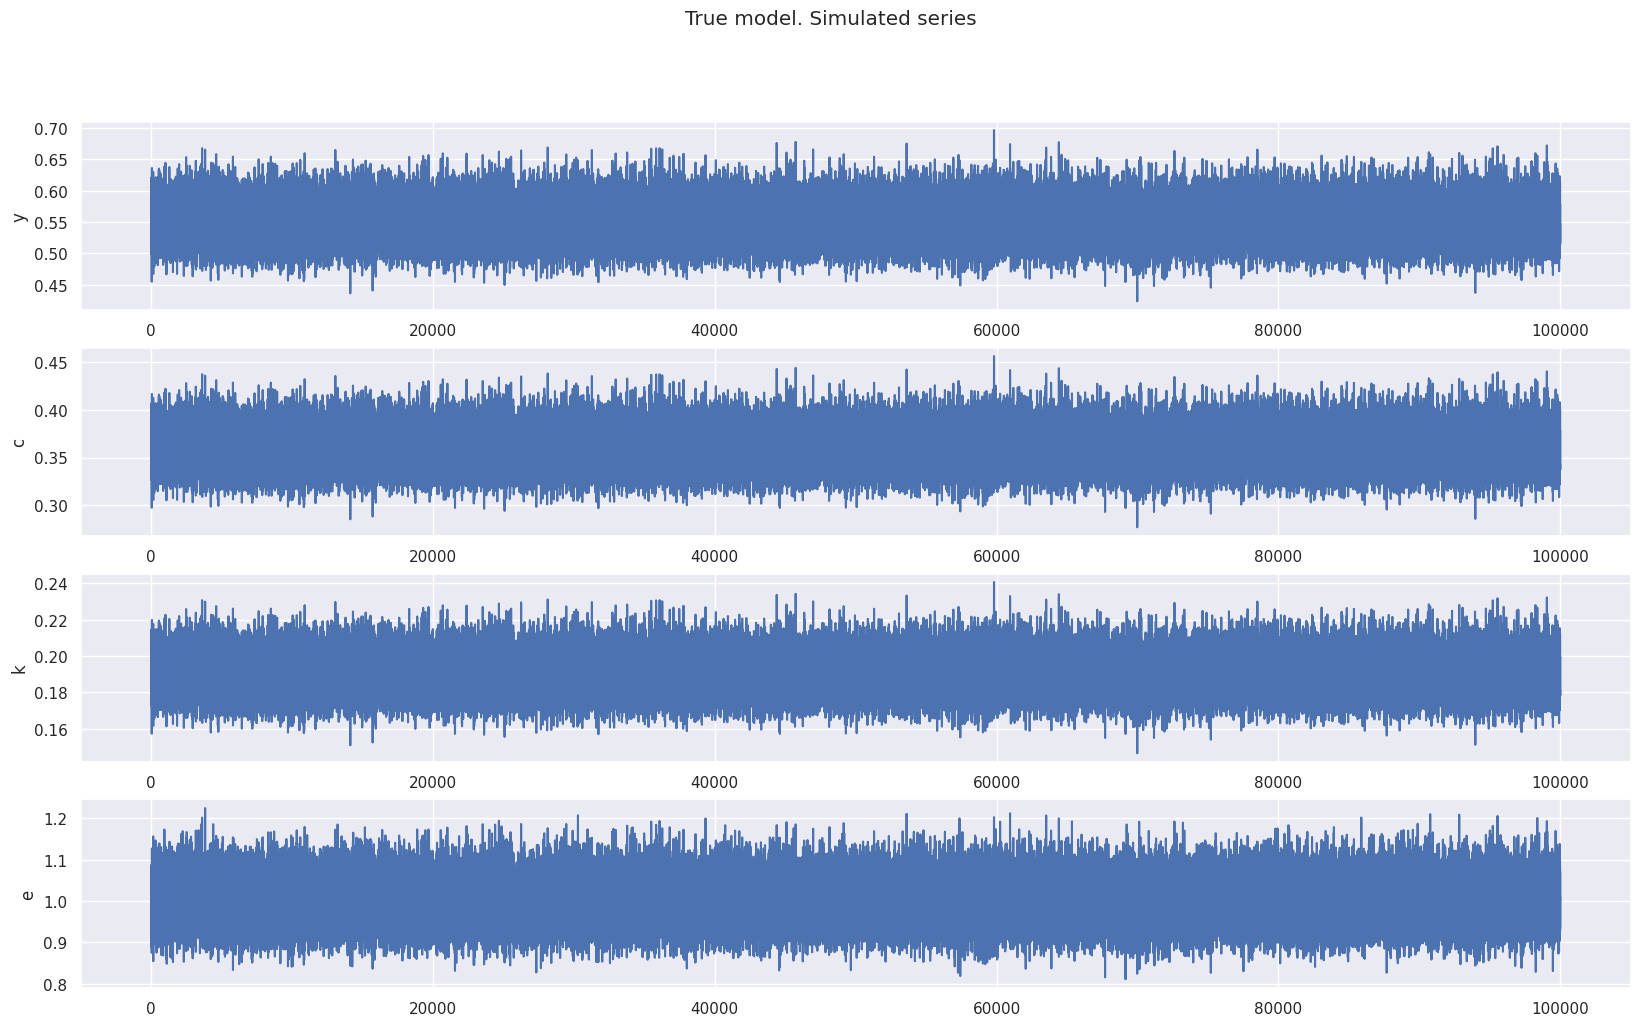

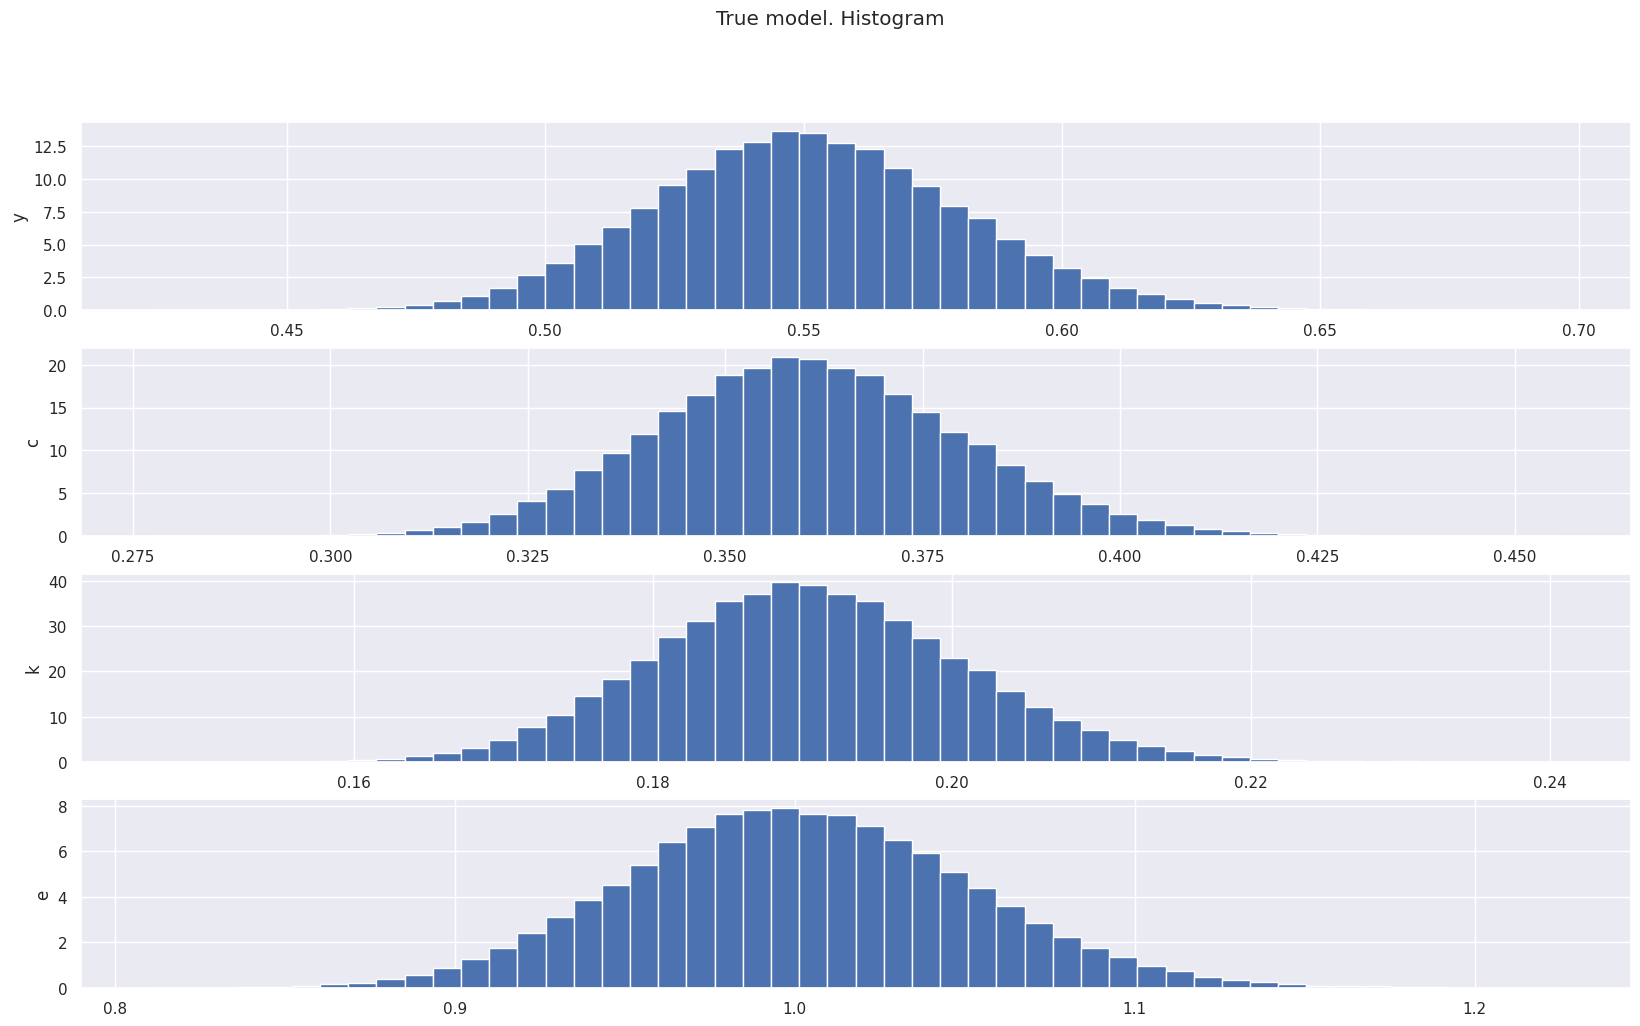

In [11]:
df_series, series_names, list_mean, list_std, list_CI_lower, list_CI_upper = simulate_true_model(params, 100000)

fig, axs = plt.subplots(4)
fig.suptitle('True model. Simulated series')

for (var, mean_val, std_val, CI_lower, CI_upper, ax) in zip(series_names, list_mean, list_std, list_CI_lower, list_CI_upper, axs.flat):
    ax.plot(df_series[var], label="y")
    ax.set_ylabel(var)
    print(f"CI for {var}: {CI_lower} - {CI_upper}")
    print(f"mean for {var}: {np.mean(df_series[var][100:])}")
    print(f"std for {var}: {np.std(df_series[var][100:])}")
    print(f"max for {var}: {np.max(df_series[var][100:])}")
    print(f"min for {var}: {np.min(df_series[var][100:])}")

fig, axs = plt.subplots(4)
fig.suptitle('True model. Histogram')
for (var, ax) in zip(series_names, axs.flat):
    ax.hist(df_series[var], bins=50, density=True)
    ax.set_ylabel(var)

In [12]:
2 + (params.σ_e**2/(0.1**2))*(params.α*params.β/(1 - params.α**2 * params.β))**2

2.03894859918104

In [13]:
2 + (params.σ_e**2/(0.0019**2))*(params.α*params.β/(1 - params.α**2 * params.β))**2

109.89085645717374

## I. Test the formula

Test the formula from proposition 4

In [14]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetworkBias(nn.Module):
    # Network with only one parameter
    # bias = (1- alpha*beta) when true model
    def __init__(self, params):
        super(NeuralNetworkBias, self).__init__()
        self.bias = torch.nn.Parameter(torch.tensor([0.5]), requires_grad=True)

    def forward(self, x, bound=torch.tensor([1e-6])):
        ζ0 = self.bias
        ζ1 = torch.minimum(torch.maximum(ζ0, bound), 1 - bound)
        # Multiply by the input to get consumption
        ζ2 = ζ1*x
        return ζ2

class NeuralNetwork(nn.Module):
    # OLS. y = a + bx
    def __init__(self, params):
        super(NeuralNetwork, self).__init__()
        self.nb_nodes = 8 #16
        self.x_low = params.x_low
        self.x_high = params.x_high
        self.denominator = self.x_high - self.x_low
        self.act_f = nn.ReLU()  #nn.ReLU() #nn.LeakyReLU() #nn.Tanh() # #nn.LeakyReLU() #nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(nn.Linear(1, 1))
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, self.nb_nodes),
            self.act_f,
            nn.Linear(self.nb_nodes, self.nb_nodes),
            self.act_f,
            nn.Linear(self.nb_nodes, 1)
        )


    def forward(self, x, bound=torch.tensor([1e-8])):
        ## normalize input to (0,1)
        #x_normalized = (x - self.x_low)/self.denominator
        ## normalize input to (-1,1)
        #x_normalized = 2*(x - self.x_low)/self.denominator - 1
        ## if normalize in (0,1) using sigmoid
        #x_normalized = torch.sigmoid(x)
        ## normalize using log
        x_normalized = torch.log(x)
        out = self.linear_relu_stack(x_normalized)
        # ζ0 is consumption share
        ζ0 = torch.sigmoid(out)#sigmoid output: between 0 and 1
        #ζ0 = 0.5*(torch.tanh(out) + 1)# between 0 and 1
        # Get rid of corner solutions 0% and 100%:
        ζ1 = torch.minimum(torch.maximum(ζ0, bound), 1 - bound)
        # Multiply by the input to get consumption
        ζ2 = ζ1*x
        return ζ2

class NeuralNetworkLog(nn.Module):
    # OLS. y = sigmoid(a + b log(x))
    def __init__(self, params):
        super(NeuralNetworkLog, self).__init__()
        self.nb_nodes = 1
        self.bias = torch.nn.Parameter(torch.tensor([1e-2]), requires_grad=True)
        self.linear = nn.Sequential(nn.Linear(1, 1))
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.nb_nodes, 1)
        )

    def forward(self, x, bound=torch.tensor([1e-8])):
        ζ0 = 1 - params.α*params.β + self.bias*torch.log(x)
        ζ1 = torch.minimum(torch.maximum(ζ0, bound), 1 - bound)
        ζ2 = ζ1*x
        return ζ2

# Model bc-MC
model_bcMC = NeuralNetwork(params).to(device)
model_MC_untrained = copy.deepcopy(model_bcMC)
print(model_bcMC)

# Initial params
for name, param in model_bcMC.named_parameters():
    print(f"{name}: {param}")

Using cpu device
NeuralNetwork(
  (act_f): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
linear.0.weight: Parameter containing:
tensor([[-0.8641]], requires_grad=True)
linear.0.bias: Parameter containing:
tensor([0.3738], requires_grad=True)
linear_relu_stack.0.weight: Parameter containing:
tensor([[ 0.7964],
        [ 0.4376],
        [-0.5371],
        [-0.0312],
        [-0.3280],
        [ 0.6341],
        [-0.9855],
        [-0.5378]], requires_grad=True)
linear_relu_stack.0.bias: Parameter containing:
tensor([ 0.0058,  0.4072,  0.9052, -0.4104,  0.0938,  0.7015, -0.5350, -0.5033],
       requires_grad=True)
linear_relu_stack.2.weight: Parameter c

tensor(0.1009)
torch.Size([1])


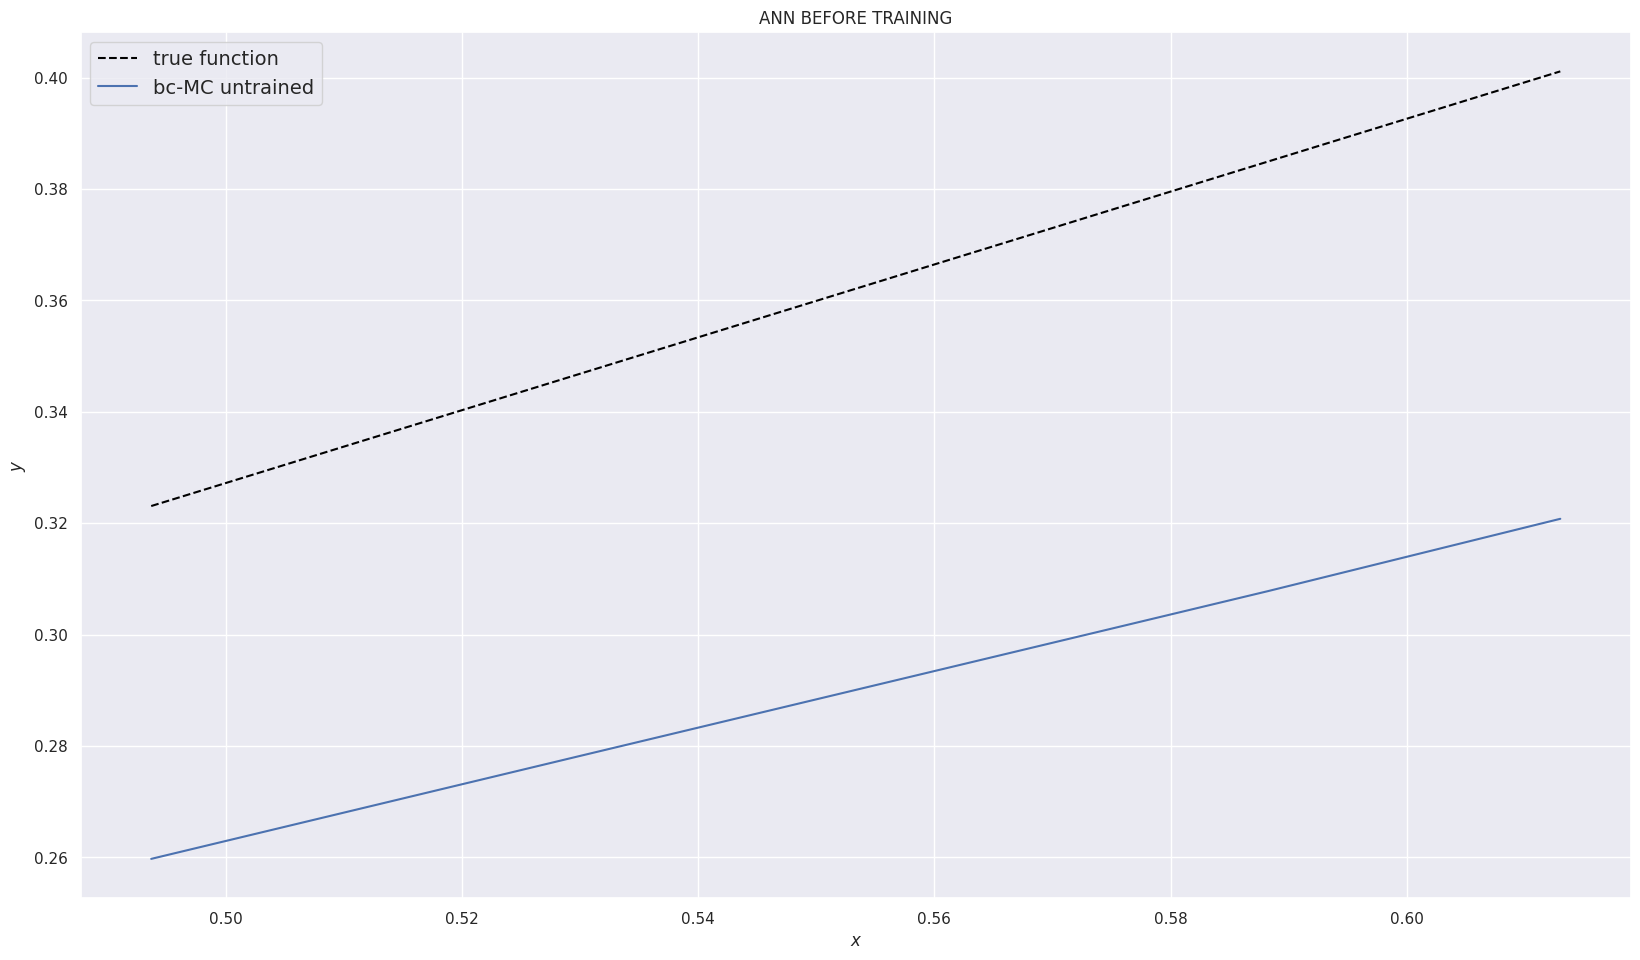

In [15]:
with torch.no_grad():
    v = Ξ_torch(model_bcMC, params)
    print(v)

target = torch.tensor([0])
print(target.shape)

nb_points = 1000 #nb points to evaluate the accuracy of the policy function
model_MC_untrained.eval()

# Define the grid
with torch.no_grad():
    xvec = torch.linspace(params.x_low, params.x_high, nb_points).unsqueeze(1) #add a dimension
    y_MC_untrained = model_MC_untrained(xvec)

xvec = xvec.detach().numpy()
y_MC_untrained = y_MC_untrained.detach().numpy()

plt.plot(xvec, params.true_function(xvec), linestyle='--', color='black', label="true function")
plt.plot(xvec, y_MC_untrained, label='bc-MC untrained')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("ANN BEFORE TRAINING")
plt.legend()

### I.A. Evaluate variance of loss brute force

In [16]:
from timeit import default_timer as timer

In [17]:
nb_draws_loss = 1000
start = timer()
var_loss_bf = calculate_variance_loss_model_grid(model_bcMC, params, nb_draws_loss, grid_N, grid_M)
end = timer()
elapsed_time_bf = end - start
print(f"Elapsed time: {elapsed_time_bf} sec.")

Elapsed time: 10.862327288000017 sec.


### I.B. Evaluate variance of loss using formula from proposition appendix

In [18]:
nb_draws = 10000

start = timer()
var_loss_formula = calculate_variance_loss_fast(params, model_bcMC, nb_draws, grid_M, grid_N).detach()
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

Elapsed time: 0.017277515999978732 sec.
Speedup: 628.6972784752963 X


In [19]:
start = timer()
# formula that combines the four shocks more
var_loss_formula_2 = calculate_variance_loss_fast_2(params, model_bcMC, nb_draws, grid_M, grid_N).detach()
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

Elapsed time: 0.013993846000005306 sec.
Speedup: 776.221725463886 X


### I.C. Evaluate variance of loss using gaussian assumption

In [20]:
nb_draws = 10000
nb_draws_M = 10
nb_draws_N = int(nb_draws/nb_draws_M )

start = timer()
var_loss_formula_gaussian, var_f, cov_f = calculate_variance_gaussian(params, model_bcMC, nb_draws, grid_M, grid_N)
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

Elapsed time: 0.006994233000000349 sec.
Speedup: 1553.0405246721798 X


N* brute force: 2


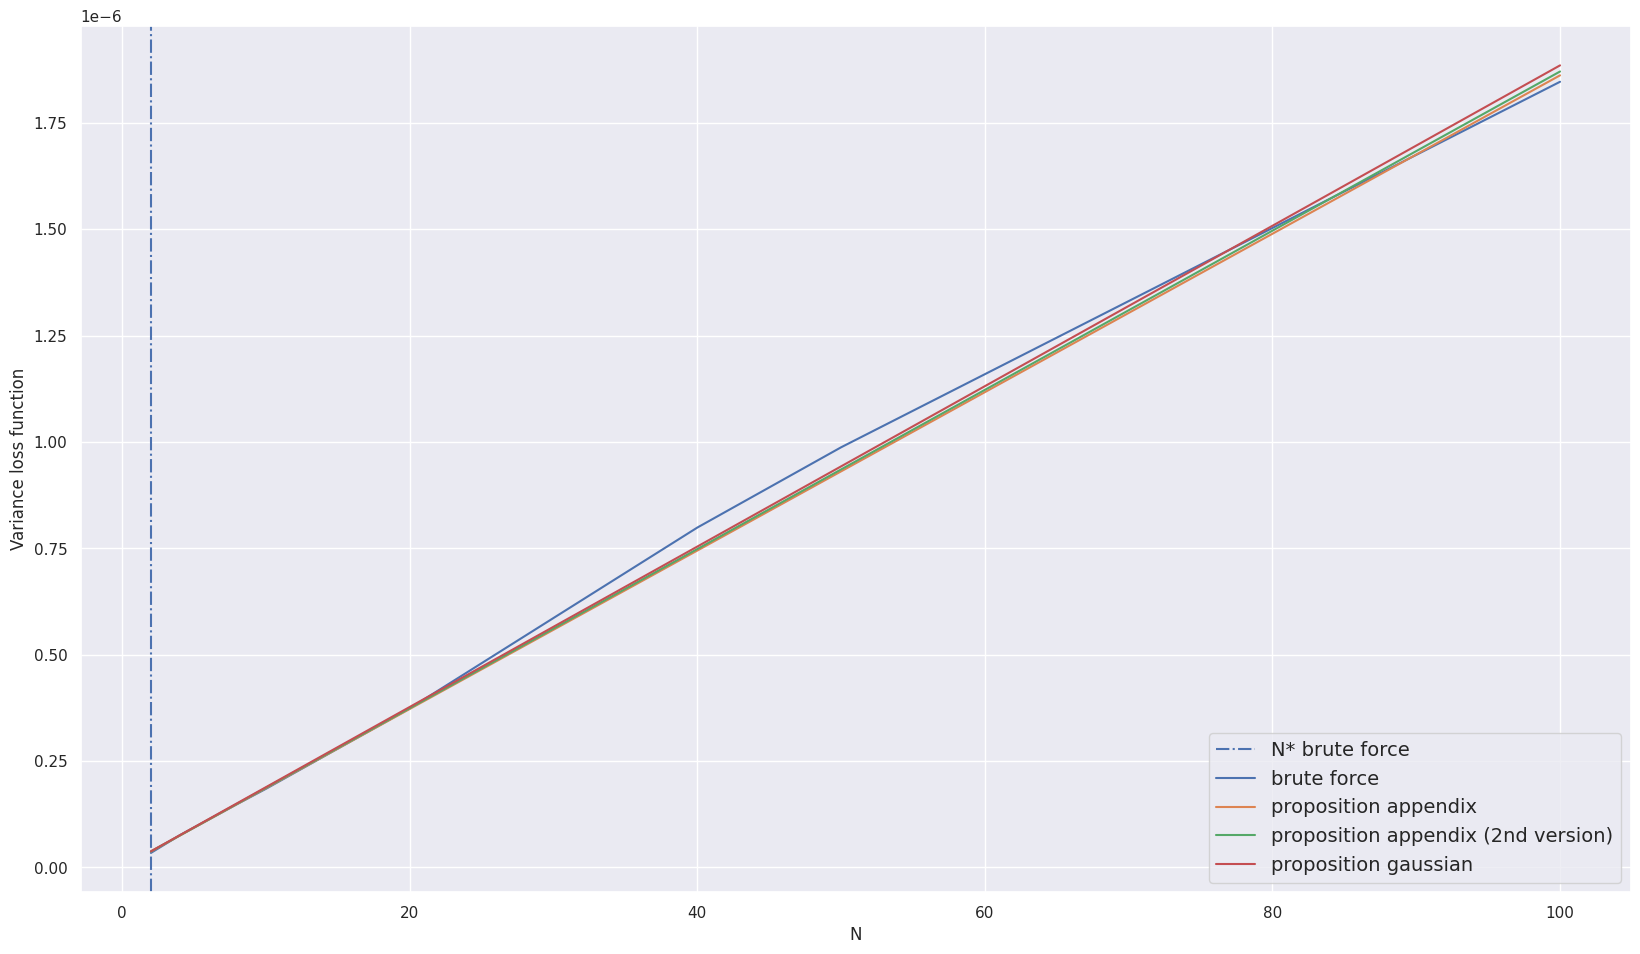

In [21]:
arg_min_g = np.argmin(var_loss_bf)
plt.axvline(x = grid_N[arg_min_g], label = "N* brute force", linestyle="-.")

plt.plot(grid_N, var_loss_bf, label="brute force")
plt.plot(grid_N, var_loss_formula, label="proposition appendix")
plt.plot(grid_N, var_loss_formula_2, label="proposition appendix (2nd version)")
plt.plot(grid_N, var_loss_formula_gaussian, label="proposition gaussian")
plt.xlabel("N")
plt.ylabel("Variance loss function")
plt.legend()

print(f"N* brute force: {grid_N[arg_min_g]}")

tensor(-1.6874e-06)

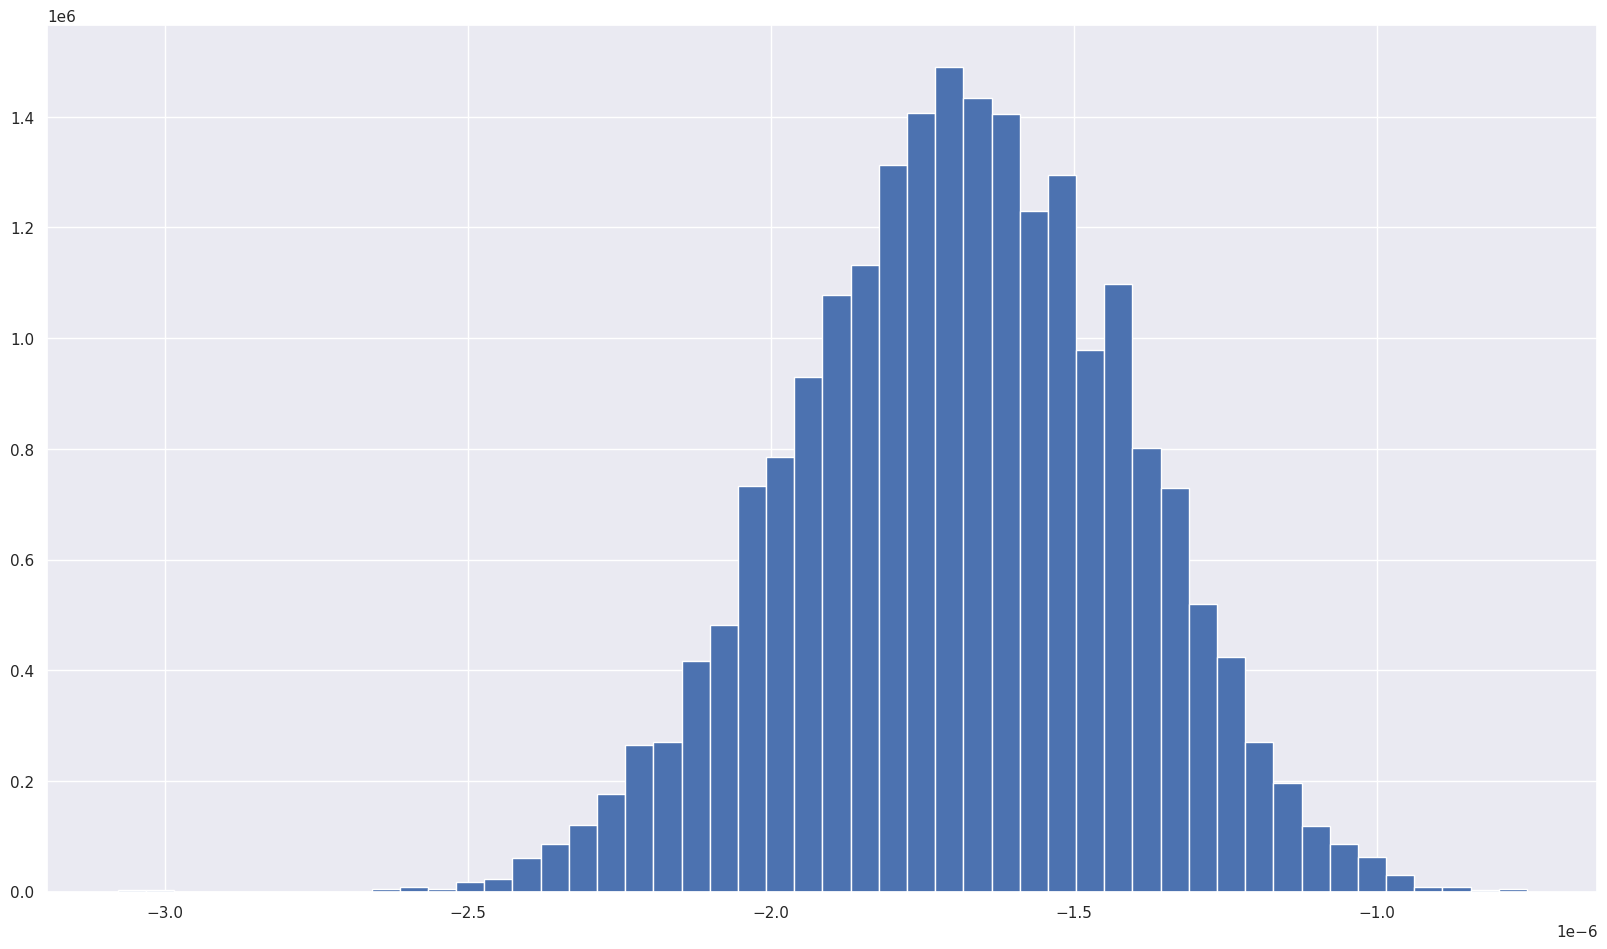

In [23]:
nb_draws=10000
gamma_chosen = 1e-6 #introducing small deviation from true solution
R = Residuals_torch_linear(model_bcMC, params, sim_states_linear(params, nb_draws, gamma_chosen), simulate_shocks(params, nb_draws), gamma_chosen)
plt.hist(R.detach().numpy(), bins=50, density=True)
torch.mean(R)

## II. Calculate variance of the loss across iterations

Do a **single training** loop.

In [24]:
nb_points = 1000 #nb points to evaluate the accuracy of the policy function
nb_draws = 1000 #nb draws when calculating variance of loss
nb_draws_M = 10 #nb draws when calculating variance of loss
nb_draws_N = int(nb_draws/nb_draws_M ) #nb draws when calculating variance of loss

random.seed(seed_number)
model_MC = copy.deepcopy(model_bcMC)
model_MC.train()

optimizer = create_optimizer(model_MC, params.optimizer, params.lr, params.momentum)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
loss_epochs_MC = torch.zeros(params.nb_epochs)
list_perc_abs_error_MC = [] #store abs value percentage error
list_perc_abs_error_MC_mean = []
list_perc_abs_error_MC_i = [] #store index i
list_perc_abs_error_MC_loss = [] #store loss
list_MC_gradient = [] #store the norm of the gradient
list_time = [] #
list_Euler_mean = []
calculate_variance_grad = False
calculate_variance_loss = True
list_var_loss = [] #store variance of the loss
list_optimal_N = [] #store the optimal N
list_optimal_N_current = [] #store the current optimal N used.
optimal_N = params.N #set initial choice for N
index_best_N = np.where(grid_N == optimal_N)[0][0]
freq_var = 10 #frequency with which the variance of the loss is calculated
freq_loss = 1 #frequency with which the loss is calculated
nb_rep_loss = 1 #nb of times the loss function is evaluated between two gradient descent steps
use_N_star = True #Vary N during training
use_exact_accuracy_metrics = True # If False, use square loss to get the EEE

start = timer()
for i in tqdm(range(0, params.nb_epochs)):
    # Clear gradient
    optimizer.zero_grad()
    # Evaluate loss
    # params associated with the current best N:
    params_local = list_params[index_best_N]
    loss = (1/nb_rep_loss)*Ξ_torch_MC(model_MC, params_local)
    for j in range(1, nb_rep_loss):
        loss += (1/nb_rep_loss)*Ξ_torch_MC(model_MC, params_local)
    loss_epochs_MC[[i]] = float(loss.item())

    # Backpropagation
    loss.backward()
    # Avoid explosive gradients
    clip_grad_norm_(model_MC.parameters(), max_norm=1.0, error_if_nonfinite=False)
    optimizer.step()

    if i % freq_loss == 0: #Monitor the predictive power
        list_perc_abs_error_MC_loss.append(float(loss.item()))# store loss
        list_optimal_N_current.append(optimal_N) #N used
        list_perc_abs_error_MC_i.append(i) #store nb gradient descent steps
        # Alternative measurements of accuracy. Slower when True
        if use_exact_accuracy_metrics == True:
            with torch.no_grad():
                y_MC = model_MC(params.xvec_test_torch)
            y_MC = y_MC.detach().numpy()
            perc_abs_error_MC = np.abs((y_MC -  params.f_true )/ params.f_true )
            list_perc_abs_error_MC.append(np.median(perc_abs_error_MC)) #median
            list_perc_abs_error_MC_mean.append(np.mean(perc_abs_error_MC)) #mean
            list_Euler_mean.append(np.mean(evaluate_accuracy_pytorch_frozen_Gaussian(model_MC, params)))
        else:
            EEE = float(loss.item())**0.5
            list_perc_abs_error_MC.append(-1)
            list_perc_abs_error_MC_mean.append(-1)
            list_Euler_mean.append(EEE)

        if calculate_variance_grad == True:
            total_norm = 0
            # Store the norm of the gradient
            for p in model_MC.parameters():
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            list_MC_gradient.append(total_norm)
    if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
        var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_MC, nb_draws, grid_M, grid_N)
        if use_N_star == False:
            index_best_N_dummy = np.argmin(var_loss_formula)
            optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
            list_optimal_N.append(optimal_N_dummy)
            list_var_loss.append(var_loss_formula[index_best_N])
        # When N* algo is used, update the value of N during training
        else:
            # Gaussian formula
            index_best_N = np.argmin(var_loss_formula)
            # Var/Cov
            #N_star_theory = 1 + np.abs(var_f/cov_f)
            #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
            optimal_N = grid_N[index_best_N]
            list_optimal_N.append(optimal_N)
            list_var_loss.append(var_loss_formula[index_best_N])
    if i % 1000 == 0:
        loss, current = float(loss.item()), i
        print(f"loss: {loss:>7f}, N used: {list_optimal_N_current[-1]}, N*: {list_optimal_N[-1]}, list_Euler_mean: {list_Euler_mean[-1]}, median abs per error {list_perc_abs_error_MC[-1]:>7f}, mean euler error {list_perc_abs_error_MC_mean[-1]:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
    if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
        scheduler.step()
        print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

if params.optimizer == "SWA":
    optimizer.swap_swa_sgd()

end = timer()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time} sec.")



  0%|          | 37/10000 [00:00<00:53, 186.16it/s]

loss: 0.100933, N used: 2, N*: 2, list_Euler_mean: 0.33352765440940857, median abs per error 0.178868, mean euler error 0.178881, [    0/10000]


 10%|█         | 1047/10000 [00:04<00:39, 228.22it/s]

loss: 0.000000, N used: 2, N*: 20, list_Euler_mean: 2.2386311684385873e-05, median abs per error 0.000010, mean euler error 0.000012, [ 1000/10000]


 20%|██        | 2028/10000 [00:10<00:50, 158.66it/s]

loss: 0.000000, N used: 50, N*: 2, list_Euler_mean: 1.059651367540937e-05, median abs per error 0.000005, mean euler error 0.000005, [ 2000/10000]


 30%|███       | 3036/10000 [00:15<00:31, 222.92it/s]

loss: 0.000000, N used: 4, N*: 20, list_Euler_mean: 6.171464974613627e-06, median abs per error 0.000003, mean euler error 0.000003, [ 3000/10000]


 40%|████      | 4035/10000 [00:19<00:26, 224.55it/s]

loss: 0.000000, N used: 2, N*: 2, list_Euler_mean: 9.349584615847562e-06, median abs per error 0.000005, mean euler error 0.000005, [ 4000/10000]


 50%|█████     | 5029/10000 [00:25<00:30, 163.77it/s]

loss: 0.000000, N used: 100, N*: 100, list_Euler_mean: 5.472898465086473e-06, median abs per error 0.000003, mean euler error 0.000003, [ 5000/10000]


 60%|██████    | 6031/10000 [00:30<00:17, 227.76it/s]

loss: 0.000000, N used: 2, N*: 2, list_Euler_mean: 2.972006768686697e-05, median abs per error 0.000016, mean euler error 0.000016, [ 6000/10000]


 70%|███████   | 7042/10000 [00:35<00:13, 213.76it/s]

loss: 0.000000, N used: 2, N*: 2, list_Euler_mean: 2.9718876248807646e-06, median abs per error 0.000002, mean euler error 0.000002, [ 7000/10000]


 80%|████████  | 8019/10000 [00:40<00:12, 165.04it/s]

loss: 0.000000, N used: 2, N*: 2, list_Euler_mean: 0.00011916398943867534, median abs per error 0.000063, mean euler error 0.000063, [ 8000/10000]


 90%|█████████ | 9043/10000 [00:45<00:04, 220.03it/s]

loss: 0.000001, N used: 2, N*: 2, list_Euler_mean: 0.0007890737033449113, median abs per error 0.000417, mean euler error 0.000417, [ 9000/10000]


100%|██████████| 10000/10000 [00:50<00:00, 198.80it/s]

Elapsed time: 50.30798802100003 sec.


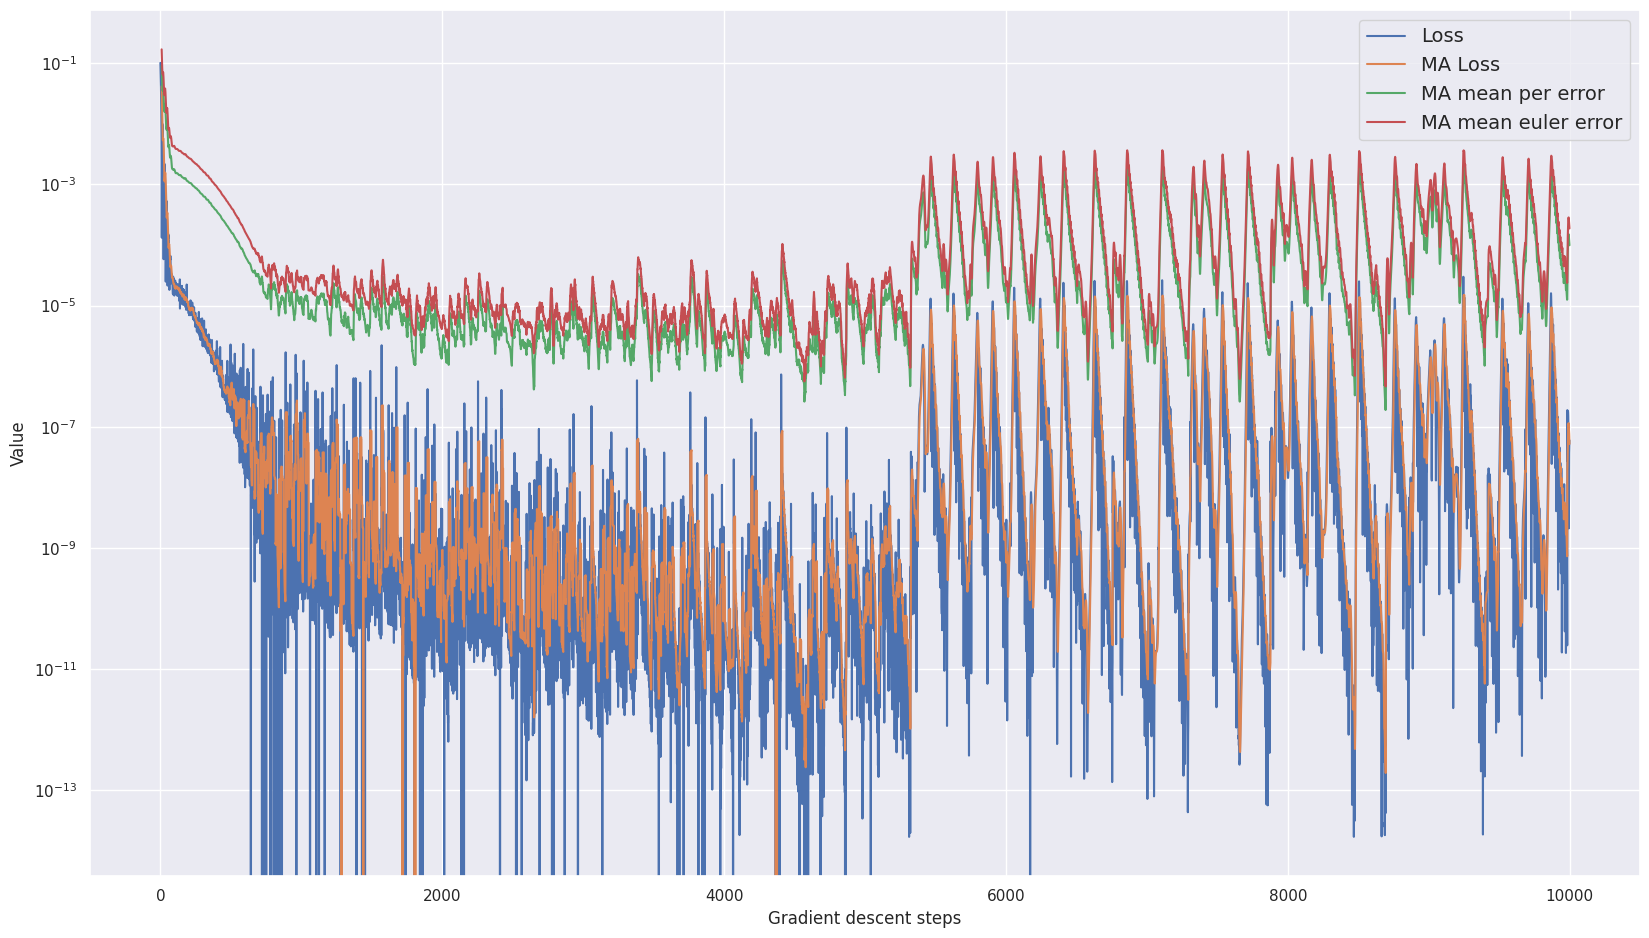

In [25]:
rate = 10
plt.plot(loss_epochs_MC, label="Loss")
plt.plot(pd.Series(loss_epochs_MC).rolling(rate).mean(), label="MA Loss")
plt.plot(pd.Series(list_perc_abs_error_MC_mean).rolling(rate).mean(), label="MA mean per error")
plt.plot(pd.Series(list_Euler_mean).rolling(rate).mean(), label="MA mean euler error")
plt.xlabel("Gradient descent steps")
plt.ylabel("Value")
plt.yscale('log')
plt.legend()

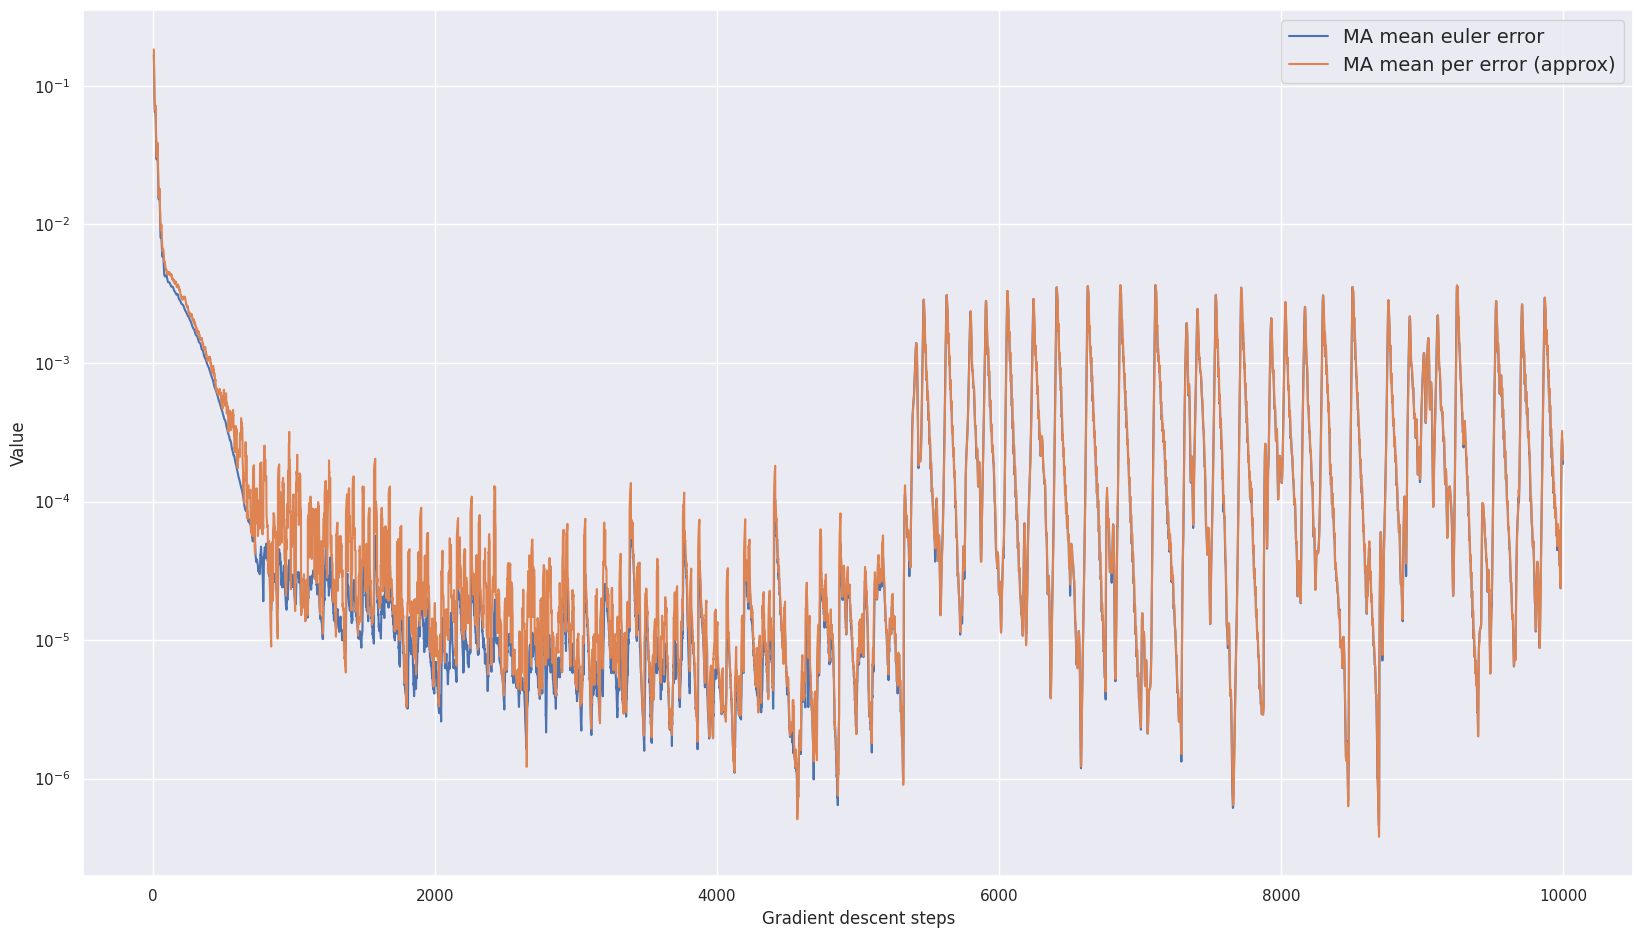

In [26]:
# Checking that the square root of the loss is a good approx of the Expected euler equation error
plt.plot(pd.Series(list_Euler_mean).rolling(rate).mean(), label="MA mean euler error")
plt.plot(pd.Series(np.sqrt(np.abs(loss_epochs_MC))).rolling(rate).mean(), label="MA mean per error (approx)")
#plt.plot(loss_epochs_MC, label="Loss")
plt.xlabel("Gradient descent steps")
plt.ylabel("Value")
plt.yscale('log')
plt.legend()

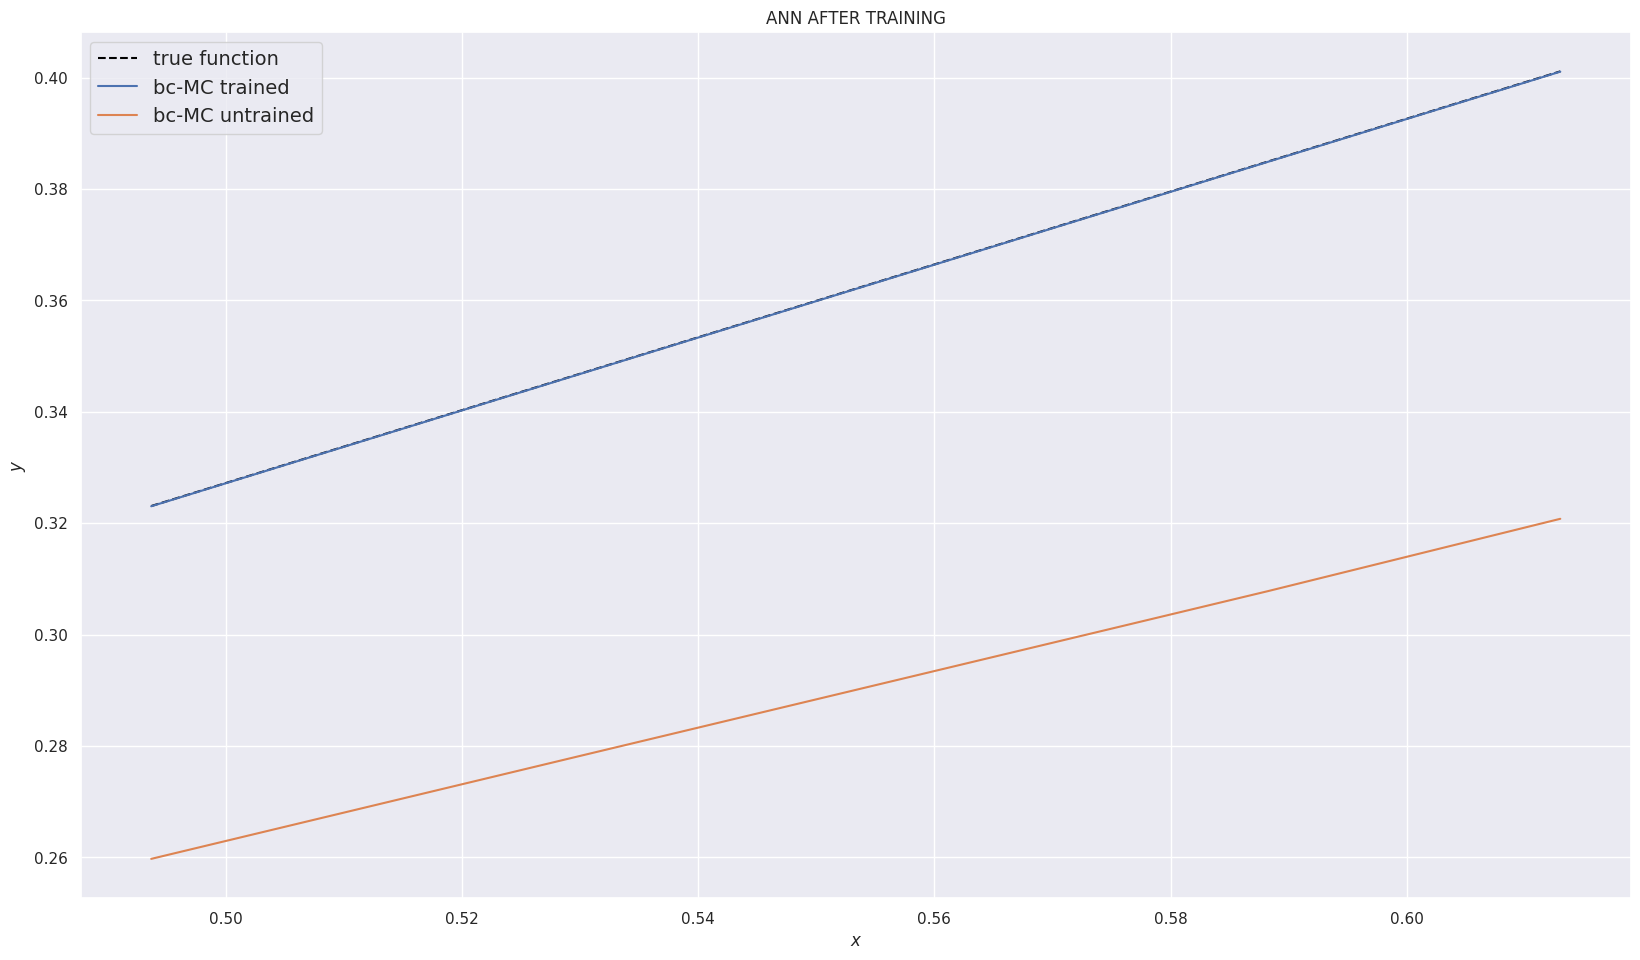

In [27]:
# Test approximation
model_MC.eval()
model_MC_untrained.eval()

# Define the grid
with torch.no_grad():
    xvec = torch.linspace(params.x_low, params.x_high, nb_points).unsqueeze(1) #add a dimension
    y_MC = model_MC(xvec)
    y_MC_untrained = model_MC_untrained(xvec)

xvec = xvec.detach().numpy()
y_MC = y_MC.detach().numpy()
y_MC_untrained = y_MC_untrained.detach().numpy()
f_true = params.true_function(xvec)

plt.plot(xvec, f_true, linestyle='--', color='black', label="true function")
plt.plot(xvec, y_MC, label='bc-MC trained')
plt.plot(xvec, y_MC_untrained, label='bc-MC untrained')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("ANN AFTER TRAINING")
plt.legend()

Mean error: -0.0001254016679013148
Median error: -0.0001254016679013148


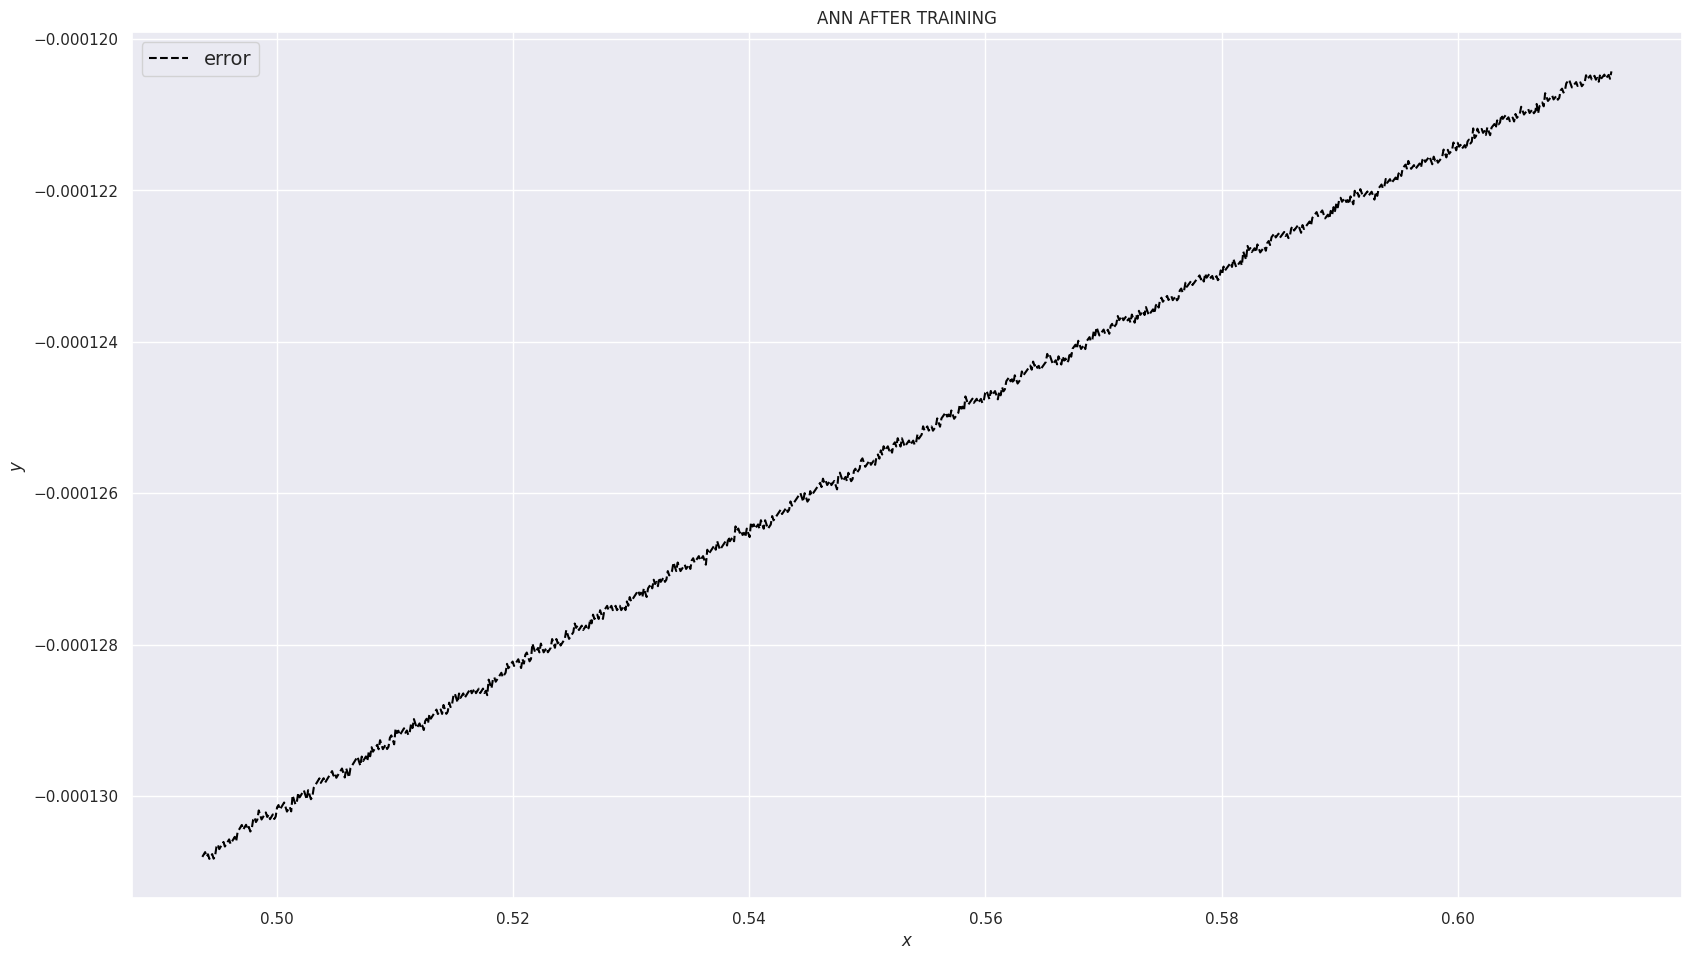

In [28]:
diff = (y_MC - f_true)/f_true
plt.plot(xvec, (y_MC - f_true)/f_true, linestyle='--', color='black', label="error")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("ANN AFTER TRAINING")
plt.legend()
print(f"Mean error: {np.mean(diff)}")
print(f"Median error: {np.mean(diff)}")

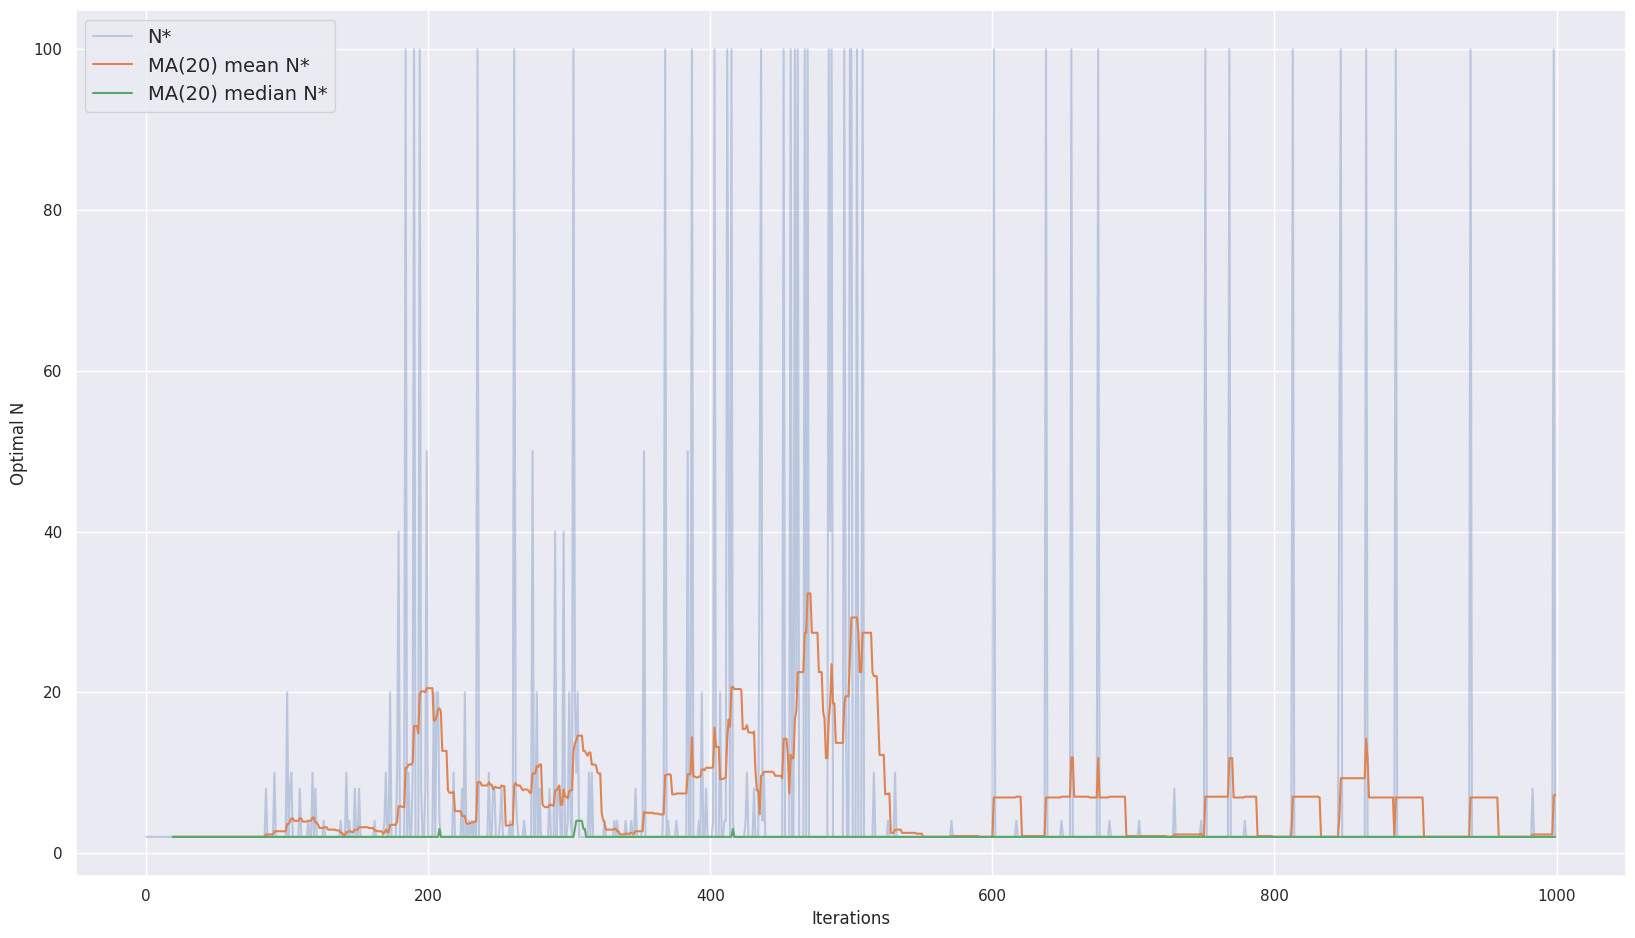

In [29]:
rate_rolling = 20
max_N = len(list_optimal_N)
plt.plot(pd.Series(list_optimal_N[:max_N]), label="N*", alpha=0.3)
plt.plot(pd.Series(list_optimal_N[:max_N]).rolling(rate_rolling).mean(), label=f"MA({rate_rolling}) mean N*")
plt.plot(pd.Series(list_optimal_N[:max_N]).rolling(rate_rolling).median(), label=f"MA({rate_rolling}) median N*")
plt.xlabel("Iterations")
plt.ylabel("Optimal N")
plt.legend()

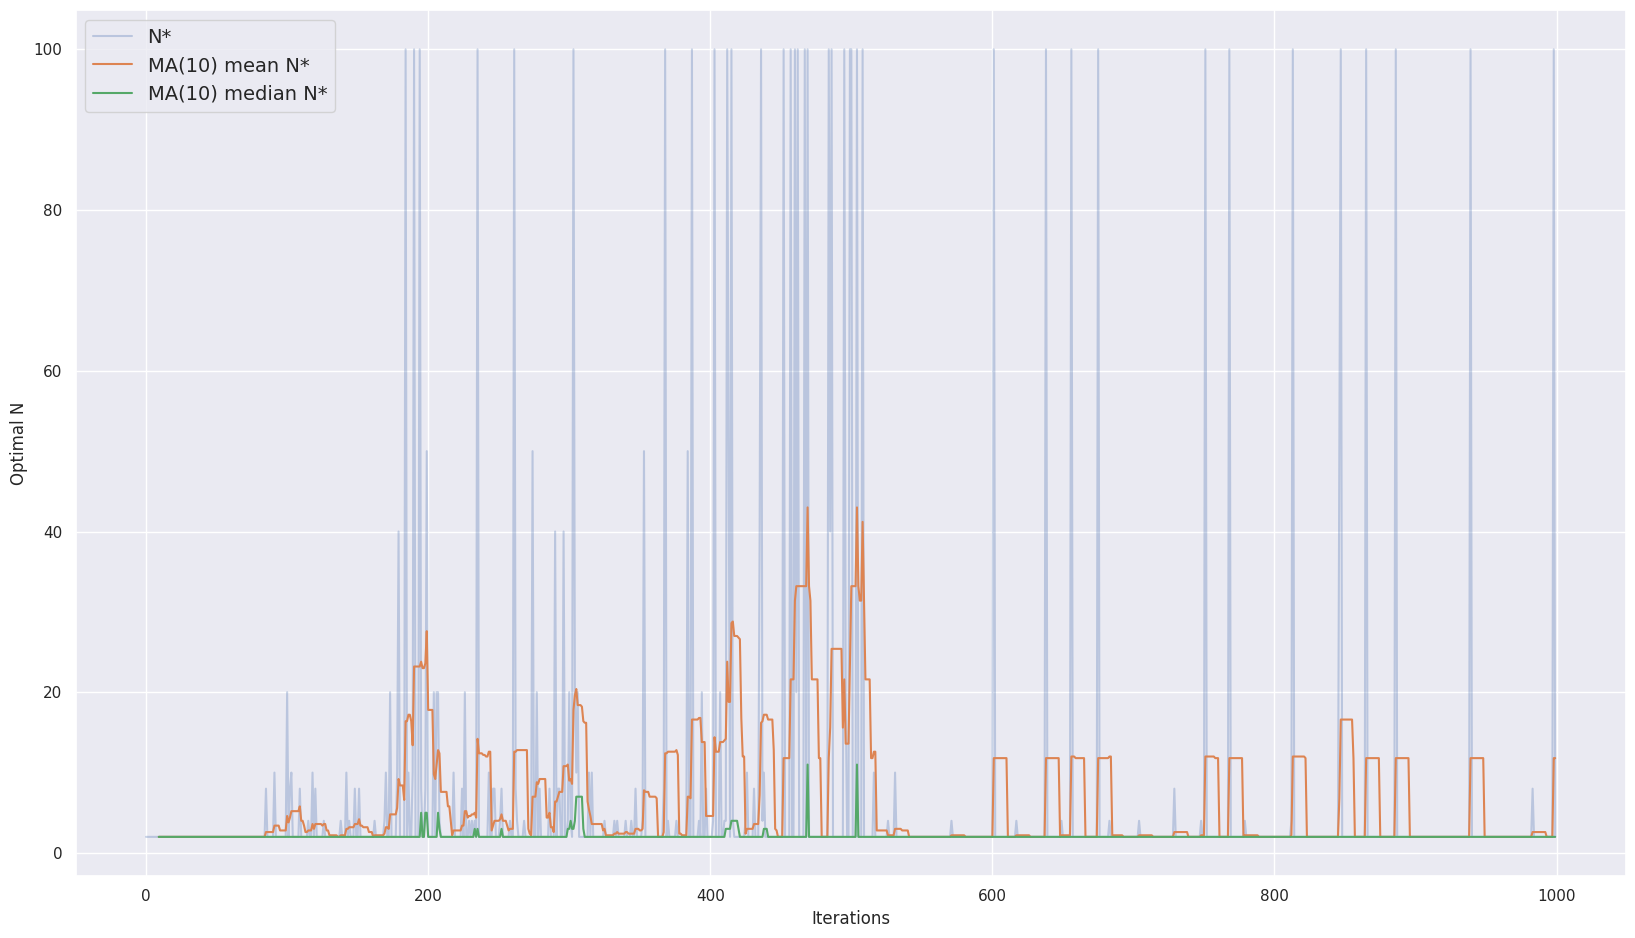

In [30]:
rate_rolling = 10
plt.plot(pd.Series(list_optimal_N), label="N*", alpha=0.3)
plt.plot(pd.Series(list_optimal_N).rolling(rate_rolling).mean(), label=f"MA({rate_rolling}) mean N*")
plt.plot(pd.Series(list_optimal_N).rolling(rate_rolling).median(), label=f"MA({rate_rolling}) median N*")
plt.xlabel("Iterations")
plt.ylabel("Optimal N")
plt.legend()

(array([0.18326531, 0.00816327, 0.        , 0.00285714, 0.        ,
        0.        , 0.        , 0.00102041, 0.        , 0.00122449,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00755102]),
 array([  2. ,   6.9,  11.8,  16.7,  21.6,  26.5,  31.4,  36.3,  41.2,
         46.1,  51. ,  55.9,  60.8,  65.7,  70.6,  75.5,  80.4,  85.3,
         90.2,  95.1, 100. ]),
 <BarContainer object of 20 artists>)

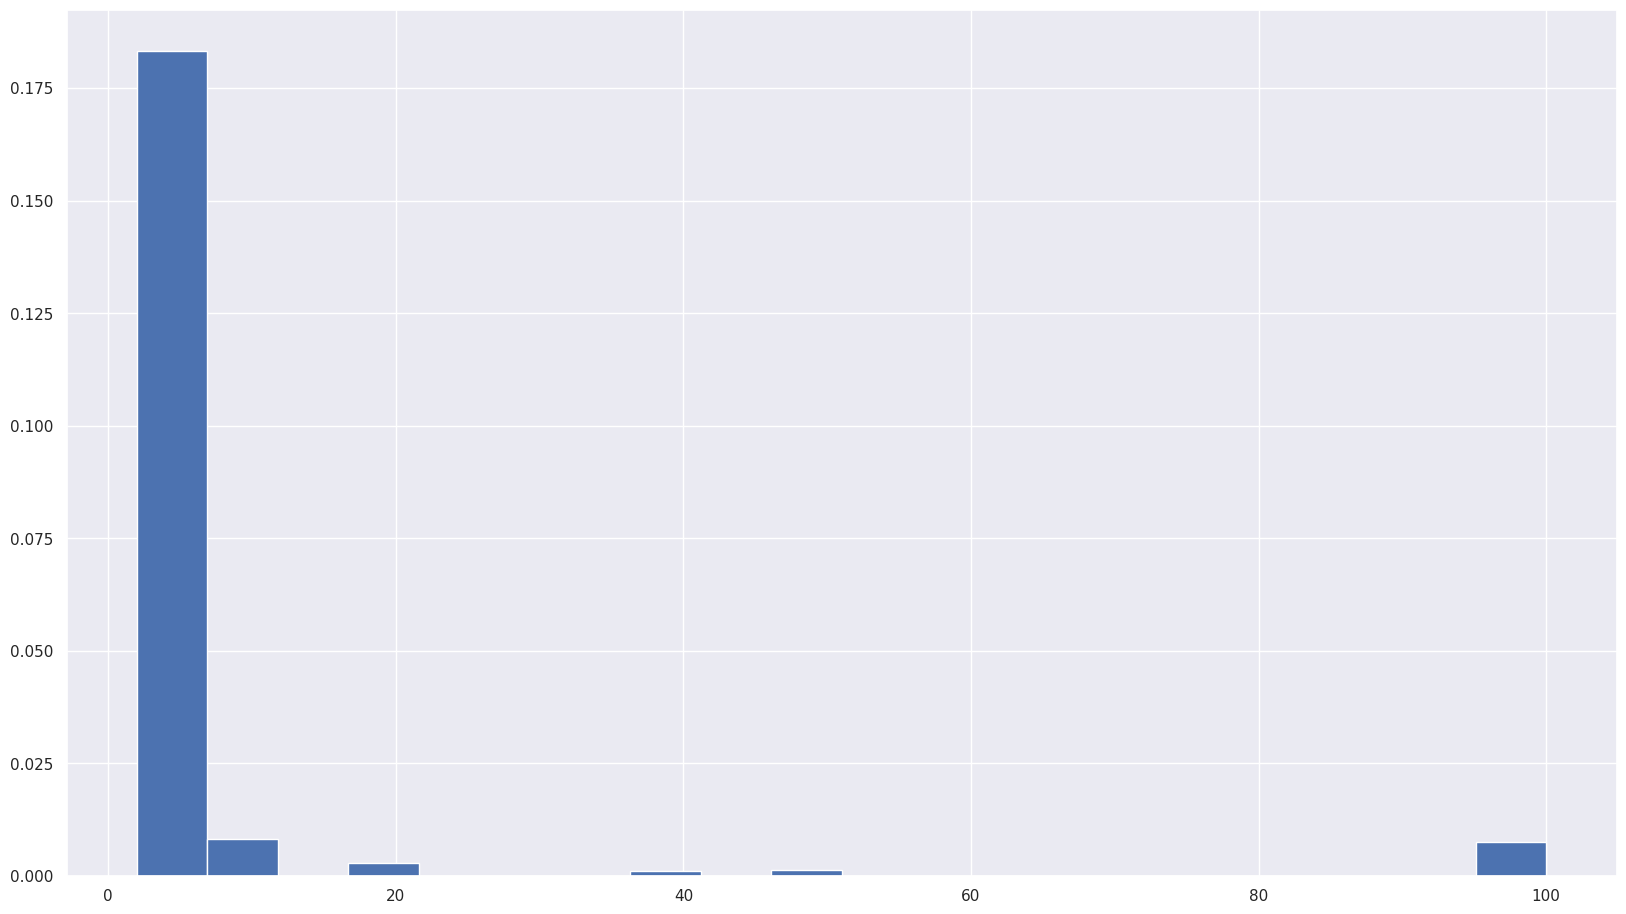

In [31]:
plt.hist(list_optimal_N, density=True, bins=20)

In [32]:
R = draw_residual(model_MC, params)

(array([ 6972.00996055, 11155.12539645, 27888.03984222, 50198.26799917,
        55775.85333241, 41831.88999931, 48803.87166586, 23704.83386588,
         5577.58533324,  6971.98166655]),
 array([-0.00025615, -0.00025256, -0.00024898, -0.00024539, -0.0002418 ,
        -0.00023822, -0.00023463, -0.00023105, -0.00022746, -0.00022388,
        -0.00022029]),
 <BarContainer object of 10 artists>)

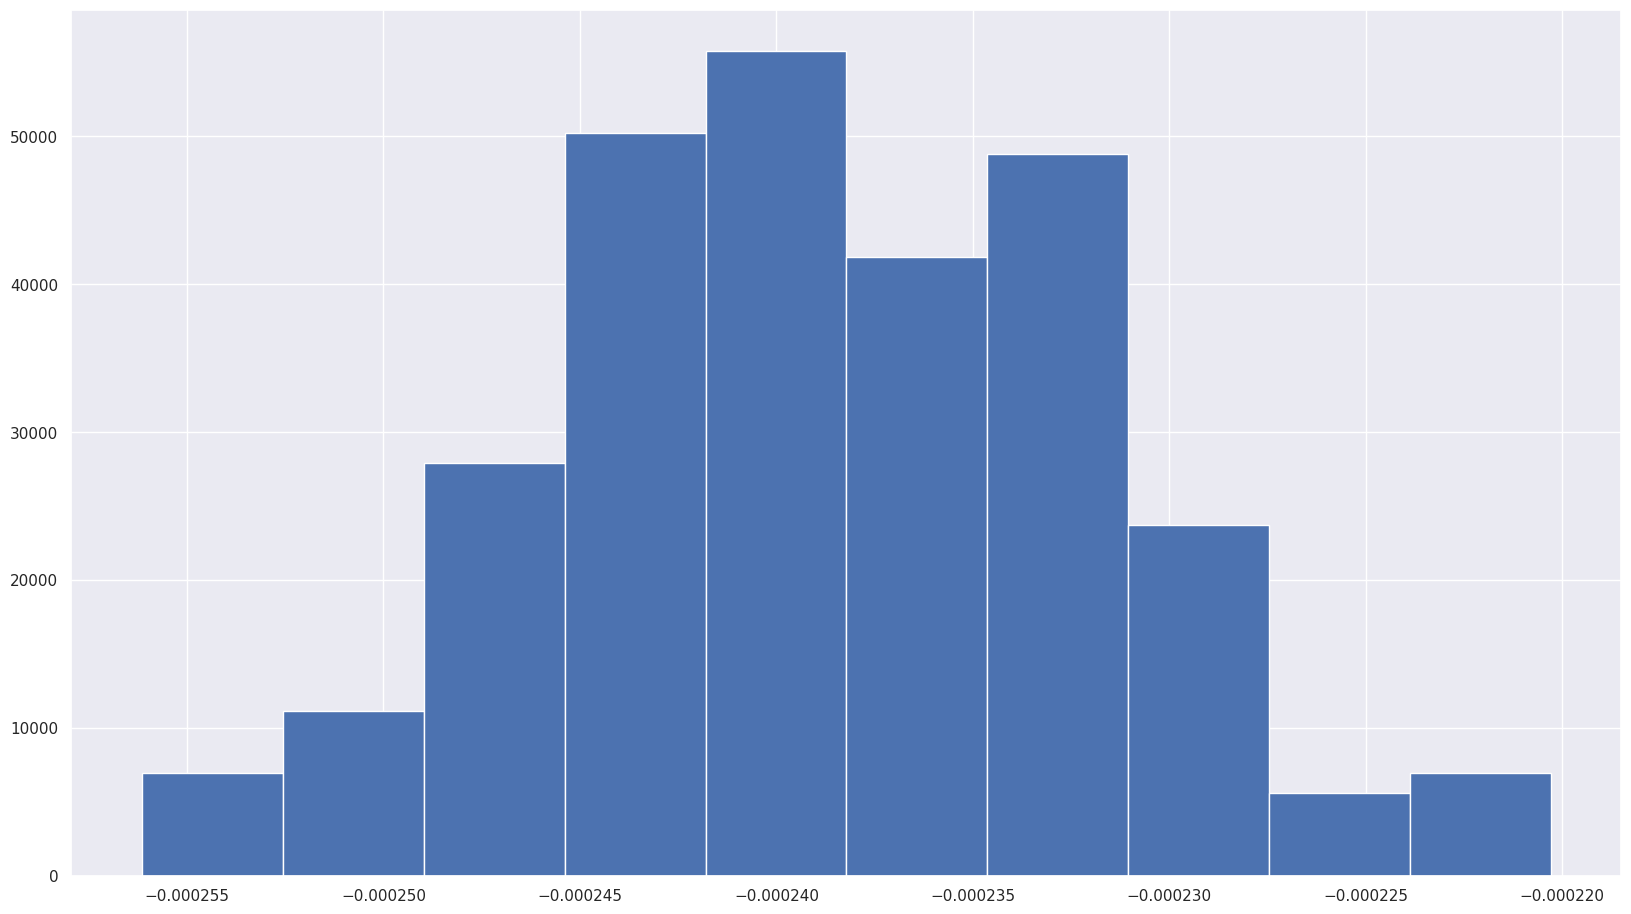

In [33]:
plt.hist(R, density=True)

In [34]:
start = timer()
var_loss = calculate_variance_loss_model_grid(model_MC, params, nb_draws_loss, grid_N, grid_M)
end = timer()
elapsed_time_bf = end - start
print(f"Elapsed time: {elapsed_time_bf} sec.")

Elapsed time: 9.345284246000006 sec.


In [35]:
nb_draws = 10000

start = timer()
var_loss_formula = calculate_variance_loss_fast(params, model_MC, nb_draws, grid_M, grid_N).detach()
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

Elapsed time: 0.010538605999954598 sec.
Speedup: 886.7666412465052 X


In [36]:
start = timer()
# formula that combines the four shocks more
var_loss_formula_2 = calculate_variance_loss_fast_2(params, model_MC, nb_draws, grid_M, grid_N).detach()
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

Elapsed time: 0.009692314999995233 sec.
Speedup: 964.1952666627737 X


In [37]:
nb_draws = 10000
nb_draws_M = 10
nb_draws_N = int(nb_draws/nb_draws_M )

start = timer()
var_loss_formula_gaussian, var_f, cov_f = calculate_variance_gaussian(params, model_MC, nb_draws, grid_M, grid_N)
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

Elapsed time: 0.00946193000004314 sec.
Speedup: 987.672097125787 X


In [39]:
np.mean(evaluate_accuracy_pytorch_frozen_Gaussian(model_MC, params, debug = True))

5.00679e-08

In [40]:
np.mean(evaluate_accuracy_pytorch_frozen_Gaussian(model_MC, params, debug = False))

0.00023920774

In [41]:
nb_draws

10000

##  Test hyperparameters with a single loop

### A. Vary M, no optimal N*

In [ ]:
if run_analysis == True: #start the analysis (can be very long)
    print("Starting analysis 1. Keeping N = 2.")

    # Plotting options
    #Plotting option
    tol_float = 10e-40 #sys.float_info.epsilon
    mult=0.5
    alpha_bands=0.05
    display_CI = False #False

    rate = 5 #20
    colors = sns.color_palette("Set1", 5)
    markers = ["o", "s", "x", "^", "D"]
    markersize= 8
    ref_freq = 50
    alpha_chosen=0.5
    list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
    prefix = "" #"" #"P50_" # ""

    #lr_loop = [0.1, 0.01, 0.001] #learning rate
    lr_loop = [0.1, 0.05, 0.01, 0.005] #[0.05, 0.01, 0.005] #learning rate
    optimizer_loop = ["Adam"] #["SGD", "Adam"]# ["SGD", "Adam"] #solvers

    α_loop = [0.995] #[0.36, 0.99]  #0.36 #0.4
    β_loop = [0.995] #[0.96, 0.99]
    T_loop = [1, 10, 100, 1000]
    divs = [1, 1, 1, 1]
    N_star_loop = [False, False, False, False]


    M_loop = [int(T/(div)) for (div, T) in zip(divs, T_loop)]
    N_loop = [int(2*T/M) for (M,T) in zip(M_loop, T_loop)] #T=MN/2

    print(f"T: {T_loop}")
    print(f"M: {M_loop}")
    print(f"N: {N_loop}")
    print(f"N_star: {N_star_loop}")
    # Safety check
    print(np.array(M_loop)*np.array(N_loop)/2)

    # Nb repetition, holding hyperparams constant
    nb_reps = 100 #10 #50 #50 #4 #10 #50 #20 #Number of times I run independent SGD, holding constant the initial parameters of the NN.
    nb_epochs_chosen = 3000 #5000 #10000 #nb SGD itetations #5000
    nb_rep_loss = 1
    nb_draws = 10000 #nb draws when calculating variance of loss

    random.seed(seed_number) # For replicability reasons
    print(random.random())
    torch.manual_seed(seed_number)


    model_bcMC = NeuralNetwork(params).to(device)
    #set_initial_values(model_bcMC , initial_guess[0], initial_guess[1])
    model_bcMC_untrained = copy.deepcopy(model_bcMC)
    # Test approximation
    model_bcMC.eval()
    model_bcMC_untrained.eval()

    # Define the grid
    with torch.no_grad():
        xvec = torch.linspace(params.x_low, params.x_high, nb_points).unsqueeze(1) #add a dimension
        y_MC = model_bcMC(xvec)
        y_MC_untrained = model_bcMC_untrained(xvec)

    xvec = xvec.detach().numpy()
    y_MC = y_MC.detach().numpy()
    y_MC_untrained = y_MC_untrained.detach().numpy()

    # store hyperparams used
    list_sigma_used = []
    list_alpha_used = []
    list_beta_used = []
    list_optimizer_used = []
    list_lr_used = []
    list_N_used = []
    list_M_used = []
    list_T_used = []
    list_N_star_used = []

    list_dfs_hyperparams = [] #to store results in a dataframe

    # Loop over sigma
    for (α_chosen, β_chosen) in zip(α_loop, β_loop):
        for optimizer_chosen in optimizer_loop: # Loop over solvers
            for lr_chosen in lr_loop:  # Loop over learning rate
                for (N_chosen, M_chosen, use_N_star) in zip(N_loop, M_loop, N_star_loop):  #Loop over (M, N) for some choices of T

                    # create a reference params object
                    params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen,
                                      nb_epochs_chosen, order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                                      α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)

                    print("nb epochs: {}".format(params.nb_epochs))
                    print("W.shape: {}".format(params.W.shape))
                    print("W_expanded.shape: {}".format(params.W_expanded.shape))
                    print("M: {}".format(params.M))
                    print("N: {}".format(params.N))
                    print("MN: {}".format(params.MN))
                    print("T: {}".format(params.T))
                    print("use_Sobol: {}".format(params.use_Sobol))
                    print("Number nodes Gaussian Q: {}".format(params.nodes.shape))
                    print("N Gaussian: {}".format(params.N_gaussian))
                    print("lr: {}".format(params.lr))
                    print("σ_e: {}".format(params.σ_e))
                    print("optimizer: {}".format(params.optimizer))
                    print("Initial guess: {}".format(initial_guess))

                    # append list
                    list_sigma_used.append(params.σ_e)
                    list_alpha_used.append(α_chosen)
                    list_beta_used.append(β_chosen)
                    list_optimizer_used.append(params.optimizer)
                    list_lr_used.append(params.lr)
                    list_N_used.append(params.N)
                    list_M_used.append(params.M)
                    list_T_used.append(params.T)
                    list_N_star_used.append(use_N_star)

                    # Create grids
                    # OLD
                    grid_N = np.array([N for N in range(2, params.T+2, 2)])
                    # NEW
                    #grid_N = np.array([N for N in range(2, 2*params.T+2, 2)])
                    grid_M = 2*params.T/grid_N

                    is_int = grid_M % 1 == 0
                    grid_N = grid_N[is_int]
                    grid_M = grid_M[is_int]

                    print(grid_N)
                    print(grid_M)
                    print(grid_N*grid_M)

                    # Pre-calculate params associated with grid choices
                    list_params = []
                    for (ind, (N_chosen, M_chosen)) in enumerate(zip(grid_N.astype('int'), grid_M.astype('int'))):
                        params_local = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen, nb_epochs_chosen,
                                                order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                                                α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)
                        list_params.append(params_local)

                    list_list_losses = []
                    list_list_perc_abs_error_MC  = [] #percentage error policy function
                    list_list_perc_abs_error_MC_mean = []
                    list_list_perc_abs_error_MC_i = [] #gradient descent step
                    list_list_perc_abs_error_MC_loss = [] #loss
                    list_list_optimal_N = [] #optimal N
                    list_list_var_loss = [] #store variance of loss
                    list_list_time = [] #store time
                    list_list_Euler_mean = [] #Euler error

                    for rep in tqdm(range(0, nb_reps)): # Loop over different iterations of solver
                        random.seed(int(rep)) #same series of shocks for same rep
                        torch.manual_seed(int(rep)) #same series of shocks for same rep
                        # A new NN
                        model_MC = NeuralNetwork(params).to(device)
                        #model_MC = copy.deepcopy(model_bcMC) #create a copy of NN
                        model_MC.train()

                        optimizer = create_optimizer(model_MC, params.optimizer, params.lr, params.momentum)

                        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
                        loss_epochs_MC = torch.zeros(params.nb_epochs)
                        list_perc_abs_error_MC = [] #store abs value percentage error
                        list_perc_abs_error_MC_mean = []
                        list_perc_abs_error_MC_i = [] #store index i
                        list_perc_abs_error_MC_loss = [] #store loss
                        list_MC_gradient = [] #store the norm of the gradient
                        list_time = [] #
                        list_Euler_mean = [] #Euler error
                        calculate_variance_grad = False
                        calculate_variance_loss = True #calculate for info. no update
                        list_var_loss = [] #store variance of the loss
                        list_optimal_N = [] #store the optimal N. Calculated every freq_var iterations
                        list_optimal_N_current = [] #store the current optimal N used.
                        optimal_N = params.N
                        index_best_N = np.where(grid_N == optimal_N)[0][0]
                        freq_loss = 1 #calculate loss every freq_loss iterations.
                        freq_var = 10 #freq_loss #10 #calculate variance every freq_var iterations.
                        ratio_freq_loss_freq_var = int(freq_var/freq_loss)
                        use_exact_accuracy_metrics = False # If False, use square loss to get the EEE

                        start = timer()
                        for i in range(0, params.nb_epochs):
                            optimizer.zero_grad()
                            # params associated with the current best N:
                            params_local = list_params[index_best_N]
                            loss = (1/nb_rep_loss)*Ξ_torch_MC(model_MC, params_local)
                            for j in range(1, nb_rep_loss):
                                loss += (1/nb_rep_loss)*Ξ_torch_MC(model_MC, params_local)
                            loss_epochs_MC[[i]] = float(loss.item())

                            # Backpropagation
                            loss.backward()
                            clip_grad_norm_(model_MC.parameters(), max_norm=1.0, error_if_nonfinite=False)
                            optimizer.step()

                            if i % freq_loss == 0: #Monitor the predictive power
                                list_perc_abs_error_MC_loss.append(float(loss.item()))# store loss
                                list_optimal_N_current.append(optimal_N) #N used
                                list_perc_abs_error_MC_i.append(i) #store nb gradient descent steps
                                # Alternative measurements of accuracy. Slower when True
                                if use_exact_accuracy_metrics == True:
                                    with torch.no_grad():
                                        y_MC = model_MC(params.xvec_test_torch)
                                    y_MC = y_MC.detach().numpy()
                                    perc_abs_error_MC = np.abs((y_MC -  params.f_true )/ params.f_true )
                                    list_perc_abs_error_MC.append(np.median(perc_abs_error_MC)) #median
                                    list_perc_abs_error_MC_mean.append(np.mean(perc_abs_error_MC)) #mean
                                    list_Euler_mean.append(np.mean(evaluate_accuracy_pytorch_frozen_Gaussian(model_MC, params)))
                                else:
                                    EEE = np.abs(float(loss.item()))**0.5
                                    list_perc_abs_error_MC.append(-1)
                                    list_perc_abs_error_MC_mean.append(-1)
                                    list_Euler_mean.append(EEE)

                                # Calculate time
                                now = timer()
                                elapsed_time = now - start
                                list_time.append(elapsed_time)
                                if calculate_variance_grad == True:
                                    total_norm = 0
                                    # Store the norm of the gradient
                                    for p in model_MC.parameters():
                                        param_norm = p.grad.detach().data.norm(2)
                                        total_norm += param_norm.item() ** 2
                                    total_norm = total_norm ** 0.5
                                    list_MC_gradient.append(total_norm)
                            if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
                                # Variance of the loss associated with each choice of M and N
                                # Gaussian formula
                                var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_MC, nb_draws, grid_M, grid_N)
                                # When N is kept cst, still append list
                                if use_N_star == False:
                                    index_best_N_dummy = np.argmin(var_loss_formula)
                                    optimal_N_dummy = grid_N[index_best_N_dummy]
                                    list_optimal_N.append(optimal_N_dummy)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                                # When N* algo is used, update the value of N during training
                                else:
                                    index_best_N = np.argmin(var_loss_formula)
                                    optimal_N = grid_N[index_best_N]
                                    list_optimal_N.append(optimal_N)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                            if i % 1000 == 0:
                                loss, current = float(loss.item()), i
                                print(f"N: {optimal_N} loss: {loss:>7f}, mean euler error {list_perc_abs_error_MC_mean[-1]:>7f}, [{current:>5d}/{params_local.nb_epochs:>5d}]")
                            if (i % params_local.freq_scheduler == 0) & (i != 0) & (params_local.use_scheduler == True):
                                scheduler.step()
                                print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

                        if params_local.optimizer == "SWA":
                            optimizer.swap_swa_sgd()

                        #Store values
                        list_list_perc_abs_error_MC.append(list_perc_abs_error_MC) #percentage error policy function
                        list_list_perc_abs_error_MC_mean.append(list_perc_abs_error_MC_mean) #percentage error policy function (mean)
                        list_list_perc_abs_error_MC_i.append(list_perc_abs_error_MC_i) #index
                        list_list_perc_abs_error_MC_loss.append(list_perc_abs_error_MC_loss) #loss
                        list_list_optimal_N.append(list_optimal_N_current) #optimal N
                        list_list_var_loss.append(list_var_loss)
                        list_list_time.append(list_time)
                        list_list_Euler_mean.append(list_Euler_mean)
                    # Create dataframe and summary stats
                    lst = list(range(0,nb_reps))
                    list_index_rep = list(np.repeat(lst, len(list_perc_abs_error_MC_i))) #gradient descent steps

                    df_bcMC_loop = pd.DataFrame({
                                        'repetition': list_index_rep,
                                        'iter': numpy_flat(list_list_perc_abs_error_MC_i),
                                        'loss': np.abs(numpy_flat(list_list_perc_abs_error_MC_loss)),
                                        'med_percentage_error': numpy_flat(list_list_perc_abs_error_MC),
                                        'mean_percentage_error': numpy_flat(list_list_perc_abs_error_MC_mean),
                                        'mean_Euler_error': numpy_flat(list_list_Euler_mean),
                                        'optimal_N': numpy_flat(list_list_optimal_N),
                                        'var_loss': np.repeat(numpy_flat(list_list_var_loss), ratio_freq_loss_freq_var),
                                        'time': numpy_flat(list_list_time),
                       })

                    print(df_bcMC_loop.head())

                    # Statistics on results
                    df_bcMC_loop_average = df_bcMC_loop.groupby('iter').mean().reset_index() #mean value by iteration
                    df_bcMC_loop_average.head()

                    list_cols = ["loss", "med_percentage_error", "mean_percentage_error", "mean_Euler_error", "optimal_N", "var_loss", "time"]

                    for col in list_cols:
                        df_bcMC_loop_average["min_" + col] = df_bcMC_loop.groupby('iter')[col].min().reset_index()[col]
                        df_bcMC_loop_average["max_" + col] = df_bcMC_loop.groupby('iter')[col].max().reset_index()[col]
                        df_bcMC_loop_average["std_" + col] = df_bcMC_loop.groupby('iter')[col].std().reset_index()[col]
                        for qq in [5, 10, 25, 50, 75, 90, 95]:
                            df_bcMC_loop_average["P" + str(qq) + "_" + col] = df_bcMC_loop.groupby('iter')[col].quantile(qq/100).reset_index()[col]


                    # append list
                    list_dfs_hyperparams.append(df_bcMC_loop_average)
                #------------------------------------
                # End of different choices for (M,N):
                # Plot
                #------------------------------------
                df_hyperparams = pd.DataFrame({"sigma_e":list_sigma_used,
                        "alpha": list_alpha_used,
                        "beta": list_beta_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

                # select combination
                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
                df_sel = df_sel[df_sel["alpha"] == α_chosen]
                df_sel = df_sel[df_sel["beta"] == β_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)

                list_dfs_plot = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                for (i, min_index) in enumerate([0]):
                    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                    fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)

                    """
                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:], df[f"{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")
                    """

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax3.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")


                    #var = "mean_percentage_error"
                    var = "mean_Euler_error"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax4.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax4.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)

                    ax4.set_yscale('log')
                    ax4.set_title('Mean Euler equation error')
                    ax4.set_xlabel("Iterations")

                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:] - mult*df[f"std_{var}"][min_index:], df[f"{prefix}{var}"][min_index:] + mult*df[f"std_{var}"][min_index:], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

                    figname = output_folder + f'changing_M_simga_e_{σ_e_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.png'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)

                    figname = output_folder + f'changing_M_simga_e_{σ_e_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.pdf'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)
                    plt.show()


In [ ]:
extension_csv_file = "changing_M"

if save_to_csv == True:
    print("Writting CSV")

    df_hyperparams = pd.DataFrame({"sigma_e":list_sigma_used,
                        "alpha": list_alpha_used,
                        "beta": list_beta_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

    df_hyperparams.to_csv(output_folder + f"hyperparams_{extension_csv_file}.csv", index=False)
    print(df_hyperparams)

    index_df = 0
    for index, row in df_hyperparams.iterrows():
        σ_e_chosen = row['sigma_e']
        α_chosen = row['alpha']
        β_chosen = row['beta']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
        list_dfs_hyperparams[index_df].to_csv(filen, index=False)
        index_df+=1


Writting CSV
    sigma_e  alpha   beta optim     lr  N     M     T  N_star
0      0.05  0.995  0.995  Adam  0.100  2     1     1   False
1      0.05  0.995  0.995  Adam  0.100  2    10    10   False
2      0.05  0.995  0.995  Adam  0.100  2   100   100   False
3      0.05  0.995  0.995  Adam  0.100  2  1000  1000   False
4      0.05  0.995  0.995  Adam  0.050  2     1     1   False
5      0.05  0.995  0.995  Adam  0.050  2    10    10   False
6      0.05  0.995  0.995  Adam  0.050  2   100   100   False
7      0.05  0.995  0.995  Adam  0.050  2  1000  1000   False
8      0.05  0.995  0.995  Adam  0.010  2     1     1   False
9      0.05  0.995  0.995  Adam  0.010  2    10    10   False
10     0.05  0.995  0.995  Adam  0.010  2   100   100   False
11     0.05  0.995  0.995  Adam  0.010  2  1000  1000   False
12     0.05  0.995  0.995  Adam  0.005  2     1     1   False
13     0.05  0.995  0.995  Adam  0.005  2    10    10   False
14     0.05  0.995  0.995  Adam  0.005  2   100   100   F

In [ ]:
# Load files
if read_from_csv == True:
    print("Reading CSV")

    df_hyperparams = pd.read_csv(output_folder + f'hyperparams_{extension_csv_file}.csv')
    print(df_hyperparams)

    list_dfs_hyperparams = []
    for index, row in df_hyperparams.iterrows():
        σ_e_chosen = row['sigma_e']
        α_chosen = row['alpha']
        β_chosen = row['beta']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
        list_dfs_hyperparams.append(pd.read_csv(filen))


Reading CSV
    sigma_e  alpha   beta optim     lr  N     M     T  N_star
0      0.05  0.995  0.995  Adam  0.100  2     1     1   False
1      0.05  0.995  0.995  Adam  0.100  2    10    10   False
2      0.05  0.995  0.995  Adam  0.100  2   100   100   False
3      0.05  0.995  0.995  Adam  0.100  2  1000  1000   False
4      0.05  0.995  0.995  Adam  0.050  2     1     1   False
5      0.05  0.995  0.995  Adam  0.050  2    10    10   False
6      0.05  0.995  0.995  Adam  0.050  2   100   100   False
7      0.05  0.995  0.995  Adam  0.050  2  1000  1000   False
8      0.05  0.995  0.995  Adam  0.010  2     1     1   False
9      0.05  0.995  0.995  Adam  0.010  2    10    10   False
10     0.05  0.995  0.995  Adam  0.010  2   100   100   False
11     0.05  0.995  0.995  Adam  0.010  2  1000  1000   False
12     0.05  0.995  0.995  Adam  0.005  2     1     1   False
13     0.05  0.995  0.995  Adam  0.005  2    10    10   False
14     0.05  0.995  0.995  Adam  0.005  2   100   100   Fa

   sigma_e  alpha   beta optim   lr  N     M     T  N_star
0     0.05  0.995  0.995  Adam  0.1  2     1     1   False
1     0.05  0.995  0.995  Adam  0.1  2    10    10   False
2     0.05  0.995  0.995  Adam  0.1  2   100   100   False
3     0.05  0.995  0.995  Adam  0.1  2  1000  1000   False


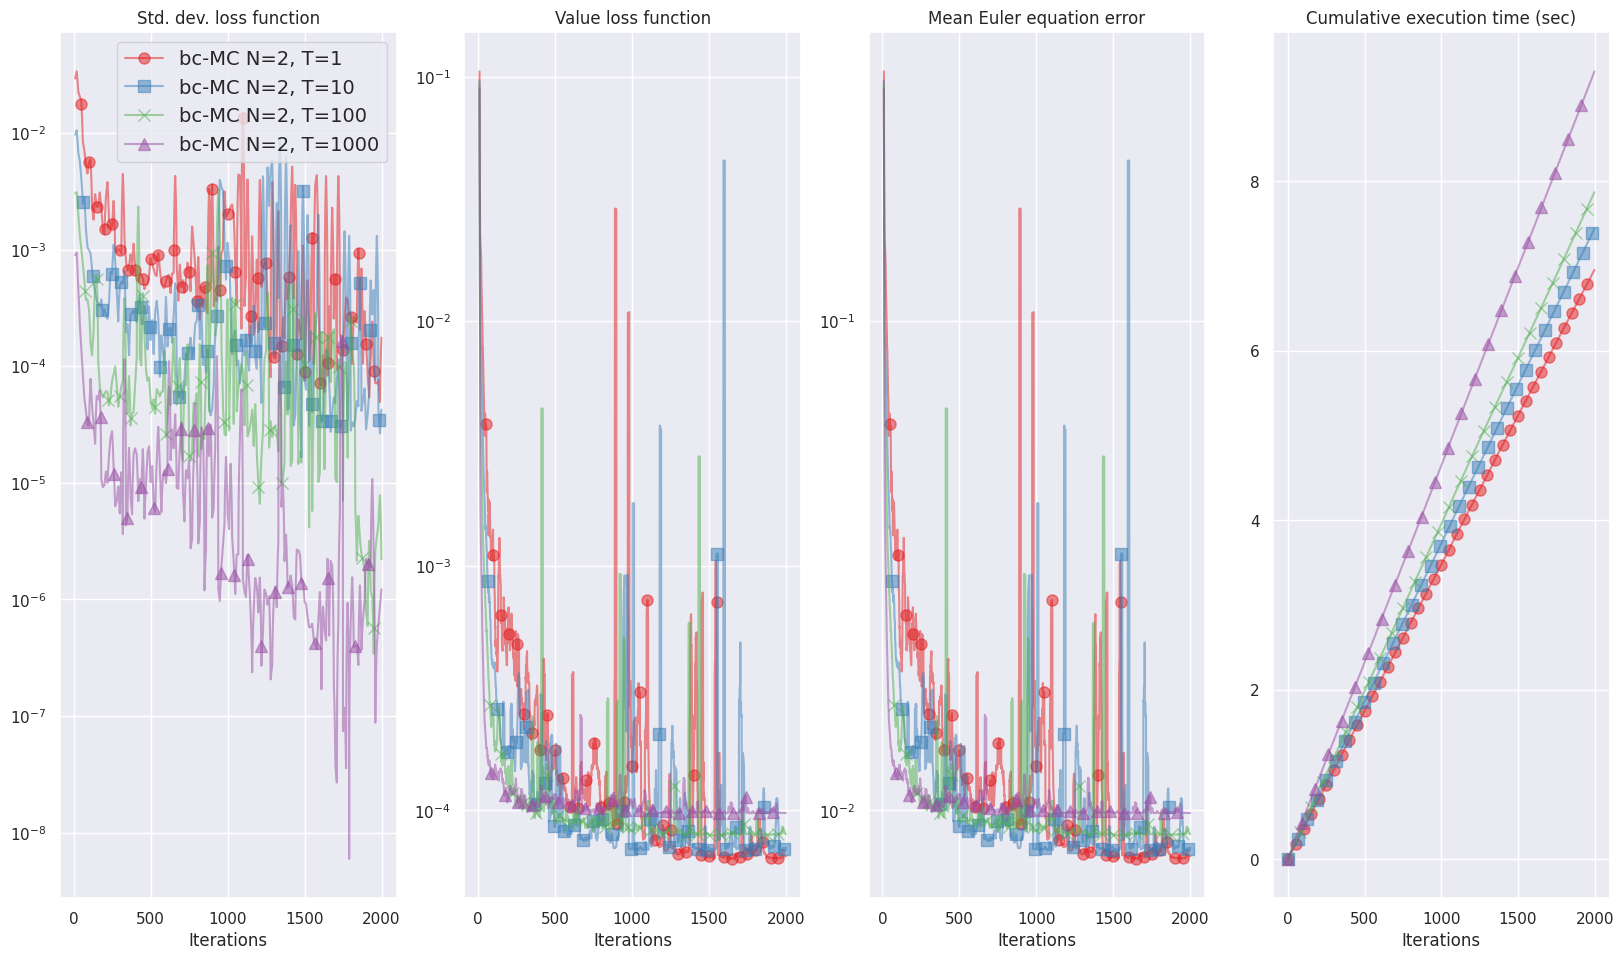

   sigma_e  alpha   beta optim    lr  N     M     T  N_star
4     0.05  0.995  0.995  Adam  0.05  2     1     1   False
5     0.05  0.995  0.995  Adam  0.05  2    10    10   False
6     0.05  0.995  0.995  Adam  0.05  2   100   100   False
7     0.05  0.995  0.995  Adam  0.05  2  1000  1000   False


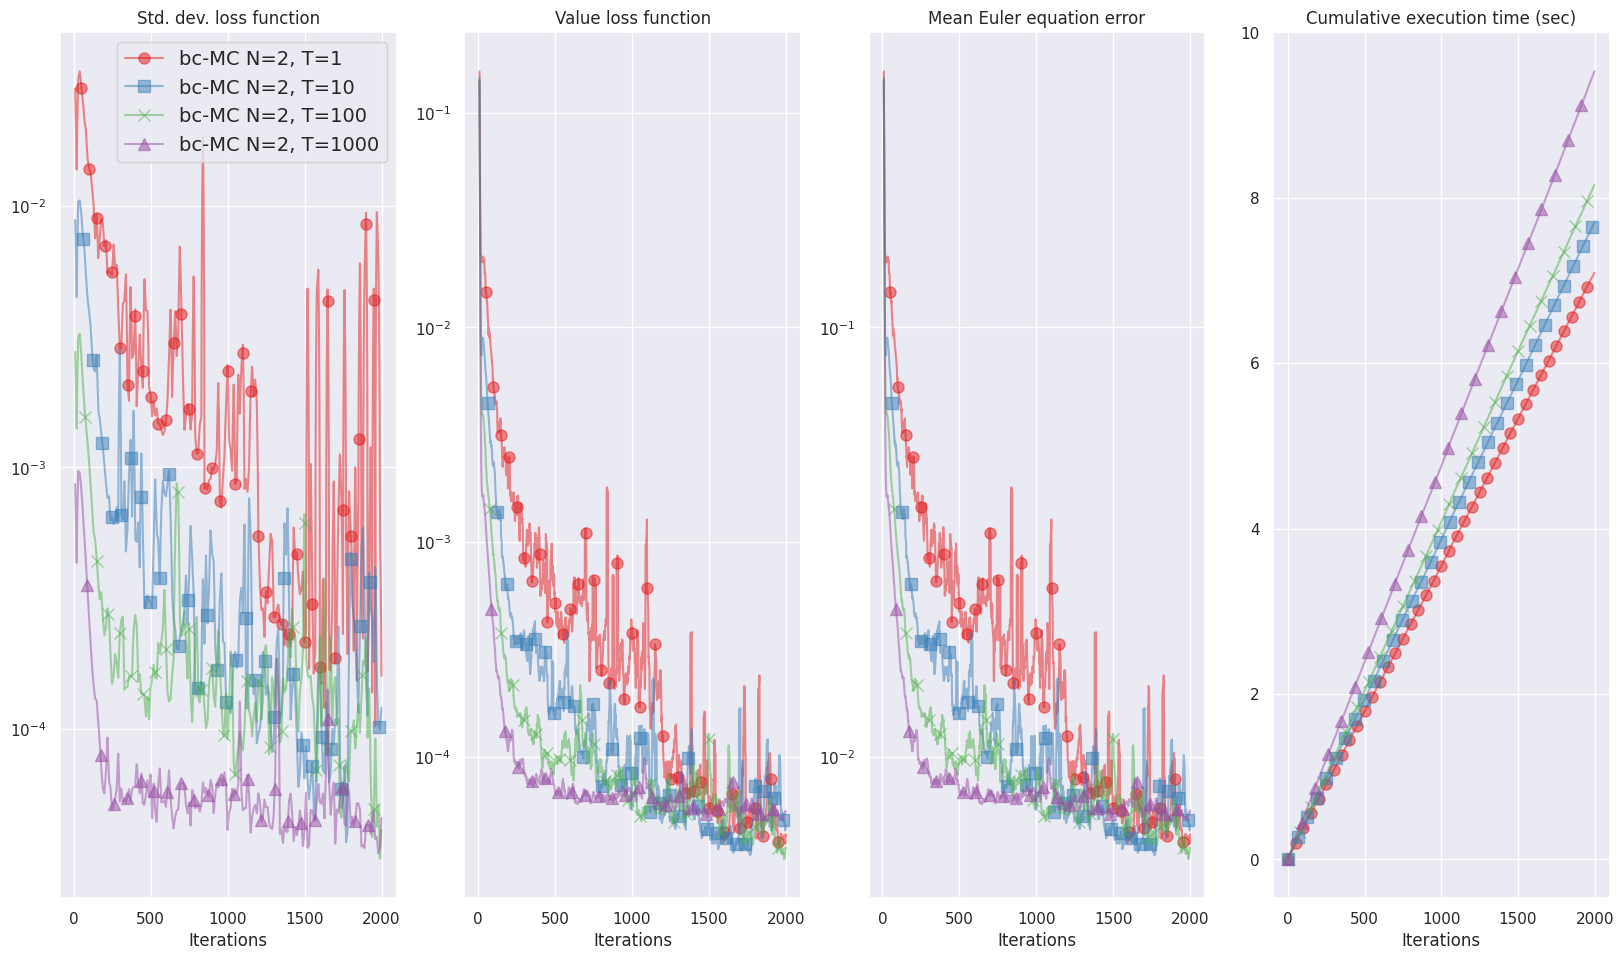

    sigma_e  alpha   beta optim    lr  N     M     T  N_star
8      0.05  0.995  0.995  Adam  0.01  2     1     1   False
9      0.05  0.995  0.995  Adam  0.01  2    10    10   False
10     0.05  0.995  0.995  Adam  0.01  2   100   100   False
11     0.05  0.995  0.995  Adam  0.01  2  1000  1000   False


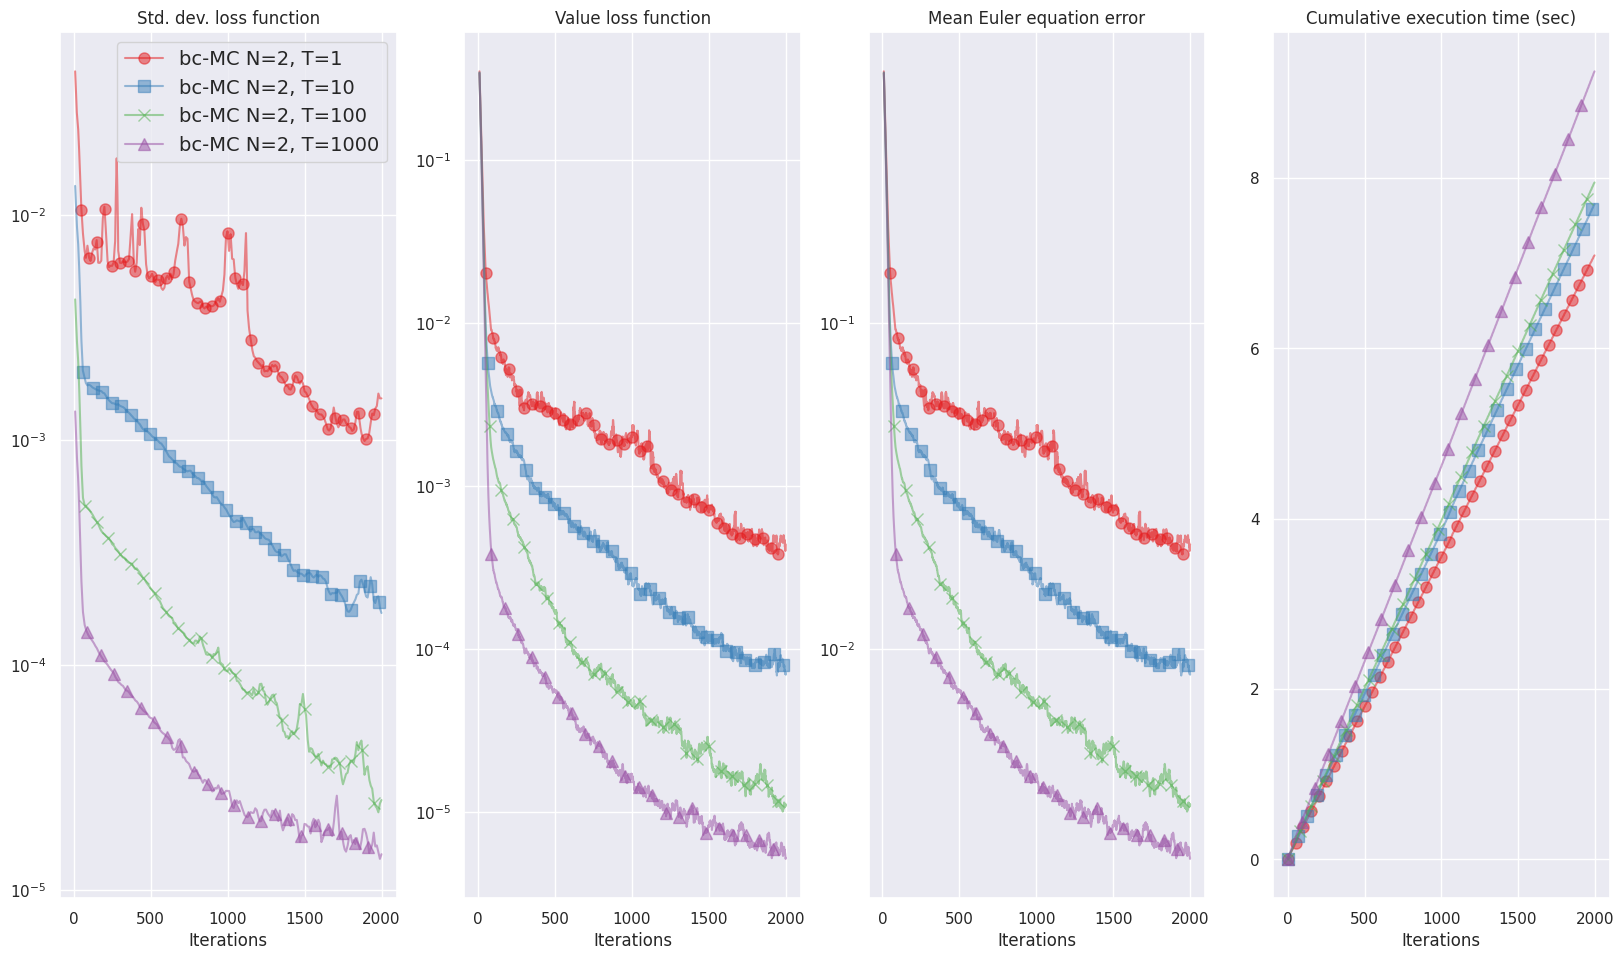

    sigma_e  alpha   beta optim     lr  N     M     T  N_star
12     0.05  0.995  0.995  Adam  0.005  2     1     1   False
13     0.05  0.995  0.995  Adam  0.005  2    10    10   False
14     0.05  0.995  0.995  Adam  0.005  2   100   100   False
15     0.05  0.995  0.995  Adam  0.005  2  1000  1000   False


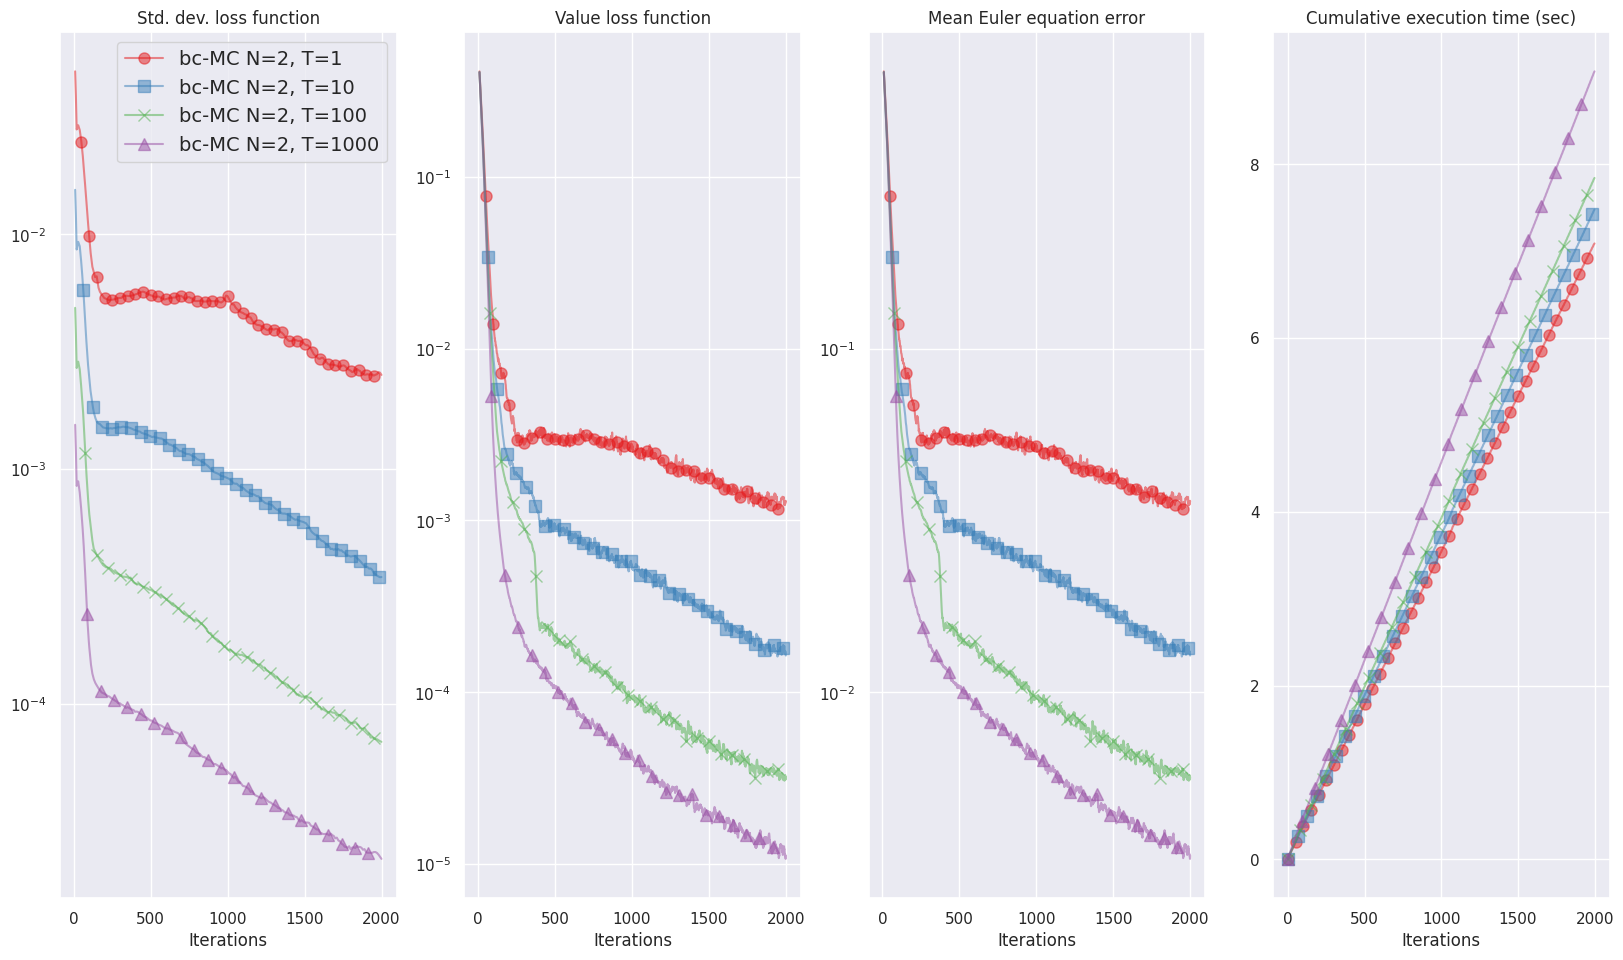

In [ ]:
mult=0.5
alpha_bands=0.10
display_CI = False #False

rate = 10 #20
colors = sns.color_palette("Set1", 5)
markers = ["o", "s", "x", "^", "D"]
markersize= 8
ref_freq = 50
alpha_chosen=0.5
list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
prefix = "" #"" #"" #"P50_" # ""

list_combinations_used = []
for index, row in df_hyperparams.iterrows():
    σ_e_chosen = row['sigma_e']
    α_chosen = row['alpha']
    β_chosen = row['beta']
    optimizer_chosen = row["optim"]
    lr_chosen = row["lr"]
    N_chosen = row["N"]
    M_chosen = row["M"]
    use_N_star = row["N_star"]

    combination = f'{optimizer_chosen}-{σ_e_chosen}-{α_chosen}-{β_chosen}-{lr_chosen}'
    if combination not in list_combinations_used:
        list_combinations_used.append(combination)
    else:
        continue #If combination already used, pass
    df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
    df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
    df_sel = df_sel[df_sel["alpha"] == α_chosen]
    df_sel = df_sel[df_sel["beta"] == β_chosen]
    df_sel = df_sel[df_sel["lr"] == lr_chosen]
    print(df_sel)


    list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
    list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
    list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
    list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
    list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

    list_labels = []
    for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
        if N_star == True:
            list_labels += [f"bc-MC N*, T={T}"]
        else:
            list_labels += [f"bc-MC N={N}, T={T}"]
    #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

    #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
    for (i, (min_index, max_index)) in enumerate(zip([0], [2000])):
        #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
        fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)

        """
        var = "optimal_N"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
        #ax1.set_yscale('log')
        ax1.set_title('Value for N')
        ax1.set_xlabel("Iterations")
        """

        var = "var_loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax2.set_yscale('log')
        ax2.set_title('Std. dev. loss function')
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Iterations")

        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax3.set_yscale('log')
        ax3.set_title('Value loss function')
        ax3.set_xlabel("Iterations")

        """
        #var = "mean_percentage_error"
        var = "mean_Euler_error"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        """
        # square root series for loss
        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
            MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

        ax4.set_yscale('log')
        ax4.set_title('Mean Euler equation error')
        ax4.set_xlabel("Iterations")

        var = "time"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

        ax5.set_xlabel("Iterations")
        ax5.set_title("Cumulative execution time (sec)")

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
        plt.savefig(figname, bbox_inches="tight", dpi=300)

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
        plt.savefig(figname, bbox_inches="tight", dpi=300)
        plt.show()


### B. Vary M and N and test optimal N*

Starting analysis 2. Changing N.
T: [100, 100, 100, 100]
M: [100, 2, 10, 100]
N: [2, 100, 20, 2]
N_star: [True, False, False, False]
[100. 100. 100. 100.]
0.9664535356921388
nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.1
σ_e: 0.05
optimizer: Adam
Initial guess: [2.0, 2.0]
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:11<19:45, 11.98s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:23<19:27, 11.91s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:35<19:10, 11.86s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:47<18:59, 11.87s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [00:59<18:40, 11.80s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:10<18:25, 11.76s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:23<18:25, 11.88s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:33<17:42, 11.55s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:45<17:29, 11.53s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [01:57<17:26, 11.63s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:08<17:15, 11.64s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:20<17:03, 11.63s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:32<17:01, 11.74s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:43<16:32, 11.54s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [02:55<16:24, 11.58s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000051, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:08<17:02, 12.17s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:20<16:36, 12.01s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:32<16:23, 12.00s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:43<16:02, 11.88s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [03:54<15:23, 11.54s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000031, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:08<15:55, 12.10s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:20<15:52, 12.22s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:34<16:08, 12.57s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:46<15:49, 12.49s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [04:58<15:28, 12.38s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:10<15:12, 12.33s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:21<14:32, 11.96s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:33<14:23, 11.99s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:45<14:11, 11.99s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [05:57<13:53, 11.91s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:09<13:51, 12.05s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:21<13:36, 12.00s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:32<12:59, 11.63s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [06:44<12:54, 11.74s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [06:57<12:59, 12.00s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:09<12:50, 12.04s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:21<12:43, 12.13s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:33<12:23, 11.99s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [07:44<11:51, 11.67s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [07:56<11:46, 11.77s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:08<11:35, 11.79s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:19<11:25, 11.81s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:31<11:11, 11.78s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [08:45<11:29, 12.32s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [08:56<11:05, 12.09s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:08<10:50, 12.04s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:20<10:32, 11.94s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:32<10:17, 11.87s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [09:43<10:04, 11.85s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000071, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [09:56<10:03, 12.07s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:07<09:37, 11.79s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:19<09:26, 11.81s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:31<09:14, 11.80s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [10:43<09:04, 11.84s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [10:55<09:01, 12.04s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:07<08:46, 11.96s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:18<08:22, 11.69s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:30<08:18, 11.87s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [11:43<08:18, 12.15s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [11:55<08:00, 12.01s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:07<07:45, 11.93s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:20<07:54, 12.49s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:32<07:31, 12.19s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [12:43<07:06, 11.85s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [12:55<06:54, 11.85s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:07<06:46, 11.95s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:19<06:34, 11.96s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [13:31<06:20, 11.88s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [13:43<06:09, 11.91s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [13:54<05:49, 11.65s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:05<05:38, 11.68s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:17<05:27, 11.70s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [14:30<05:23, 11.98s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [14:42<05:10, 11.93s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [14:53<04:53, 11.75s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [15:04<04:38, 11.61s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:16<04:31, 11.79s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [15:28<04:19, 11.81s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [15:40<04:07, 11.80s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [15:52<03:57, 11.86s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [16:04<03:44, 11.81s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:15<03:30, 11.70s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [16:27<03:21, 11.87s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [16:40<03:12, 12.03s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [16:52<02:59, 11.94s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [17:04<02:48, 12.01s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:16<02:35, 11.98s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000103, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000061, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [17:29<02:28, 12.35s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [17:40<02:12, 12.04s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [17:52<01:59, 11.95s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [18:04<01:48, 12.01s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [18:17<01:37, 12.13s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [18:28<01:24, 12.03s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [18:39<01:09, 11.62s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [18:51<00:58, 11.69s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [19:03<00:47, 11.75s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [19:14<00:35, 11.73s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [19:26<00:23, 11.68s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [19:38<00:11, 11.74s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [19:49<00:00, 11.89s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.143463                    -1                     -1   
2           0     2  0.059426                    -1                     -1   
3           0     3  0.015906                    -1                     -1   
4           0     4  0.002728                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000016  0.004355  
1          0.378765          2  0.000016  0.013018  
2          0.243775          2  0.000016  0.016176  
3          0.126119          2  0.000016  0.019244  
4          0.052228          2  0.000016  0.022296  
nb epochs: 3000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.1
σ_e: 0.05
optimizer: Adam
In

  0%|          | 0/100 [00:00<?, ?it/s]

N: 100 loss: 0.248682, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:15<24:47, 15.02s/it]

N: 100 loss: 0.420476, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:29<24:05, 14.75s/it]

N: 100 loss: 0.362278, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:43<23:26, 14.50s/it]

N: 100 loss: 0.456161, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:57<22:44, 14.21s/it]

N: 100 loss: 0.972487, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000067, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:11<22:20, 14.11s/it]

N: 100 loss: 0.609952, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:25<21:59, 14.03s/it]

N: 100 loss: 0.404486, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:39<21:44, 14.03s/it]

N: 100 loss: 0.581645, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:53<21:27, 14.00s/it]

N: 100 loss: 0.401968, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [02:07<21:07, 13.92s/it]

N: 100 loss: 0.282014, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:20<20:50, 13.90s/it]

N: 100 loss: 0.483488, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:34<20:40, 13.94s/it]

N: 100 loss: 0.696662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:48<20:27, 13.94s/it]

N: 100 loss: 0.220297, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [03:02<20:09, 13.90s/it]

N: 100 loss: 0.589019, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [03:16<19:52, 13.87s/it]

N: 100 loss: 0.425803, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:30<19:36, 13.84s/it]

N: 100 loss: 0.558191, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:44<19:25, 13.88s/it]

N: 100 loss: 0.349822, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:58<19:13, 13.89s/it]

N: 100 loss: 0.387245, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [04:12<19:00, 13.91s/it]

N: 100 loss: 0.335877, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [04:26<18:46, 13.91s/it]

N: 100 loss: 0.662327, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:40<18:36, 13.96s/it]

N: 100 loss: 0.220577, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:54<18:26, 14.01s/it]

N: 100 loss: 0.510344, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [05:08<18:09, 13.97s/it]

N: 100 loss: 0.295837, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [05:21<17:50, 13.90s/it]

N: 100 loss: 0.540944, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [05:35<17:34, 13.88s/it]

N: 100 loss: 0.398336, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:49<17:22, 13.90s/it]

N: 100 loss: 0.379170, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [06:03<17:05, 13.86s/it]

N: 100 loss: 0.229392, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [06:17<16:49, 13.83s/it]

N: 100 loss: 0.365438, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [06:31<16:37, 13.85s/it]

N: 100 loss: 0.363630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [06:45<16:26, 13.89s/it]

N: 100 loss: 0.453324, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:59<16:15, 13.93s/it]

N: 100 loss: 0.416755, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [07:13<16:02, 13.94s/it]

N: 100 loss: 0.534378, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [07:26<15:43, 13.88s/it]

N: 100 loss: 0.530693, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [07:40<15:32, 13.92s/it]

N: 100 loss: 1.118090, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:54<15:13, 13.85s/it]

N: 100 loss: 0.322391, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [08:08<14:56, 13.79s/it]

N: 100 loss: 1.889362, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [08:23<15:04, 14.13s/it]

N: 100 loss: 0.207583, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [08:36<14:46, 14.07s/it]

N: 100 loss: 0.569633, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [08:50<14:29, 14.02s/it]

N: 100 loss: 0.693010, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [09:04<14:10, 13.93s/it]

N: 100 loss: 0.544501, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [09:18<13:51, 13.86s/it]

N: 100 loss: 0.621430, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [09:31<13:31, 13.76s/it]

N: 100 loss: 0.629796, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [09:45<13:22, 13.84s/it]

N: 100 loss: 0.485311, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [09:59<13:08, 13.83s/it]

N: 100 loss: 0.596891, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [10:13<12:53, 13.82s/it]

N: 100 loss: 0.291771, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [10:27<12:39, 13.81s/it]

N: 100 loss: 0.209776, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [10:41<12:29, 13.88s/it]

N: 100 loss: 0.399524, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [10:55<12:13, 13.84s/it]

N: 100 loss: 0.495454, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [11:08<12:00, 13.85s/it]

N: 100 loss: 0.453223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [11:22<11:47, 13.86s/it]

N: 100 loss: 0.216828, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [11:36<11:30, 13.82s/it]

N: 100 loss: 0.561826, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [11:50<11:17, 13.83s/it]

N: 100 loss: 0.226875, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [12:04<11:03, 13.83s/it]

N: 100 loss: 0.388258, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [12:18<10:50, 13.85s/it]

N: 100 loss: 0.414661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [12:32<10:39, 13.90s/it]

N: 100 loss: 0.679266, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [12:46<10:27, 13.95s/it]

N: 100 loss: 0.849393, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [13:00<10:17, 14.04s/it]

N: 100 loss: 0.345523, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [13:14<10:01, 13.99s/it]

N: 100 loss: 0.235907, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [13:28<09:45, 13.95s/it]

N: 100 loss: 0.822469, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [13:42<09:32, 13.97s/it]

N: 100 loss: 0.351806, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [13:56<09:18, 13.97s/it]

N: 100 loss: 0.432548, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [14:09<09:02, 13.92s/it]

N: 100 loss: 0.343199, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [14:23<08:48, 13.91s/it]

N: 100 loss: 0.461383, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [14:37<08:35, 13.94s/it]

N: 100 loss: 0.568571, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [14:51<08:24, 14.00s/it]

N: 100 loss: 0.448835, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [15:05<08:07, 13.94s/it]

N: 100 loss: 0.576097, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [15:19<07:53, 13.94s/it]

N: 100 loss: 0.544630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [15:33<07:39, 13.92s/it]

N: 100 loss: 0.492632, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [15:47<07:26, 13.95s/it]

N: 100 loss: 0.572105, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [16:01<07:11, 13.92s/it]

N: 100 loss: 0.614231, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [16:15<06:56, 13.89s/it]

N: 100 loss: 0.408705, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [16:30<06:55, 14.34s/it]

N: 100 loss: 0.460451, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [16:44<06:37, 14.21s/it]

N: 100 loss: 0.685762, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [16:58<06:20, 14.10s/it]

N: 100 loss: 0.655881, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [17:12<06:04, 14.04s/it]

N: 100 loss: 0.408490, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [17:26<05:50, 14.01s/it]

N: 100 loss: 0.304024, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [17:40<05:37, 14.06s/it]

N: 100 loss: 0.643821, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [17:54<05:23, 14.07s/it]

N: 100 loss: 0.304605, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [18:08<05:08, 14.03s/it]

N: 100 loss: 0.382223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [18:22<04:54, 14.01s/it]

N: 100 loss: 0.350153, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [18:36<04:39, 13.99s/it]

N: 100 loss: 0.420951, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [18:50<04:26, 14.00s/it]

N: 100 loss: 0.204643, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [19:04<04:11, 13.96s/it]

N: 100 loss: 0.499147, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000018, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [19:18<03:56, 13.91s/it]

N: 100 loss: 0.363667, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [19:31<03:41, 13.86s/it]

N: 100 loss: 0.378662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [19:45<03:28, 13.89s/it]

N: 100 loss: 0.569345, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [19:59<03:13, 13.85s/it]

N: 100 loss: 0.577437, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [20:13<02:59, 13.81s/it]

N: 100 loss: 0.306528, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [20:27<02:45, 13.81s/it]

N: 100 loss: 0.334845, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [20:40<02:31, 13.81s/it]

N: 100 loss: 0.709472, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [20:54<02:17, 13.78s/it]

N: 100 loss: 0.408035, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [21:08<02:03, 13.73s/it]

N: 100 loss: 0.719085, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [21:21<01:49, 13.72s/it]

N: 100 loss: 0.487689, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [21:35<01:36, 13.74s/it]

N: 100 loss: 0.451427, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [21:49<01:22, 13.80s/it]

N: 100 loss: 0.955420, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [22:03<01:09, 13.82s/it]

N: 100 loss: 0.487141, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [22:17<00:55, 13.83s/it]

N: 100 loss: 0.494050, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [22:31<00:41, 13.85s/it]

N: 100 loss: 0.678578, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000024, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [22:45<00:27, 13.97s/it]

N: 100 loss: 0.436585, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [22:59<00:13, 13.97s/it]

N: 100 loss: 0.494948, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [23:13<00:00, 13.93s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.248682                    -1                     -1   
1           0     1  0.141026                    -1                     -1   
2           0     2  0.046941                    -1                     -1   
3           0     3  0.015039                    -1                     -1   
4           0     4  0.000841                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.498681        100  0.000786  0.006597  
1          0.375534        100  0.000786  0.015601  
2          0.216658        100  0.000786  0.019316  
3          0.122635        100  0.000786  0.023077  
4          0.029003        100  0.000786  0.026765  
nb epochs: 3000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.1
σ_e: 0.05
optimizer: Adam
I

  0%|          | 0/100 [00:00<?, ?it/s]

N: 20 loss: 0.285526, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<20:50, 12.63s/it]

N: 20 loss: 0.411092, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:25<20:33, 12.59s/it]

N: 20 loss: 0.364123, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:37<20:10, 12.48s/it]

N: 20 loss: 0.473612, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:49<19:45, 12.35s/it]

N: 20 loss: 1.061327, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:03<20:20, 12.84s/it]

N: 20 loss: 0.616245, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:14<19:26, 12.41s/it]

N: 20 loss: 0.431010, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:26<18:50, 12.15s/it]

N: 20 loss: 0.573357, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:38<18:39, 12.17s/it]

N: 20 loss: 0.400381, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:51<18:29, 12.19s/it]

N: 20 loss: 0.263189, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:03<18:16, 12.18s/it]

N: 20 loss: 0.481962, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:15<18:08, 12.23s/it]

N: 20 loss: 0.688444, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:27<17:44, 12.09s/it]

N: 20 loss: 0.214307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:38<17:14, 11.89s/it]

N: 20 loss: 0.549825, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:50<17:08, 11.96s/it]

N: 20 loss: 0.417409, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:03<17:06, 12.08s/it]

N: 20 loss: 0.561821, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:15<16:58, 12.12s/it]

N: 20 loss: 0.359728, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:27<16:49, 12.16s/it]

N: 20 loss: 0.364721, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:39<16:37, 12.17s/it]

N: 20 loss: 0.359007, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:51<16:09, 11.96s/it]

N: 20 loss: 0.639543, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:02<15:46, 11.83s/it]

N: 20 loss: 0.243399, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:15<15:44, 11.95s/it]

N: 20 loss: 0.543043, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:27<15:37, 12.02s/it]

N: 20 loss: 0.294497, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:39<15:32, 12.11s/it]

N: 20 loss: 0.532436, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:51<15:21, 12.13s/it]

N: 20 loss: 0.416610, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:03<15:06, 12.08s/it]

N: 20 loss: 0.381012, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:15<14:45, 11.96s/it]

N: 20 loss: 0.254923, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:27<14:34, 11.99s/it]

N: 20 loss: 0.365263, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:39<14:26, 12.04s/it]

N: 20 loss: 0.363103, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:51<14:18, 12.09s/it]

N: 20 loss: 0.452882, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:04<14:09, 12.13s/it]

N: 20 loss: 0.418877, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:16<13:59, 12.17s/it]

N: 20 loss: 0.511751, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:28<13:40, 12.06s/it]

N: 20 loss: 0.499498, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:39<13:17, 11.90s/it]

N: 20 loss: 0.971841, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [06:51<13:13, 12.02s/it]

N: 20 loss: 0.320231, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:04<13:06, 12.10s/it]

N: 20 loss: 1.670661, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:16<12:58, 12.17s/it]

N: 20 loss: 0.206789, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:28<12:47, 12.19s/it]

N: 20 loss: 0.574939, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:41<12:37, 12.21s/it]

N: 20 loss: 0.694292, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000067, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [07:52<12:12, 12.00s/it]

N: 20 loss: 0.670294, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:04<11:54, 11.90s/it]

N: 20 loss: 0.624783, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:16<11:51, 12.07s/it]

N: 20 loss: 0.640795, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000046, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:28<11:41, 12.09s/it]

N: 20 loss: 0.424738, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:41<11:32, 12.14s/it]

N: 20 loss: 0.585680, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [08:53<11:21, 12.17s/it]

N: 20 loss: 0.290988, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:07<11:36, 12.66s/it]

N: 20 loss: 0.214447, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:19<11:17, 12.54s/it]

N: 20 loss: 0.380256, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:30<10:46, 12.19s/it]

N: 20 loss: 0.485695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:42<10:31, 12.14s/it]

N: 20 loss: 0.450732, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [09:55<10:21, 12.19s/it]

N: 20 loss: 0.205096, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:07<10:13, 12.27s/it]

N: 20 loss: 0.556405, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:19<10:02, 12.30s/it]

N: 20 loss: 0.231718, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:32<09:52, 12.34s/it]

N: 20 loss: 0.388695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000125, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:44<09:35, 12.24s/it]

N: 20 loss: 0.430693, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [10:57<09:37, 12.56s/it]

N: 20 loss: 0.673908, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:12<09:56, 13.26s/it]

N: 20 loss: 0.870859, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:24<09:31, 12.98s/it]

N: 20 loss: 0.357344, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:37<09:09, 12.78s/it]

N: 20 loss: 0.249105, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss:     nan, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:49<08:51, 12.65s/it]

N: 20 loss: 0.841505, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:01<08:33, 12.53s/it]

N: 20 loss: 0.336113, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:14<08:17, 12.44s/it]

N: 20 loss: 0.437770, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:25<07:53, 12.13s/it]

N: 20 loss: 0.342713, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:37<07:39, 12.09s/it]

N: 20 loss: 0.467646, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:49<07:30, 12.17s/it]

N: 20 loss: 0.575015, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:02<07:19, 12.20s/it]

N: 20 loss: 0.471325, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:14<07:09, 12.26s/it]

N: 20 loss: 0.573774, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:26<06:56, 12.26s/it]

N: 20 loss: 0.556425, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:38<06:40, 12.13s/it]

N: 20 loss: 0.499242, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [13:50<06:21, 11.93s/it]

N: 20 loss: 0.569666, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:02<06:12, 12.02s/it]

N: 20 loss: 0.617082, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:14<06:04, 12.16s/it]

N: 20 loss: 0.407892, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:27<05:54, 12.23s/it]

N: 20 loss: 0.461091, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000054, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:39<05:42, 12.22s/it]

N: 20 loss: 0.685481, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [14:51<05:30, 12.23s/it]

N: 20 loss: 0.662758, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:03<05:14, 12.09s/it]

N: 20 loss: 0.418911, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:15<04:59, 11.99s/it]

N: 20 loss: 0.306046, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [15:27<04:52, 12.17s/it]

N: 20 loss: 0.639320, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:40<04:41, 12.25s/it]

N: 20 loss: 0.313651, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [15:52<04:29, 12.26s/it]

N: 20 loss: 0.405830, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:04<04:17, 12.27s/it]

N: 20 loss: 0.351630, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:17<04:05, 12.30s/it]

N: 20 loss: 0.422523, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.015103, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [16:28<03:50, 12.11s/it]

N: 20 loss: 0.203392, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:40<03:35, 11.95s/it]

N: 20 loss: 0.490705, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [16:52<03:24, 12.01s/it]

N: 20 loss: 0.357613, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:06<03:23, 12.70s/it]

N: 20 loss: 0.385200, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:19<03:08, 12.56s/it]

N: 20 loss: 0.568992, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [17:31<02:53, 12.40s/it]

N: 20 loss: 0.601128, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:42<02:36, 12.06s/it]

N: 20 loss: 0.311414, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000032, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000068, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [17:54<02:23, 11.99s/it]

N: 20 loss: 0.352369, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:06<02:12, 12.05s/it]

N: 20 loss: 0.686711, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [18:18<02:01, 12.12s/it]

N: 20 loss: 0.406723, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [18:30<01:49, 12.13s/it]

N: 20 loss: 0.719014, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [18:42<01:37, 12.14s/it]

N: 20 loss: 0.492243, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [18:54<01:23, 11.96s/it]

N: 20 loss: 0.448590, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:06<01:11, 11.85s/it]

N: 20 loss: 0.971316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [19:18<00:59, 11.97s/it]

N: 20 loss: 0.490840, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [19:30<00:48, 12.10s/it]

N: 20 loss: 0.493514, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [19:42<00:36, 12.13s/it]

N: 20 loss: 0.699975, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [19:55<00:24, 12.16s/it]

N: 20 loss: 0.440561, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:07<00:12, 12.18s/it]

N: 20 loss: 0.496467, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [20:18<00:00, 12.19s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.285526                    -1                     -1   
1           0     1  0.132408                    -1                     -1   
2           0     2  0.059806                    -1                     -1   
3           0     3  0.017037                    -1                     -1   
4           0     4  0.000826                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.534347         20  0.000155  0.007227  
1          0.363878         20  0.000155  0.016403  
2          0.244554         20  0.000155  0.019850  
3          0.130527         20  0.000155  0.023164  
4          0.028740         20  0.000155  0.050829  
nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.1
σ_e: 0.05
optimizer: Adam


  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:11<19:45, 11.98s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:23<19:32, 11.97s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:35<19:13, 11.89s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:47<19:05, 11.93s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [00:58<18:28, 11.67s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:10<18:00, 11.50s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:21<17:54, 11.56s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:33<17:47, 11.60s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:45<17:45, 11.71s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [01:56<17:23, 11.59s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:07<16:48, 11.33s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:19<16:45, 11.42s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:30<16:44, 11.54s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:42<16:36, 11.59s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [02:54<16:24, 11.59s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000044, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:04<15:51, 11.32s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:16<15:46, 11.40s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:28<15:41, 11.48s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:40<15:39, 11.60s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [03:51<15:32, 11.66s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:02<15:00, 11.40s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:13<14:48, 11.39s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:27<15:19, 11.94s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:39<15:04, 11.90s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [04:50<14:50, 11.87s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:02<14:37, 11.85s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:13<13:58, 11.49s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:24<13:49, 11.52s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:36<13:48, 11.67s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [05:48<13:43, 11.76s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:00<13:33, 11.80s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:12<13:14, 11.68s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:23<12:52, 11.52s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [06:35<12:44, 11.59s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [06:46<12:37, 11.66s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [06:58<12:27, 11.68s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:10<12:15, 11.68s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:21<11:46, 11.40s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [07:32<11:39, 11.46s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [07:44<11:36, 11.60s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [07:56<11:25, 11.62s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:08<11:22, 11.76s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:22<11:50, 12.46s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [08:33<11:14, 12.05s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [08:44<10:53, 11.87s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [08:56<10:38, 11.83s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:08<10:26, 11.82s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:20<10:12, 11.78s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [09:31<09:53, 11.63s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [09:42<09:33, 11.48s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [09:54<09:28, 11.60s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:06<09:19, 11.67s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:18<09:09, 11.68s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [10:29<08:58, 11.72s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [10:40<08:37, 11.50s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [10:52<08:27, 11.54s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:04<08:20, 11.64s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:16<08:09, 11.66s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [11:27<07:58, 11.67s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [11:38<07:40, 11.52s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [11:50<07:27, 11.49s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:02<07:19, 11.56s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:15<07:24, 12.01s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [12:27<07:17, 12.16s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000074, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [12:39<07:04, 12.13s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [12:51<06:50, 12.08s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:02<06:26, 11.72s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [13:14<06:15, 11.73s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [13:26<06:04, 11.77s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [13:37<05:53, 11.78s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [13:49<05:43, 11.84s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:01<05:27, 11.69s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [14:12<05:10, 11.50s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [14:23<05:00, 11.56s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [14:35<04:50, 11.61s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [14:47<04:39, 11.66s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [14:58<04:26, 11.60s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [15:09<04:09, 11.35s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [15:21<04:01, 11.49s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [15:33<03:51, 11.56s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [15:45<03:40, 11.63s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [15:56<03:28, 11.59s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [16:07<03:13, 11.37s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [16:19<03:03, 11.45s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [16:30<02:53, 11.54s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [16:42<02:42, 11.62s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [16:54<02:31, 11.65s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [17:05<02:17, 11.44s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [17:16<02:05, 11.38s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [17:28<01:54, 11.47s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [17:39<01:43, 11.55s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [17:51<01:32, 11.62s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [18:02<01:20, 11.50s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000256, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [18:13<01:08, 11.35s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [18:25<00:57, 11.48s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [18:37<00:46, 11.55s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [18:49<00:34, 11.60s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [19:00<00:23, 11.52s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [19:11<00:11, 11.30s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [19:22<00:00, 11.63s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.143463                    -1                     -1   
2           0     2  0.059426                    -1                     -1   
3           0     3  0.015906                    -1                     -1   
4           0     4  0.002728                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000016  0.007823  
1          0.378765          2  0.000016  0.016302  
2          0.243775          2  0.000016  0.019466  
3          0.126119          2  0.000016  0.022610  
4          0.052228          2  0.000016  0.025666  
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
0     0.05  0.995  0.995  Adam  0.1    2  100  100    True
1     0.05  0.995  0.995  Adam  0.1  100    2  100   False
2     0.05  0.995  0.995  Adam  0.1 

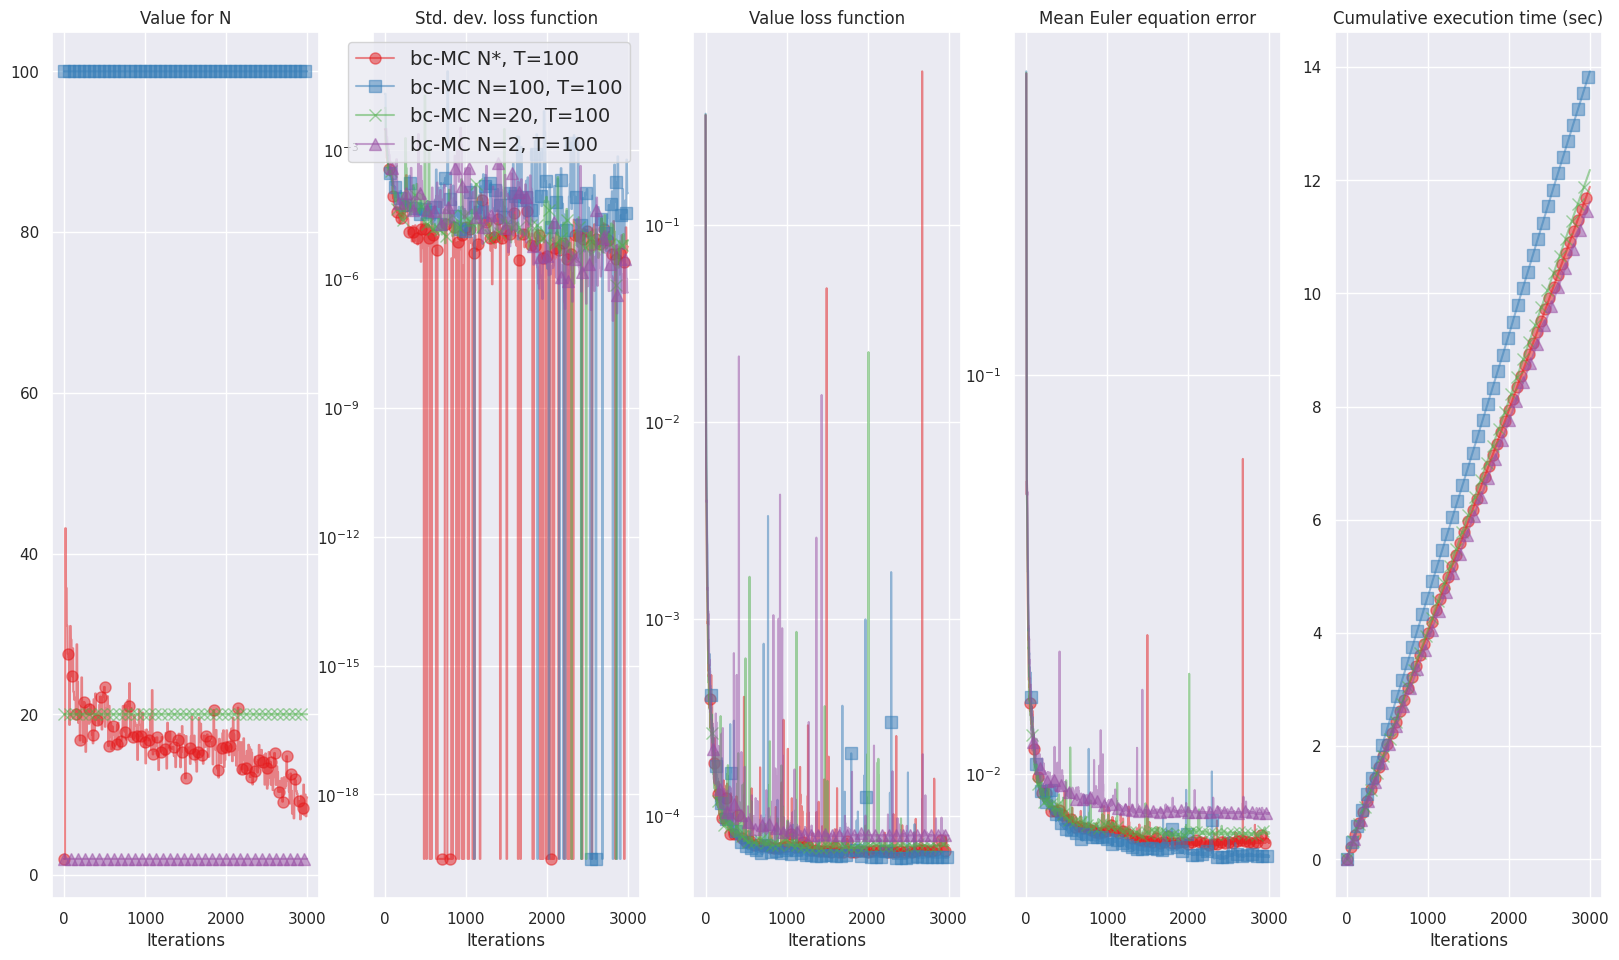

nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.05
σ_e: 0.05
optimizer: Adam
Initial guess: [2.0, 2.0]
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<19:51, 12.04s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:25<21:11, 12.98s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:37<20:25, 12.63s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:50<20:09, 12.59s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000015, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:04<20:32, 12.98s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:17<20:25, 13.04s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:29<19:34, 12.63s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:41<19:14, 12.55s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:53<18:55, 12.47s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:06<18:59, 12.66s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000148, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:17<18:01, 12.15s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:29<17:44, 12.10s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:42<17:51, 12.32s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:55<17:48, 12.42s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000034, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000031, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:08<18:06, 12.79s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000017, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:21<17:54, 12.79s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000069, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:34<17:44, 12.82s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:46<17:17, 12.65s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000051, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [04:00<17:28, 12.94s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:11<16:41, 12.52s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000068, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:24<16:36, 12.61s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000018, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:38<16:48, 12.93s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:50<16:20, 12.73s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [05:03<16:07, 12.73s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:15<15:49, 12.66s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:28<15:27, 12.54s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:41<15:39, 12.88s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:53<15:05, 12.58s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [06:05<14:41, 12.42s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:17<14:23, 12.33s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:29<13:58, 12.15s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000053, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:42<14:08, 12.47s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:55<14:05, 12.62s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:08<14:00, 12.73s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:21<13:45, 12.70s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:33<13:20, 12.51s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:45<12:52, 12.26s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000064, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000009, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:58<13:06, 12.68s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [08:13<13:19, 13.11s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:25<12:49, 12.82s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:36<12:16, 12.48s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:47<11:37, 12.03s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [09:00<11:32, 12.15s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [09:14<11:48, 12.65s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:26<11:24, 12.45s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:38<11:14, 12.48s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000013, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:52<11:21, 12.86s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [10:05<11:16, 13.01s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000028, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000023, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [10:19<11:11, 13.18s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000036, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:32<10:57, 13.16s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:44<10:33, 12.94s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:57<10:10, 12.73s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [11:08<09:45, 12.46s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000050, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [11:22<09:50, 12.83s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:34<09:28, 12.62s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:47<09:15, 12.62s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [12:00<09:06, 12.71s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [12:12<08:50, 12.64s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:25<08:40, 12.70s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:39<08:39, 12.98s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:52<08:35, 13.21s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000068, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000115, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [13:06<08:22, 13.21s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [13:16<07:42, 12.49s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:28<07:24, 12.34s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:41<07:18, 12.54s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:54<07:06, 12.53s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [14:08<07:04, 12.87s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [14:19<06:40, 12.52s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000014, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:33<06:38, 12.85s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:46<06:22, 12.76s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:58<06:06, 12.62s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [15:09<05:44, 12.31s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [15:22<05:31, 12.29s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:34<05:21, 12.36s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000247, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:49<05:27, 13.10s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [16:02<05:16, 13.17s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [16:15<04:58, 12.97s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [16:27<04:39, 12.70s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:39<04:21, 12.44s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:51<04:06, 12.35s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [17:03<03:54, 12.37s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [17:15<03:40, 12.26s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [17:28<03:28, 12.26s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000042, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:40<03:16, 12.29s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:51<02:59, 11.96s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000019, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [18:05<02:53, 12.40s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000051, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [18:17<02:41, 12.45s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000034, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [18:30<02:32, 12.73s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000171, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:43<02:19, 12.70s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [18:55<02:05, 12.57s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [19:08<01:53, 12.58s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [19:21<01:41, 12.65s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [19:33<01:26, 12.38s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000017, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:46<01:16, 12.73s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [19:58<01:03, 12.63s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [20:11<00:50, 12.59s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [20:23<00:37, 12.41s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [20:35<00:24, 12.42s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000023, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:49<00:12, 12.80s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000035, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [21:03<00:00, 12.64s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.204616                    -1                     -1   
2           0     2  0.143541                    -1                     -1   
3           0     3  0.095823                    -1                     -1   
4           0     4  0.058735                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000017  0.005004  
1          0.452345          2  0.000017  0.020984  
2          0.378868          2  0.000017  0.029239  
3          0.309553          2  0.000017  0.034677  
4          0.242353          2  0.000017  0.040350  
nb epochs: 3000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.05
σ_e: 0.05
optimizer: Adam
I

  0%|          | 0/100 [00:00<?, ?it/s]

N: 100 loss: 0.248682, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:14<23:21, 14.16s/it]

N: 100 loss: 0.420476, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:28<23:00, 14.09s/it]

N: 100 loss: 0.362278, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:42<22:52, 14.15s/it]

N: 100 loss: 0.456161, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000044, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:56<22:38, 14.16s/it]

N: 100 loss: 0.972487, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000329, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000053, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:10<22:20, 14.11s/it]

N: 100 loss: 0.609952, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:24<22:04, 14.09s/it]

N: 100 loss: 0.404486, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:38<21:50, 14.09s/it]

N: 100 loss: 0.581645, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:52<21:38, 14.12s/it]

N: 100 loss: 0.401968, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [02:06<21:21, 14.08s/it]

N: 100 loss: 0.282014, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:22<21:47, 14.53s/it]

N: 100 loss: 0.483488, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000146, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:36<21:18, 14.36s/it]

N: 100 loss: 0.696662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:50<20:55, 14.27s/it]

N: 100 loss: 0.220297, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [03:04<20:31, 14.16s/it]

N: 100 loss: 0.589019, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [03:18<20:12, 14.09s/it]

N: 100 loss: 0.425803, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000098, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:32<19:57, 14.09s/it]

N: 100 loss: 0.558191, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:46<19:42, 14.08s/it]

N: 100 loss: 0.349822, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000050, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000026, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [04:00<19:26, 14.06s/it]

N: 100 loss: 0.387245, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [04:14<19:09, 14.02s/it]

N: 100 loss: 0.335877, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000042, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [04:28<18:55, 14.02s/it]

N: 100 loss: 0.662327, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:42<18:40, 14.00s/it]

N: 100 loss: 0.220577, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:56<18:24, 13.98s/it]

N: 100 loss: 0.510344, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000012, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [05:10<18:08, 13.95s/it]

N: 100 loss: 0.295837, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [05:24<17:54, 13.96s/it]

N: 100 loss: 0.540944, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [05:38<17:43, 13.99s/it]

N: 100 loss: 0.398336, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:52<17:29, 13.99s/it]

N: 100 loss: 0.379170, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [06:06<17:12, 13.95s/it]

N: 100 loss: 0.229392, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [06:19<16:54, 13.90s/it]

N: 100 loss: 0.365438, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [06:33<16:38, 13.87s/it]

N: 100 loss: 0.363630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [06:47<16:26, 13.89s/it]

N: 100 loss: 0.453324, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [07:01<16:12, 13.90s/it]

N: 100 loss: 0.416755, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000131, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [07:15<15:56, 13.86s/it]

N: 100 loss: 0.534378, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [07:29<15:43, 13.88s/it]

N: 100 loss: 0.530693, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [07:43<15:31, 13.90s/it]

N: 100 loss: 1.118090, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:56<15:15, 13.87s/it]

N: 100 loss: 0.322391, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [08:10<14:58, 13.82s/it]

N: 100 loss: 1.889362, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [08:24<14:41, 13.77s/it]

N: 100 loss: 0.207583, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [08:38<14:27, 13.76s/it]

N: 100 loss: 0.569633, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [08:52<14:20, 13.87s/it]

N: 100 loss: 0.693010, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [09:06<14:08, 13.90s/it]

N: 100 loss: 0.544501, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [09:20<13:53, 13.89s/it]

N: 100 loss: 0.621430, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [09:34<13:40, 13.91s/it]

N: 100 loss: 0.629796, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [09:48<13:31, 14.00s/it]

N: 100 loss: 0.485311, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [10:03<13:42, 14.43s/it]

N: 100 loss: 0.596891, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [10:17<13:20, 14.29s/it]

N: 100 loss: 0.291771, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [10:31<13:00, 14.19s/it]

N: 100 loss: 0.209776, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000041, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [10:45<12:43, 14.15s/it]

N: 100 loss: 0.399524, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000028, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [10:59<12:26, 14.08s/it]

N: 100 loss: 0.495454, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [11:13<12:09, 14.03s/it]

N: 100 loss: 0.453223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [11:27<11:56, 14.04s/it]

N: 100 loss: 0.216828, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [11:41<11:44, 14.08s/it]

N: 100 loss: 0.561826, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [11:55<11:28, 14.05s/it]

N: 100 loss: 0.226875, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [12:09<11:13, 14.03s/it]

N: 100 loss: 0.388258, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [12:23<11:00, 14.06s/it]

N: 100 loss: 0.414661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [12:37<10:46, 14.05s/it]

N: 100 loss: 0.679266, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [12:52<10:34, 14.10s/it]

N: 100 loss: 0.849393, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [13:05<10:18, 14.05s/it]

N: 100 loss: 0.345523, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [13:19<10:03, 14.03s/it]

N: 100 loss: 0.235907, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [13:33<09:48, 14.02s/it]

N: 100 loss: 0.822469, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [13:48<09:37, 14.08s/it]

N: 100 loss: 0.351806, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [14:02<09:24, 14.11s/it]

N: 100 loss: 0.432548, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000054, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [14:16<09:09, 14.08s/it]

N: 100 loss: 0.343199, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [14:30<08:56, 14.12s/it]

N: 100 loss: 0.461383, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000012, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [14:44<08:43, 14.14s/it]

N: 100 loss: 0.568571, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [14:58<08:29, 14.15s/it]

N: 100 loss: 0.448835, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [15:13<08:15, 14.16s/it]

N: 100 loss: 0.576097, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [15:27<08:01, 14.15s/it]

N: 100 loss: 0.544630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [15:41<07:48, 14.19s/it]

N: 100 loss: 0.492632, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [15:55<07:34, 14.21s/it]

N: 100 loss: 0.572105, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [16:09<07:19, 14.18s/it]

N: 100 loss: 0.614231, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000030, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000019, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [16:24<07:06, 14.21s/it]

N: 100 loss: 0.408705, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [16:38<06:52, 14.21s/it]

N: 100 loss: 0.460451, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000052, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [16:52<06:36, 14.16s/it]

N: 100 loss: 0.685762, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [17:06<06:21, 14.12s/it]

N: 100 loss: 0.655881, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [17:20<06:05, 14.06s/it]

N: 100 loss: 0.408490, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [17:36<06:03, 14.55s/it]

N: 100 loss: 0.304024, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [17:50<05:46, 14.43s/it]

N: 100 loss: 0.643821, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [18:04<05:28, 14.29s/it]

N: 100 loss: 0.304605, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [18:18<05:12, 14.19s/it]

N: 100 loss: 0.382223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [18:32<04:56, 14.11s/it]

N: 100 loss: 0.350153, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [18:46<04:41, 14.08s/it]

N: 100 loss: 0.420951, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [19:00<04:27, 14.10s/it]

N: 100 loss: 0.204643, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000822, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [19:14<04:12, 14.04s/it]

N: 100 loss: 0.499147, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [19:28<03:58, 14.05s/it]

N: 100 loss: 0.363667, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [19:42<03:44, 14.05s/it]

N: 100 loss: 0.378662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [19:56<03:31, 14.08s/it]

N: 100 loss: 0.569345, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [20:10<03:17, 14.08s/it]

N: 100 loss: 0.577437, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000052, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [20:24<03:02, 14.05s/it]

N: 100 loss: 0.306528, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000063, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000031, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [20:38<02:48, 14.06s/it]

N: 100 loss: 0.334845, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [20:52<02:34, 14.08s/it]

N: 100 loss: 0.709472, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [21:06<02:20, 14.08s/it]

N: 100 loss: 0.408035, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [21:20<02:06, 14.05s/it]

N: 100 loss: 0.719085, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [21:34<01:52, 14.08s/it]

N: 100 loss: 0.487689, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [21:48<01:38, 14.10s/it]

N: 100 loss: 0.451427, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000012, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [22:03<01:24, 14.11s/it]

N: 100 loss: 0.955420, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000042, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [22:17<01:10, 14.05s/it]

N: 100 loss: 0.487141, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [22:30<00:55, 13.96s/it]

N: 100 loss: 0.494050, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000009, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [22:44<00:41, 13.98s/it]

N: 100 loss: 0.678578, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000047, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [22:58<00:28, 14.04s/it]

N: 100 loss: 0.436585, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [23:12<00:13, 13.99s/it]

N: 100 loss: 0.494948, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [23:26<00:00, 14.07s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.248682                    -1                     -1   
1           0     1  0.199688                    -1                     -1   
2           0     2  0.129762                    -1                     -1   
3           0     3  0.097447                    -1                     -1   
4           0     4  0.039040                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.498681        100   0.00088  0.010843  
1          0.446864        100   0.00088  0.021653  
2          0.360225        100   0.00088  0.025473  
3          0.312166        100   0.00088  0.029154  
4          0.197585        100   0.00088  0.032765  
nb epochs: 3000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.05
σ_e: 0.05
optimizer: Adam


  0%|          | 0/100 [00:00<?, ?it/s]

N: 20 loss: 0.285526, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<20:29, 12.42s/it]

N: 20 loss: 0.411092, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:25<20:28, 12.54s/it]

N: 20 loss: 0.364123, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:37<20:04, 12.41s/it]

N: 20 loss: 0.473612, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:49<19:47, 12.37s/it]

N: 20 loss: 1.061327, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:02<19:39, 12.42s/it]

N: 20 loss: 0.616245, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:14<19:29, 12.44s/it]

N: 20 loss: 0.431010, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:28<20:00, 12.91s/it]

N: 20 loss: 0.573357, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:39<19:05, 12.45s/it]

N: 20 loss: 0.400381, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:52<18:42, 12.34s/it]

N: 20 loss: 0.263189, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:04<18:38, 12.43s/it]

N: 20 loss: 0.481962, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:16<18:23, 12.40s/it]

N: 20 loss: 0.688444, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:29<18:10, 12.39s/it]

N: 20 loss: 0.214307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000013, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:41<17:56, 12.37s/it]

N: 20 loss: 0.549825, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:54<17:46, 12.40s/it]

N: 20 loss: 0.417409, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000027, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:06<17:22, 12.27s/it]

N: 20 loss: 0.561821, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:17<16:54, 12.07s/it]

N: 20 loss: 0.359728, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:30<16:48, 12.15s/it]

N: 20 loss: 0.364721, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:42<16:44, 12.25s/it]

N: 20 loss: 0.359007, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:55<16:39, 12.33s/it]

N: 20 loss: 0.639543, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:07<16:26, 12.33s/it]

N: 20 loss: 0.243399, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:19<16:14, 12.34s/it]

N: 20 loss: 0.543043, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:32<16:01, 12.33s/it]

N: 20 loss: 0.294497, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000041, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:43<15:39, 12.20s/it]

N: 20 loss: 0.532436, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:56<15:29, 12.23s/it]

N: 20 loss: 0.416610, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:08<15:25, 12.34s/it]

N: 20 loss: 0.381012, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:21<15:19, 12.43s/it]

N: 20 loss: 0.254923, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000034, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:34<15:09, 12.46s/it]

N: 20 loss: 0.365263, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:46<14:55, 12.44s/it]

N: 20 loss: 0.363103, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:58<14:45, 12.47s/it]

N: 20 loss: 0.452882, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:11<14:23, 12.34s/it]

N: 20 loss: 0.418877, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000131, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:22<13:59, 12.16s/it]

N: 20 loss: 0.511751, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:35<13:53, 12.26s/it]

N: 20 loss: 0.499498, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:47<13:46, 12.33s/it]

N: 20 loss: 0.971841, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:00<13:41, 12.45s/it]

N: 20 loss: 0.320231, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:13<13:33, 12.51s/it]

N: 20 loss: 1.670661, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:25<13:20, 12.50s/it]

N: 20 loss: 0.206789, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:37<13:05, 12.46s/it]

N: 20 loss: 0.574939, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000024, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:49<12:40, 12.26s/it]

N: 20 loss: 0.694292, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000035, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [08:01<12:22, 12.17s/it]

N: 20 loss: 0.670294, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:14<12:16, 12.28s/it]

N: 20 loss: 0.624783, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:27<12:12, 12.42s/it]

N: 20 loss: 0.640795, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:39<12:02, 12.46s/it]

N: 20 loss: 0.424738, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:53<12:19, 12.97s/it]

N: 20 loss: 0.585680, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [09:06<12:04, 12.94s/it]

N: 20 loss: 0.290988, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000084, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:19<11:44, 12.80s/it]

N: 20 loss: 0.214447, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:31<11:23, 12.65s/it]

N: 20 loss: 0.380256, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000079, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:43<10:58, 12.43s/it]

N: 20 loss: 0.485695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:55<10:48, 12.48s/it]

N: 20 loss: 0.450732, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [10:08<10:36, 12.48s/it]

N: 20 loss: 0.205096, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:20<10:25, 12.50s/it]

N: 20 loss: 0.556405, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:33<10:09, 12.44s/it]

N: 20 loss: 0.231718, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:45<09:54, 12.39s/it]

N: 20 loss: 0.388695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:57<09:41, 12.38s/it]

N: 20 loss: 0.430693, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [11:10<09:28, 12.35s/it]

N: 20 loss: 0.673908, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:21<09:07, 12.16s/it]

N: 20 loss: 0.870859, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:33<08:52, 12.11s/it]

N: 20 loss: 0.357344, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:46<08:44, 12.20s/it]

N: 20 loss: 0.249105, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:58<08:36, 12.30s/it]

N: 20 loss: 0.841505, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:11<08:26, 12.35s/it]

N: 20 loss: 0.336113, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:23<08:14, 12.35s/it]

N: 20 loss: 0.437770, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000039, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:35<08:00, 12.33s/it]

N: 20 loss: 0.342713, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:47<07:39, 12.08s/it]

N: 20 loss: 0.467646, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:59<07:25, 12.03s/it]

N: 20 loss: 0.575015, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:11<07:17, 12.14s/it]

N: 20 loss: 0.471325, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:24<07:07, 12.21s/it]

N: 20 loss: 0.573774, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:36<06:56, 12.25s/it]

N: 20 loss: 0.556425, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000071, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:48<06:45, 12.29s/it]

N: 20 loss: 0.499242, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000098, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000253, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [14:01<06:36, 12.39s/it]

N: 20 loss: 0.569666, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:13<06:18, 12.21s/it]

N: 20 loss: 0.617082, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:24<06:02, 12.07s/it]

N: 20 loss: 0.407892, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:37<05:53, 12.19s/it]

N: 20 loss: 0.461091, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:49<05:44, 12.30s/it]

N: 20 loss: 0.685481, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000047, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [15:02<05:34, 12.38s/it]

N: 20 loss: 0.662758, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:15<05:23, 12.45s/it]

N: 20 loss: 0.418911, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:27<05:11, 12.47s/it]

N: 20 loss: 0.306046, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [15:39<04:57, 12.40s/it]

N: 20 loss: 0.639320, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:51<04:41, 12.23s/it]

N: 20 loss: 0.313651, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [16:04<04:32, 12.37s/it]

N: 20 loss: 0.405830, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:16<04:20, 12.41s/it]

N: 20 loss: 0.351630, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:31<04:18, 12.93s/it]

N: 20 loss: 0.422523, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [16:43<04:03, 12.82s/it]

N: 20 loss: 0.203392, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:56<03:49, 12.78s/it]

N: 20 loss: 0.490705, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [17:09<03:37, 12.82s/it]

N: 20 loss: 0.357613, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:21<03:24, 12.77s/it]

N: 20 loss: 0.385200, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:33<03:07, 12.51s/it]

N: 20 loss: 0.568992, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [17:45<02:52, 12.32s/it]

N: 20 loss: 0.601128, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000053, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000063, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:58<02:40, 12.35s/it]

N: 20 loss: 0.311414, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [18:10<02:28, 12.37s/it]

N: 20 loss: 0.352369, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:22<02:15, 12.35s/it]

N: 20 loss: 0.686711, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [18:35<02:03, 12.32s/it]

N: 20 loss: 0.406723, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [18:47<01:50, 12.32s/it]

N: 20 loss: 0.719014, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [18:59<01:37, 12.14s/it]

N: 20 loss: 0.492243, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [19:11<01:24, 12.11s/it]

N: 20 loss: 0.448590, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000024, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:23<01:13, 12.20s/it]

N: 20 loss: 0.971316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [19:35<01:01, 12.26s/it]

N: 20 loss: 0.490840, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [19:48<00:49, 12.31s/it]

N: 20 loss: 0.493514, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [20:00<00:37, 12.39s/it]

N: 20 loss: 0.699975, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [20:13<00:24, 12.41s/it]

N: 20 loss: 0.440561, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:25<00:12, 12.35s/it]

N: 20 loss: 0.496467, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000042, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [20:37<00:00, 12.37s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.285526                    -1                     -1   
1           0     1  0.192487                    -1                     -1   
2           0     2  0.142374                    -1                     -1   
3           0     3  0.099047                    -1                     -1   
4           0     4  0.046673                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.534347         20  0.000171  0.008481  
1          0.438733         20  0.000171  0.024681  
2          0.377325         20  0.000171  0.036847  
3          0.314717         20  0.000171  0.041410  
4          0.216039         20  0.000171  0.051339  
nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.05
σ_e: 0.05
optimizer: Adam

  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<20:10, 12.23s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:24<19:50, 12.15s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:36<19:26, 12.02s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000120, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:48<19:15, 12.03s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [00:59<18:46, 11.86s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:11<18:16, 11.67s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:23<18:18, 11.81s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.002210, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:35<18:11, 11.87s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:47<18:02, 11.90s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [01:58<17:48, 11.87s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000148, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:10<17:23, 11.72s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:21<17:05, 11.66s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000188, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:33<17:04, 11.77s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:45<16:56, 11.81s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [02:59<17:27, 12.32s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000047, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:11<17:07, 12.23s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000127, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:22<16:39, 12.04s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:34<16:26, 12.04s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:46<16:14, 12.03s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [03:58<16:02, 12.03s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000056, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000137, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:11<15:53, 12.07s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000093, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:23<15:40, 12.06s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:34<15:10, 11.83s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:46<14:54, 11.77s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [04:58<14:50, 11.87s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:10<14:48, 12.01s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000807, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:22<14:37, 12.01s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:34<14:16, 11.90s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:45<13:41, 11.58s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [05:56<13:33, 11.62s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:08<13:27, 11.70s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000005, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:20<13:21, 11.78s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000064, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:32<13:11, 11.81s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [06:43<12:48, 11.65s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [06:54<12:28, 11.51s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:06<12:24, 11.63s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:18<12:17, 11.70s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:30<12:07, 11.74s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000028, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [07:42<11:54, 11.72s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [07:53<11:29, 11.49s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:04<11:22, 11.57s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:16<11:18, 11.70s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:28<11:10, 11.76s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000919, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [08:40<11:01, 11.81s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000078, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [08:52<10:40, 11.65s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:03<10:26, 11.61s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000054, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:15<10:22, 11.74s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000544, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:27<10:13, 11.81s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [09:39<10:06, 11.89s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000035, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [09:51<09:54, 11.88s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:02<09:33, 11.70s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:14<09:28, 11.84s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000293, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:27<09:29, 12.13s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000050, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [10:39<09:13, 12.04s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [10:51<08:58, 11.97s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:02<08:41, 11.84s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:14<08:20, 11.65s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:25<08:11, 11.71s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [11:37<08:03, 11.78s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [11:49<07:51, 11.78s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000050, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000173, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:01<07:39, 11.78s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:12<07:22, 11.64s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:24<07:08, 11.57s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [12:36<06:59, 11.65s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000074, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [12:47<06:48, 11.68s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000012, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [12:59<06:38, 11.72s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000154, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000233, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:11<06:27, 11.74s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [13:22<06:08, 11.52s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000120, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [13:34<06:00, 11.61s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [13:46<05:50, 11.70s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [13:57<05:40, 11.74s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:09<05:29, 11.76s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [14:20<05:13, 11.60s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [14:32<04:59, 11.52s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [14:44<04:50, 11.63s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [14:56<04:40, 11.70s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:08<04:31, 11.79s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [15:19<04:19, 11.81s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [15:30<04:03, 11.58s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [15:42<03:52, 11.62s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [15:54<03:41, 11.67s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:06<03:31, 11.74s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [16:18<03:21, 11.83s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000007, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [16:29<03:06, 11.68s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [16:40<02:52, 11.50s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [16:52<02:42, 11.57s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:04<02:31, 11.68s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [17:16<02:21, 11.78s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [17:28<02:09, 11.81s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [17:41<02:01, 12.14s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [17:52<01:46, 11.80s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000038, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [18:04<01:34, 11.82s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [18:16<01:23, 11.87s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000139, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [18:27<01:11, 11.85s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [18:39<00:58, 11.78s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [18:50<00:45, 11.48s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [19:02<00:34, 11.55s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [19:13<00:23, 11.66s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [19:25<00:11, 11.67s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000064, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [19:37<00:00, 11.77s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.204616                    -1                     -1   
2           0     2  0.143541                    -1                     -1   
3           0     3  0.095823                    -1                     -1   
4           0     4  0.058735                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000017  0.006464  
1          0.452345          2  0.000017  0.018865  
2          0.378868          2  0.000017  0.023216  
3          0.309553          2  0.000017  0.026635  
4          0.242353          2  0.000017  0.029717  
   sigma_e  alpha   beta optim    lr    N    M    T  N_star
4     0.05  0.995  0.995  Adam  0.05    2  100  100    True
5     0.05  0.995  0.995  Adam  0.05  100    2  100   False
6     0.05  0.995  0.995  Adam  0

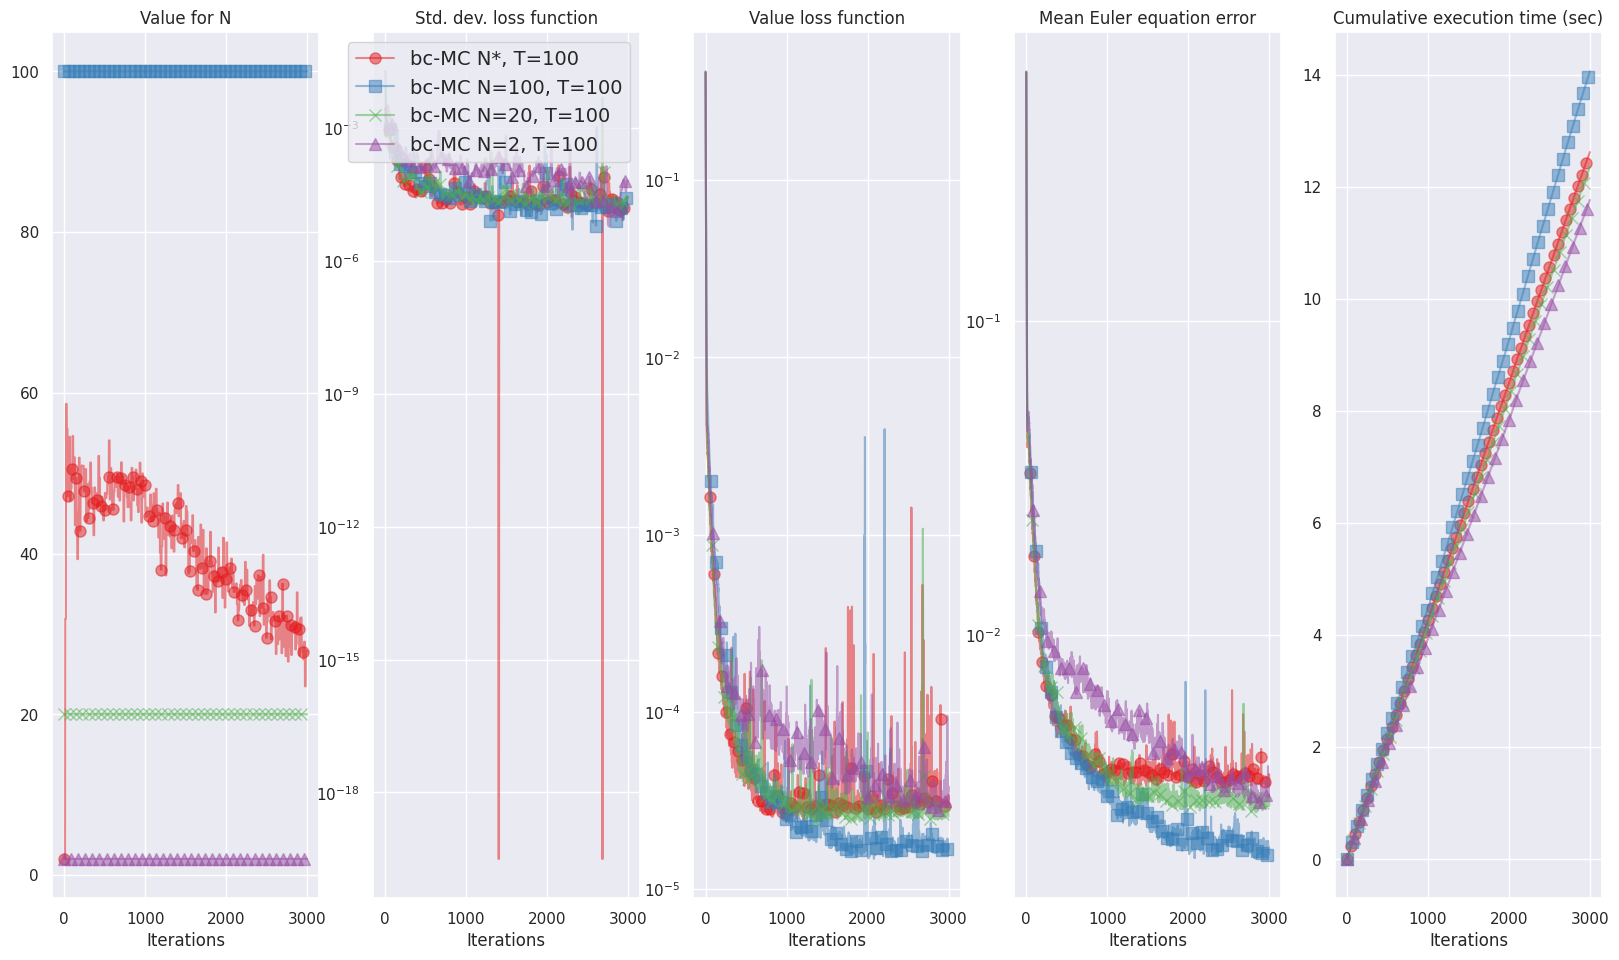

nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.01
σ_e: 0.05
optimizer: Adam
Initial guess: [2.0, 2.0]
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000120, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000120, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<20:41, 12.54s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000239, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:24<20:24, 12.49s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:37<20:06, 12.44s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:49<19:40, 12.30s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:01<19:18, 12.19s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:13<19:16, 12.30s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:26<19:10, 12.37s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000126, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:38<19:00, 12.40s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:51<18:51, 12.44s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:03<18:36, 12.41s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:16<18:29, 12.47s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:28<17:56, 12.24s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:39<17:29, 12.07s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:52<17:21, 12.12s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:04<17:17, 12.20s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:17<17:14, 12.32s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:29<17:01, 12.31s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:41<16:48, 12.30s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:53<16:23, 12.14s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000057, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:05<16:03, 12.05s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:17<15:58, 12.13s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:29<15:53, 12.22s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:42<15:47, 12.31s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000073, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:55<16:01, 12.65s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:09<16:02, 12.84s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:21<15:32, 12.60s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:33<15:05, 12.40s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:45<14:50, 12.37s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:57<14:40, 12.40s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:10<14:27, 12.39s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000055, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:23<14:34, 12.67s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:35<14:15, 12.59s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000021, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:48<13:58, 12.52s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000019, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:00<13:41, 12.45s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:12<13:17, 12.27s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:24<12:58, 12.17s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:36<12:53, 12.29s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:49<12:43, 12.31s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000124, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [08:01<12:27, 12.25s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:13<12:16, 12.28s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:25<12:02, 12.24s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:37<11:39, 12.07s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:49<11:28, 12.07s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [09:01<11:18, 12.12s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:14<11:13, 12.24s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:26<11:05, 12.33s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:39<11:01, 12.48s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:52<10:53, 12.56s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [10:04<10:34, 12.45s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:16<10:16, 12.34s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:29<10:10, 12.45s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:42<09:57, 12.45s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:54<09:46, 12.48s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [11:07<09:34, 12.48s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:19<09:26, 12.59s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:33<09:24, 12.83s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000042, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000019, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:48<09:38, 13.46s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [12:01<09:29, 13.56s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:16<09:22, 13.71s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000048, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:28<08:50, 13.27s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:40<08:21, 12.87s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:52<07:57, 12.57s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [13:04<07:48, 12.66s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:17<07:34, 12.62s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:30<07:20, 12.58s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000035, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:42<07:07, 12.58s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:54<06:53, 12.52s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [14:07<06:39, 12.48s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:19<06:25, 12.44s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:31<06:07, 12.26s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000066, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:43<05:55, 12.25s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:56<05:44, 12.32s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000167, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [15:08<05:33, 12.35s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:20<05:20, 12.34s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:33<05:08, 12.34s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [15:45<04:51, 12.15s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000109, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:56<04:34, 11.95s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000247, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [16:08<04:25, 12.08s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:21<04:17, 12.24s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:33<04:05, 12.25s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [16:45<03:52, 12.22s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:58<03:40, 12.25s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [17:10<03:27, 12.18s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:21<03:12, 12.04s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000045, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:34<03:02, 12.20s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000391, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [17:47<02:52, 12.31s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:59<02:40, 12.37s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [18:12<02:30, 12.55s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:25<02:17, 12.54s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [18:37<02:04, 12.47s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [18:49<01:50, 12.26s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [19:01<01:37, 12.19s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [19:14<01:28, 12.63s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:27<01:16, 12.69s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [19:40<01:02, 12.59s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000070, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [19:52<00:50, 12.56s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [20:04<00:37, 12.50s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000068, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [20:18<00:25, 12.92s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:31<00:12, 12.91s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [20:43<00:00, 12.44s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.268970                    -1                     -1   
2           0     2  0.250841                    -1                     -1   
3           0     3  0.233821                    -1                     -1   
4           0     4  0.218063                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000016  0.006121  
1          0.518623          2  0.000016  0.017910  
2          0.500840          2  0.000016  0.021948  
3          0.483551          2  0.000016  0.025330  
4          0.466972          2  0.000016  0.028688  
nb epochs: 3000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.01
σ_e: 0.05
optimizer: Adam
I

  0%|          | 0/100 [00:00<?, ?it/s]

N: 100 loss: 0.248682, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000129, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:14<23:34, 14.29s/it]

N: 100 loss: 0.420476, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:28<23:07, 14.16s/it]

N: 100 loss: 0.362278, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:42<22:50, 14.13s/it]

N: 100 loss: 0.456161, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000470, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000168, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:56<22:38, 14.15s/it]

N: 100 loss: 0.972487, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:10<22:25, 14.17s/it]

N: 100 loss: 0.609952, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:25<22:16, 14.22s/it]

N: 100 loss: 0.404486, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000056, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:39<21:59, 14.19s/it]

N: 100 loss: 0.581645, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:53<21:37, 14.10s/it]

N: 100 loss: 0.401968, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000032, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [02:07<21:35, 14.24s/it]

N: 100 loss: 0.282014, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:22<21:29, 14.33s/it]

N: 100 loss: 0.483488, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.003388, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:36<20:59, 14.15s/it]

N: 100 loss: 0.696662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000036, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:49<20:33, 14.02s/it]

N: 100 loss: 0.220297, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [03:03<20:11, 13.92s/it]

N: 100 loss: 0.589019, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000064, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [03:17<19:59, 13.95s/it]

N: 100 loss: 0.425803, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:31<19:52, 14.03s/it]

N: 100 loss: 0.558191, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000120, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:46<19:49, 14.16s/it]

N: 100 loss: 0.349822, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [04:00<19:39, 14.21s/it]

N: 100 loss: 0.387245, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000045, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [04:14<19:20, 14.15s/it]

N: 100 loss: 0.335877, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [04:28<19:07, 14.16s/it]

N: 100 loss: 0.662327, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:42<18:47, 14.10s/it]

N: 100 loss: 0.220577, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:56<18:34, 14.11s/it]

N: 100 loss: 0.510344, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [05:10<18:16, 14.06s/it]

N: 100 loss: 0.295837, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [05:26<18:45, 14.62s/it]

N: 100 loss: 0.540944, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000019, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [05:40<18:16, 14.43s/it]

N: 100 loss: 0.398336, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:54<17:53, 14.31s/it]

N: 100 loss: 0.379170, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [06:08<17:39, 14.32s/it]

N: 100 loss: 0.229392, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [06:23<17:23, 14.29s/it]

N: 100 loss: 0.365438, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [06:37<17:03, 14.22s/it]

N: 100 loss: 0.363630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000130, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [06:51<16:46, 14.18s/it]

N: 100 loss: 0.453324, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [07:05<16:24, 14.06s/it]

N: 100 loss: 0.416755, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.003098, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000732, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [07:19<16:11, 14.09s/it]

N: 100 loss: 0.534378, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [07:33<15:59, 14.12s/it]

N: 100 loss: 0.530693, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [07:47<15:43, 14.08s/it]

N: 100 loss: 1.118090, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [08:01<15:28, 14.07s/it]

N: 100 loss: 0.322391, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [08:15<15:17, 14.11s/it]

N: 100 loss: 1.889362, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000534, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [08:29<15:03, 14.12s/it]

N: 100 loss: 0.207583, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [08:44<14:52, 14.16s/it]

N: 100 loss: 0.569633, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000021, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [08:58<14:35, 14.13s/it]

N: 100 loss: 0.693010, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000316, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000016, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [09:12<14:21, 14.12s/it]

N: 100 loss: 0.544501, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [09:26<14:11, 14.19s/it]

N: 100 loss: 0.621430, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [09:40<13:57, 14.20s/it]

N: 100 loss: 0.629796, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [09:54<13:42, 14.18s/it]

N: 100 loss: 0.485311, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000255, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000036, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [10:09<13:29, 14.20s/it]

N: 100 loss: 0.596891, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [10:23<13:18, 14.25s/it]

N: 100 loss: 0.291771, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [10:37<13:00, 14.19s/it]

N: 100 loss: 0.209776, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [10:51<12:43, 14.15s/it]

N: 100 loss: 0.399524, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [11:05<12:28, 14.12s/it]

N: 100 loss: 0.495454, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [11:20<12:18, 14.20s/it]

N: 100 loss: 0.453223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [11:34<12:07, 14.27s/it]

N: 100 loss: 0.216828, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [11:48<11:53, 14.28s/it]

N: 100 loss: 0.561826, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000213, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [12:03<11:38, 14.25s/it]

N: 100 loss: 0.226875, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [12:17<11:23, 14.24s/it]

N: 100 loss: 0.388258, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [12:33<11:34, 14.77s/it]

N: 100 loss: 0.414661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [12:47<11:11, 14.60s/it]

N: 100 loss: 0.679266, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000492, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000024, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [13:01<10:50, 14.46s/it]

N: 100 loss: 0.849393, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [13:15<10:29, 14.31s/it]

N: 100 loss: 0.345523, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000065, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [13:29<10:14, 14.28s/it]

N: 100 loss: 0.235907, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [13:43<09:56, 14.19s/it]

N: 100 loss: 0.822469, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [13:58<09:45, 14.29s/it]

N: 100 loss: 0.351806, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000073, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000098, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [14:12<09:33, 14.34s/it]

N: 100 loss: 0.432548, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [14:27<09:21, 14.40s/it]

N: 100 loss: 0.343199, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000067, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [14:41<09:03, 14.30s/it]

N: 100 loss: 0.461383, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000034, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [14:55<08:45, 14.19s/it]

N: 100 loss: 0.568571, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000085, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [15:09<08:27, 14.09s/it]

N: 100 loss: 0.448835, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000101, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [15:23<08:13, 14.11s/it]

N: 100 loss: 0.576097, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [15:37<07:59, 14.09s/it]

N: 100 loss: 0.544630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000052, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [15:51<07:43, 14.04s/it]

N: 100 loss: 0.492632, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [16:05<07:28, 14.03s/it]

N: 100 loss: 0.572105, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000053, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [16:19<07:17, 14.11s/it]

N: 100 loss: 0.614231, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [16:33<07:02, 14.10s/it]

N: 100 loss: 0.408705, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000130, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [16:47<06:49, 14.11s/it]

N: 100 loss: 0.460451, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [17:01<06:35, 14.11s/it]

N: 100 loss: 0.685762, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [17:16<06:22, 14.17s/it]

N: 100 loss: 0.655881, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000092, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [17:30<06:07, 14.13s/it]

N: 100 loss: 0.408490, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [17:44<05:52, 14.11s/it]

N: 100 loss: 0.304024, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [17:58<05:38, 14.09s/it]

N: 100 loss: 0.643821, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000747, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000200, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [18:12<05:25, 14.17s/it]

N: 100 loss: 0.304605, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [18:26<05:12, 14.21s/it]

N: 100 loss: 0.382223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [18:41<04:57, 14.19s/it]

N: 100 loss: 0.350153, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000049, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [18:55<04:43, 14.19s/it]

N: 100 loss: 0.420951, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [19:09<04:31, 14.31s/it]

N: 100 loss: 0.204643, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [19:26<04:29, 14.97s/it]

N: 100 loss: 0.499147, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [19:40<04:11, 14.81s/it]

N: 100 loss: 0.363667, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000049, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [19:55<03:55, 14.74s/it]

N: 100 loss: 0.378662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [20:09<03:38, 14.54s/it]

N: 100 loss: 0.569345, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [20:23<03:23, 14.52s/it]

N: 100 loss: 0.577437, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [20:38<03:08, 14.52s/it]

N: 100 loss: 0.306528, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [20:52<02:52, 14.40s/it]

N: 100 loss: 0.334845, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [21:06<02:37, 14.28s/it]

N: 100 loss: 0.709472, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [21:20<02:22, 14.29s/it]

N: 100 loss: 0.408035, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000065, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [21:35<02:09, 14.39s/it]

N: 100 loss: 0.719085, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000051, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [21:49<01:55, 14.39s/it]

N: 100 loss: 0.487689, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [22:03<01:39, 14.26s/it]

N: 100 loss: 0.451427, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [22:18<01:25, 14.25s/it]

N: 100 loss: 0.955420, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000159, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000017, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [22:32<01:11, 14.23s/it]

N: 100 loss: 0.487141, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000168, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [22:46<00:56, 14.20s/it]

N: 100 loss: 0.494050, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000329, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [23:00<00:42, 14.11s/it]

N: 100 loss: 0.678578, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [23:14<00:28, 14.10s/it]

N: 100 loss: 0.436585, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000029, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [23:28<00:14, 14.10s/it]

N: 100 loss: 0.494948, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [23:42<00:00, 14.22s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.248682                    -1                     -1   
1           0     1  0.267150                    -1                     -1   
2           0     2  0.237272                    -1                     -1   
3           0     3  0.238182                    -1                     -1   
4           0     4  0.187698                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.498681        100  0.000793  0.009659  
1          0.516866        100  0.000793  0.029318  
2          0.487106        100  0.000793  0.035034  
3          0.488039        100  0.000793  0.040598  
4          0.433242        100  0.000793  0.046138  
nb epochs: 3000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.01
σ_e: 0.05
optimizer: Adam


  0%|          | 0/100 [00:00<?, ?it/s]

N: 20 loss: 0.285526, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<21:08, 12.81s/it]

N: 20 loss: 0.411092, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:25<21:00, 12.86s/it]

N: 20 loss: 0.364123, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:38<20:36, 12.75s/it]

N: 20 loss: 0.473612, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:50<20:12, 12.63s/it]

N: 20 loss: 1.061327, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000055, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:03<19:59, 12.62s/it]

N: 20 loss: 0.616245, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000127, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:16<19:46, 12.63s/it]

N: 20 loss: 0.431010, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000204, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:28<19:43, 12.73s/it]

N: 20 loss: 0.573357, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:41<19:16, 12.58s/it]

N: 20 loss: 0.400381, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:53<18:53, 12.45s/it]

N: 20 loss: 0.263189, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:06<18:57, 12.64s/it]

N: 20 loss: 0.481962, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:21<19:40, 13.26s/it]

N: 20 loss: 0.688444, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000008, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:34<19:29, 13.29s/it]

N: 20 loss: 0.214307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:47<19:16, 13.29s/it]

N: 20 loss: 0.549825, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000179, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [03:01<19:04, 13.31s/it]

N: 20 loss: 0.417409, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:14<18:46, 13.26s/it]

N: 20 loss: 0.561821, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:27<18:28, 13.19s/it]

N: 20 loss: 0.359728, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:40<18:09, 13.13s/it]

N: 20 loss: 0.364721, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:53<17:53, 13.09s/it]

N: 20 loss: 0.359007, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [04:06<17:42, 13.12s/it]

N: 20 loss: 0.639543, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:19<17:25, 13.07s/it]

N: 20 loss: 0.243399, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:31<17:00, 12.92s/it]

N: 20 loss: 0.543043, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:44<16:32, 12.72s/it]

N: 20 loss: 0.294497, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:56<16:16, 12.69s/it]

N: 20 loss: 0.532436, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [05:09<16:07, 12.73s/it]

N: 20 loss: 0.416610, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:22<16:06, 12.89s/it]

N: 20 loss: 0.381012, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:35<15:50, 12.85s/it]

N: 20 loss: 0.254923, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:48<15:33, 12.79s/it]

N: 20 loss: 0.365263, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [06:01<15:19, 12.77s/it]

N: 20 loss: 0.363103, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [06:13<15:01, 12.70s/it]

N: 20 loss: 0.452882, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:25<14:41, 12.59s/it]

N: 20 loss: 0.418877, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:38<14:19, 12.45s/it]

N: 20 loss: 0.511751, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:50<14:02, 12.39s/it]

N: 20 loss: 0.499498, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [07:02<13:51, 12.41s/it]

N: 20 loss: 0.971841, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:15<13:36, 12.37s/it]

N: 20 loss: 0.320231, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:27<13:24, 12.38s/it]

N: 20 loss: 1.670661, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000453, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:39<13:10, 12.35s/it]

N: 20 loss: 0.206789, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:51<12:53, 12.28s/it]

N: 20 loss: 0.574939, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [08:03<12:35, 12.19s/it]

N: 20 loss: 0.694292, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000484, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000083, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [08:16<12:30, 12.30s/it]

N: 20 loss: 0.670294, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:29<12:24, 12.41s/it]

N: 20 loss: 0.624783, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000058, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:41<12:14, 12.45s/it]

N: 20 loss: 0.640795, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:53<12:00, 12.43s/it]

N: 20 loss: 0.424738, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [09:07<12:09, 12.80s/it]

N: 20 loss: 0.585680, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [09:20<12:05, 12.96s/it]

N: 20 loss: 0.290988, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:33<11:46, 12.85s/it]

N: 20 loss: 0.214447, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:46<11:28, 12.75s/it]

N: 20 loss: 0.380256, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:57<10:54, 12.36s/it]

N: 20 loss: 0.485695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [10:09<10:35, 12.21s/it]

N: 20 loss: 0.450732, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [10:21<10:27, 12.30s/it]

N: 20 loss: 0.205096, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:34<10:16, 12.34s/it]

N: 20 loss: 0.556405, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000149, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:46<10:08, 12.43s/it]

N: 20 loss: 0.231718, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:59<09:59, 12.48s/it]

N: 20 loss: 0.388695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [11:11<09:44, 12.44s/it]

N: 20 loss: 0.430693, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [11:23<09:27, 12.33s/it]

N: 20 loss: 0.673908, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:35<09:06, 12.15s/it]

N: 20 loss: 0.870859, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:47<08:55, 12.17s/it]

N: 20 loss: 0.357344, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [12:00<08:49, 12.31s/it]

N: 20 loss: 0.249105, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [12:13<08:39, 12.36s/it]

N: 20 loss: 0.841505, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000012, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:25<08:28, 12.40s/it]

N: 20 loss: 0.336113, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:37<08:15, 12.39s/it]

N: 20 loss: 0.437770, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:50<08:01, 12.33s/it]

N: 20 loss: 0.342713, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [13:01<07:41, 12.16s/it]

N: 20 loss: 0.467646, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000059, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [13:14<07:30, 12.18s/it]

N: 20 loss: 0.575015, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000280, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:26<07:24, 12.34s/it]

N: 20 loss: 0.471325, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:39<07:12, 12.35s/it]

N: 20 loss: 0.573774, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:51<06:59, 12.33s/it]

N: 20 loss: 0.556425, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000092, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [14:03<06:46, 12.31s/it]

N: 20 loss: 0.499242, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [14:16<06:35, 12.35s/it]

N: 20 loss: 0.569666, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:28<06:19, 12.23s/it]

N: 20 loss: 0.617082, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:40<06:06, 12.21s/it]

N: 20 loss: 0.407892, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:52<05:56, 12.29s/it]

N: 20 loss: 0.461091, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [15:05<05:44, 12.29s/it]

N: 20 loss: 0.685481, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000095, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000062, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [15:17<05:31, 12.29s/it]

N: 20 loss: 0.662758, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:29<05:20, 12.33s/it]

N: 20 loss: 0.418911, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:42<05:07, 12.30s/it]

N: 20 loss: 0.306046, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [15:55<05:01, 12.57s/it]

N: 20 loss: 0.639320, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000007, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [16:07<04:43, 12.34s/it]

N: 20 loss: 0.313651, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [16:19<04:34, 12.47s/it]

N: 20 loss: 0.405830, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000055, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:32<04:20, 12.41s/it]

N: 20 loss: 0.351630, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:44<04:07, 12.40s/it]

N: 20 loss: 0.422523, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [16:56<03:55, 12.40s/it]

N: 20 loss: 0.203392, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [17:09<03:42, 12.38s/it]

N: 20 loss: 0.490705, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000052, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [17:21<03:28, 12.27s/it]

N: 20 loss: 0.357613, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:32<03:13, 12.10s/it]

N: 20 loss: 0.385200, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:45<03:01, 12.13s/it]

N: 20 loss: 0.568992, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [17:57<02:50, 12.20s/it]

N: 20 loss: 0.601128, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [18:09<02:39, 12.26s/it]

N: 20 loss: 0.311414, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [18:22<02:27, 12.28s/it]

N: 20 loss: 0.352369, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:34<02:15, 12.31s/it]

N: 20 loss: 0.686711, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [18:46<02:02, 12.28s/it]

N: 20 loss: 0.406723, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [18:58<01:48, 12.07s/it]

N: 20 loss: 0.719014, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [19:10<01:36, 12.12s/it]

N: 20 loss: 0.492243, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [19:23<01:25, 12.22s/it]

N: 20 loss: 0.448590, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:35<01:13, 12.28s/it]

N: 20 loss: 0.971316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [19:47<01:01, 12.30s/it]

N: 20 loss: 0.490840, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [20:00<00:49, 12.33s/it]

N: 20 loss: 0.493514, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [20:12<00:36, 12.27s/it]

N: 20 loss: 0.699975, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [20:24<00:24, 12.15s/it]

N: 20 loss: 0.440561, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:36<00:12, 12.13s/it]

N: 20 loss: 0.496467, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [20:48<00:00, 12.49s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.285526                    -1                     -1   
1           0     1  0.260974                    -1                     -1   
2           0     2  0.251140                    -1                     -1   
3           0     3  0.237827                    -1                     -1   
4           0     4  0.202322                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.534347         20  0.000156  0.007500  
1          0.510856         20  0.000156  0.024241  
2          0.501139         20  0.000156  0.033174  
3          0.487675         20  0.000156  0.037400  
4          0.449802         20  0.000156  0.046003  
nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.01
σ_e: 0.05
optimizer: Adam

  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000087, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<19:58, 12.11s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:24<19:49, 12.14s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:36<19:25, 12.02s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:47<18:39, 11.66s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000029, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [00:58<18:30, 11.69s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000085, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:10<18:27, 11.78s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000034, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:23<18:27, 11.91s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:36<19:09, 12.50s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:48<18:33, 12.23s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [01:59<17:50, 11.90s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:11<17:39, 11.90s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000047, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:23<17:23, 11.86s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:35<17:09, 11.83s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:46<16:53, 11.78s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [02:57<16:24, 11.59s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:09<16:12, 11.57s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:21<16:14, 11.74s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:33<16:03, 11.75s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:45<15:55, 11.79s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000174, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [03:56<15:36, 11.71s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000167, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:07<15:10, 11.52s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:20<15:13, 11.72s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:31<15:05, 11.76s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000074, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:43<14:53, 11.75s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000034, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [04:55<14:42, 11.77s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:06<14:13, 11.53s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:17<13:58, 11.49s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000056, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:29<13:54, 11.59s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:41<13:50, 11.70s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [05:53<13:40, 11.73s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000295, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:04<13:24, 11.65s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000029, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:15<12:56, 11.42s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:27<12:51, 11.51s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [06:39<12:43, 11.57s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [06:50<12:34, 11.60s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000134, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:02<12:26, 11.66s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:13<12:03, 11.48s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000009, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:25<11:56, 11.55s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000328, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [07:37<11:49, 11.63s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [07:48<11:40, 11.67s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000045, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000029, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:00<11:31, 11.72s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:14<11:49, 12.23s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000097, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:25<11:20, 11.93s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [08:37<11:01, 11.82s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [08:49<10:52, 11.87s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000044, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000009, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:00<10:39, 11.84s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000035, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000032, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:12<10:28, 11.86s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000102, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:24<10:18, 11.89s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000040, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [09:35<09:57, 11.72s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000056, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [09:47<09:48, 11.76s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000210, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [09:59<09:38, 11.81s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:11<09:27, 11.83s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000306, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:23<09:19, 11.89s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [10:35<09:02, 11.79s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000053, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [10:46<08:41, 11.59s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [10:58<08:35, 11.71s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:10<08:26, 11.77s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:22<08:17, 11.86s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000089, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000020, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [11:34<08:06, 11.88s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [11:46<08:02, 12.05s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [11:57<07:38, 11.75s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:09<07:28, 11.80s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:21<07:21, 11.93s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000149, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [12:33<07:09, 11.94s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [12:45<06:56, 11.89s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000007, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [12:56<06:39, 11.74s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:08<06:22, 11.58s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000025, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [13:20<06:15, 11.73s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [13:32<06:06, 11.83s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [13:44<05:56, 11.87s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000196, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [13:56<05:46, 11.95s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:08<05:31, 11.83s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000163, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [14:19<05:16, 11.72s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000115, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000021, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [14:31<05:08, 11.88s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [14:44<05:00, 12.00s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [14:56<04:49, 12.06s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000328, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000052, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:08<04:38, 12.12s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [15:22<04:37, 12.63s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [15:33<04:17, 12.24s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [15:45<03:59, 11.99s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000116, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [15:56<03:47, 11.98s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:08<03:35, 11.95s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [16:21<03:24, 12.02s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000062, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [16:33<03:12, 12.03s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000082, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [16:44<02:56, 11.78s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000128, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [16:55<02:43, 11.69s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:07<02:33, 11.79s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [17:19<02:22, 11.87s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000197, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [17:31<02:10, 11.90s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [17:43<01:58, 11.87s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [17:55<01:45, 11.73s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [18:06<01:32, 11.62s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [18:18<01:21, 11.70s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [18:30<01:10, 11.79s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [18:42<00:59, 11.82s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [18:53<00:46, 11.68s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [19:04<00:34, 11.52s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [19:16<00:23, 11.66s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [19:28<00:11, 11.75s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [19:40<00:00, 11.81s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.268970                    -1                     -1   
2           0     2  0.250841                    -1                     -1   
3           0     3  0.233821                    -1                     -1   
4           0     4  0.218063                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000016  0.007610  
1          0.518623          2  0.000016  0.019402  
2          0.500840          2  0.000016  0.023503  
3          0.483551          2  0.000016  0.027724  
4          0.466972          2  0.000016  0.031800  
    sigma_e  alpha   beta optim    lr    N    M    T  N_star
8      0.05  0.995  0.995  Adam  0.01    2  100  100    True
9      0.05  0.995  0.995  Adam  0.01  100    2  100   False
10     0.05  0.995  0.995  Ada

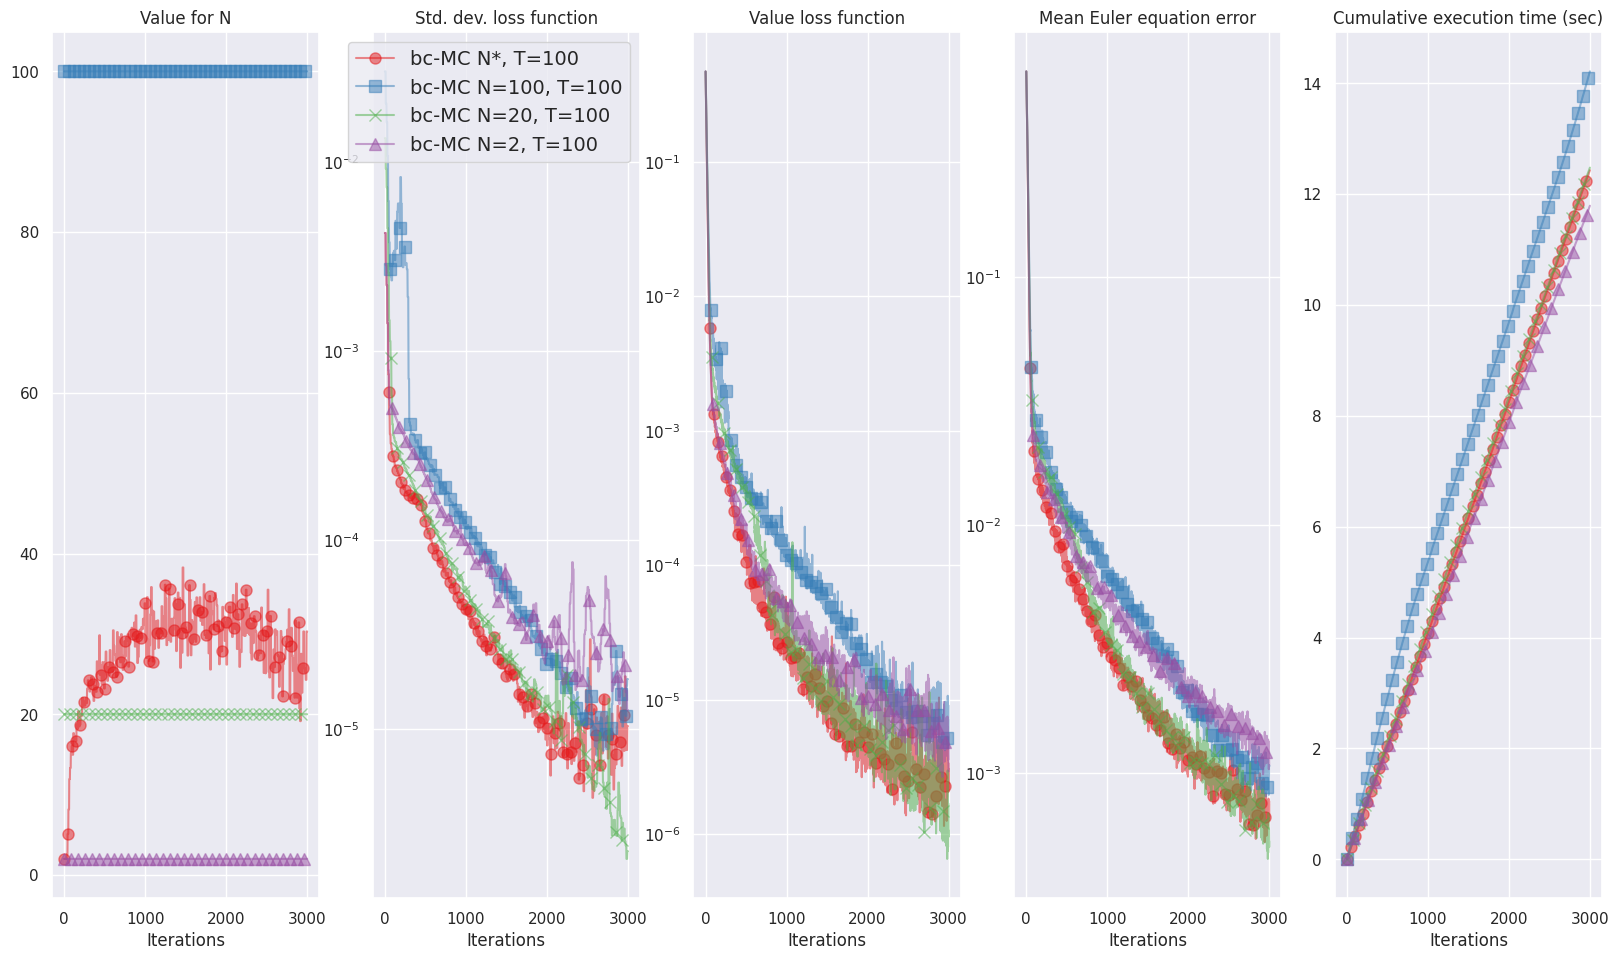

nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.005
σ_e: 0.05
optimizer: Adam
Initial guess: [2.0, 2.0]
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000470, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000039, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<20:56, 12.69s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:25<20:57, 12.83s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:38<20:40, 12.78s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000067, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:50<20:21, 12.73s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000070, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:03<20:01, 12.65s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000069, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:16<19:53, 12.70s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000024, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:28<19:30, 12.59s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:40<18:57, 12.36s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000206, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:52<18:46, 12.38s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:05<18:36, 12.41s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:18<18:33, 12.52s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:30<18:21, 12.52s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:43<18:10, 12.54s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000149, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:57<18:41, 13.05s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000008, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:10<18:19, 12.94s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:22<17:58, 12.84s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:34<17:25, 12.60s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000027, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:47<17:02, 12.47s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:59<17:01, 12.61s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:12<16:52, 12.66s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000111, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:25<16:46, 12.74s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000019, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:38<16:35, 12.77s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:51<16:25, 12.80s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [05:03<16:07, 12.73s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000028, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:16<15:44, 12.59s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000234, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:27<15:10, 12.31s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:40<15:05, 12.40s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:53<14:59, 12.49s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [06:05<14:49, 12.52s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:18<14:39, 12.57s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:31<14:34, 12.67s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:43<14:14, 12.57s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:56<13:58, 12.52s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000051, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:07<13:31, 12.29s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:20<13:25, 12.40s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:33<13:17, 12.45s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:45<13:08, 12.52s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000095, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:58<12:56, 12.52s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000343, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000101, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [08:10<12:38, 12.44s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000069, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000012, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:23<12:29, 12.48s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000082, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:35<12:19, 12.54s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:47<11:55, 12.34s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [09:00<11:46, 12.40s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [09:12<11:37, 12.45s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:25<11:31, 12.57s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:38<11:21, 12.62s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000029, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:50<11:07, 12.60s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000202, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [10:03<10:54, 12.58s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [10:15<10:40, 12.56s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:29<10:42, 12.86s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:41<10:13, 12.53s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000725, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:53<09:57, 12.44s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [11:06<09:48, 12.52s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000121, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000018, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [11:18<09:37, 12.54s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:31<09:29, 12.66s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:44<09:18, 12.68s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000017, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:58<09:22, 13.07s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [12:11<09:06, 13.02s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000022, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:23<08:44, 12.79s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:35<08:23, 12.60s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:48<08:13, 12.65s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [13:01<08:04, 12.74s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [13:14<07:53, 12.81s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000100, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000091, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:27<07:38, 12.75s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:39<07:27, 12.79s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000087, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000008, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:52<07:15, 12.80s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [14:05<07:04, 12.87s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [14:18<06:52, 12.90s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:31<06:36, 12.79s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:43<06:16, 12.55s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000068, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:55<06:03, 12.54s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [15:08<05:54, 12.65s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000254, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [15:22<05:47, 12.89s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000034, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:34<05:32, 12.77s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 8 loss: 0.000051, mean euler error -1.000000, [ 1000/ 3000]
N: 8 loss: 0.000059, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:47<05:17, 12.71s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000197, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [15:59<05:03, 12.66s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000097, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000164, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [16:11<04:48, 12.53s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000077, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [16:24<04:35, 12.52s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:37<04:23, 12.56s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:49<04:12, 12.62s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 4 loss: -0.000029, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [17:02<03:59, 12.61s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000057, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [17:15<03:47, 12.65s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000019, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [17:27<03:35, 12.68s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:40<03:22, 12.66s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000058, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000014, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:55<03:18, 13.24s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.001150, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [18:07<03:01, 12.97s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 50 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [18:20<02:46, 12.84s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [18:33<02:34, 12.91s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:45<02:21, 12.90s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [18:58<02:08, 12.89s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 10 loss: 0.000080, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [19:11<01:56, 12.95s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 10 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [19:24<01:43, 12.96s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [19:38<01:31, 13.03s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 50 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:51<01:17, 13.00s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000104, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000021, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [20:04<01:05, 13.01s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000373, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000218, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [20:17<00:52, 13.06s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000067, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000041, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [20:30<00:39, 13.13s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [20:44<00:26, 13.38s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 40 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:57<00:13, 13.25s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 40 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [21:10<00:00, 12.71s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.278499                    -1                     -1   
2           0     2  0.268951                    -1                     -1   
3           0     3  0.259661                    -1                     -1   
4           0     4  0.250082                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000015  0.041891  
1          0.527730          2  0.000015  0.062250  
2          0.518605          2  0.000015  0.069656  
3          0.509569          2  0.000015  0.076933  
4          0.500082          2  0.000015  0.083932  
nb epochs: 3000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.005
σ_e: 0.05
optimizer: Adam


  0%|          | 0/100 [00:00<?, ?it/s]

N: 100 loss: 0.248682, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000203, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:17<28:27, 17.24s/it]

N: 100 loss: 0.420476, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000192, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000040, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:32<26:22, 16.15s/it]

N: 100 loss: 0.362278, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000028, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:47<25:15, 15.62s/it]

N: 100 loss: 0.456161, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000541, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000466, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [01:02<24:38, 15.40s/it]

N: 100 loss: 0.972487, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000095, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:17<23:56, 15.12s/it]

N: 100 loss: 0.609952, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000206, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:32<23:40, 15.11s/it]

N: 100 loss: 0.404486, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000144, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000052, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:47<23:16, 15.01s/it]

N: 100 loss: 0.581645, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [02:02<23:07, 15.08s/it]

N: 100 loss: 0.401968, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000448, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [02:17<22:52, 15.08s/it]

N: 100 loss: 0.282014, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000013, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:32<22:30, 15.01s/it]

N: 100 loss: 0.483488, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:47<22:06, 14.90s/it]

N: 100 loss: 0.696662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000092, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000115, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [03:02<21:57, 14.97s/it]

N: 100 loss: 0.220297, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [03:16<21:38, 14.93s/it]

N: 100 loss: 0.589019, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000104, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000031, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [03:31<21:15, 14.83s/it]

N: 100 loss: 0.425803, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000032, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:46<20:56, 14.78s/it]

N: 100 loss: 0.558191, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000225, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000024, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [04:03<21:34, 15.41s/it]

N: 100 loss: 0.349822, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [04:17<21:00, 15.18s/it]

N: 100 loss: 0.387245, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000164, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [04:32<20:31, 15.01s/it]

N: 100 loss: 0.335877, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [04:47<20:15, 15.01s/it]

N: 100 loss: 0.662327, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [05:02<20:01, 15.01s/it]

N: 100 loss: 0.220577, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [05:17<19:47, 15.04s/it]

N: 100 loss: 0.510344, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [05:32<19:32, 15.03s/it]

N: 100 loss: 0.295837, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [05:47<19:21, 15.09s/it]

N: 100 loss: 0.540944, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [06:03<19:17, 15.22s/it]

N: 100 loss: 0.398336, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000551, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [06:18<18:58, 15.18s/it]

N: 100 loss: 0.379170, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [06:33<18:37, 15.11s/it]

N: 100 loss: 0.229392, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [06:47<18:11, 14.96s/it]

N: 100 loss: 0.365438, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000202, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [07:02<17:53, 14.91s/it]

N: 100 loss: 0.363630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000125, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [07:17<17:31, 14.81s/it]

N: 100 loss: 0.453324, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000198, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000047, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [07:31<17:11, 14.73s/it]

N: 100 loss: 0.416755, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [07:46<16:50, 14.65s/it]

N: 100 loss: 0.534378, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [08:00<16:26, 14.51s/it]

N: 100 loss: 0.530693, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000021, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [08:14<16:02, 14.37s/it]

N: 100 loss: 1.118090, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [08:28<15:42, 14.28s/it]

N: 100 loss: 0.322391, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [08:42<15:22, 14.18s/it]

N: 100 loss: 1.889362, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000932, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000050, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [08:56<15:07, 14.18s/it]

N: 100 loss: 0.207583, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [09:10<14:51, 14.15s/it]

N: 100 loss: 0.569633, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000027, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [09:24<14:35, 14.12s/it]

N: 100 loss: 0.693010, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000672, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000041, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [09:39<14:23, 14.15s/it]

N: 100 loss: 0.544501, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000211, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [09:53<14:11, 14.19s/it]

N: 100 loss: 0.621430, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000030, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [10:07<13:56, 14.19s/it]

N: 100 loss: 0.629796, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [10:21<13:43, 14.21s/it]

N: 100 loss: 0.485311, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000503, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000206, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [10:36<13:32, 14.25s/it]

N: 100 loss: 0.596891, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000154, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [10:50<13:16, 14.22s/it]

N: 100 loss: 0.291771, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000064, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [11:05<13:12, 14.40s/it]

N: 100 loss: 0.209776, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000373, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000025, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [11:21<13:34, 15.08s/it]

N: 100 loss: 0.399524, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [11:36<13:10, 14.91s/it]

N: 100 loss: 0.495454, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000226, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [11:50<12:46, 14.74s/it]

N: 100 loss: 0.453223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000069, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000013, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [12:05<12:27, 14.66s/it]

N: 100 loss: 0.216828, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000044, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [12:19<12:08, 14.57s/it]

N: 100 loss: 0.561826, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000262, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [12:33<11:50, 14.50s/it]

N: 100 loss: 0.226875, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000086, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [12:47<11:30, 14.38s/it]

N: 100 loss: 0.388258, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000064, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [13:02<11:15, 14.37s/it]

N: 100 loss: 0.414661, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000155, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [13:16<10:58, 14.32s/it]

N: 100 loss: 0.679266, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000825, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000092, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [13:30<10:43, 14.29s/it]

N: 100 loss: 0.849393, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [13:44<10:27, 14.26s/it]

N: 100 loss: 0.345523, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000137, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [13:59<10:13, 14.27s/it]

N: 100 loss: 0.235907, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000099, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [14:13<09:58, 14.25s/it]

N: 100 loss: 0.822469, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000084, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [14:27<09:42, 14.21s/it]

N: 100 loss: 0.351806, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [14:41<09:27, 14.18s/it]

N: 100 loss: 0.432548, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [14:55<09:13, 14.18s/it]

N: 100 loss: 0.343199, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000104, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000100, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [15:09<08:57, 14.14s/it]

N: 100 loss: 0.461383, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000052, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [15:23<08:41, 14.09s/it]

N: 100 loss: 0.568571, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000185, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000008, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [15:37<08:27, 14.10s/it]

N: 100 loss: 0.448835, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [15:52<08:15, 14.15s/it]

N: 100 loss: 0.576097, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000274, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000021, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [16:06<08:00, 14.13s/it]

N: 100 loss: 0.544630, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000144, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [16:20<07:46, 14.13s/it]

N: 100 loss: 0.492632, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [16:34<07:31, 14.12s/it]

N: 100 loss: 0.572105, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000097, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [16:48<07:18, 14.14s/it]

N: 100 loss: 0.614231, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [17:03<07:05, 14.19s/it]

N: 100 loss: 0.408705, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000454, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000043, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [17:17<06:51, 14.19s/it]

N: 100 loss: 0.460451, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [17:31<06:35, 14.12s/it]

N: 100 loss: 0.685762, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [17:45<06:21, 14.15s/it]

N: 100 loss: 0.655881, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000366, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [17:59<06:08, 14.19s/it]

N: 100 loss: 0.408490, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [18:13<05:53, 14.15s/it]

N: 100 loss: 0.304024, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [18:29<05:49, 14.57s/it]

N: 100 loss: 0.643821, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000362, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [18:44<05:38, 14.73s/it]

N: 100 loss: 0.304605, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000042, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000016, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [18:58<05:20, 14.55s/it]

N: 100 loss: 0.382223, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000072, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [19:12<05:02, 14.41s/it]

N: 100 loss: 0.350153, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000119, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [19:26<04:45, 14.30s/it]

N: 100 loss: 0.420951, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [19:40<04:30, 14.22s/it]

N: 100 loss: 0.204643, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000067, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [19:54<04:15, 14.19s/it]

N: 100 loss: 0.499147, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000253, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [20:08<04:00, 14.14s/it]

N: 100 loss: 0.363667, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000254, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [20:22<03:45, 14.10s/it]

N: 100 loss: 0.378662, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000017, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [20:36<03:31, 14.12s/it]

N: 100 loss: 0.569345, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000050, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [20:51<03:17, 14.10s/it]

N: 100 loss: 0.577437, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000024, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [21:05<03:03, 14.11s/it]

N: 100 loss: 0.306528, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000036, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [21:19<02:49, 14.12s/it]

N: 100 loss: 0.334845, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000027, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [21:33<02:34, 14.05s/it]

N: 100 loss: 0.709472, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [21:47<02:21, 14.10s/it]

N: 100 loss: 0.408035, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000150, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [22:01<02:07, 14.16s/it]

N: 100 loss: 0.719085, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000040, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [22:15<01:53, 14.14s/it]

N: 100 loss: 0.487689, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [22:29<01:38, 14.07s/it]

N: 100 loss: 0.451427, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [22:43<01:24, 14.03s/it]

N: 100 loss: 0.955420, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000310, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000232, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [22:57<01:10, 14.08s/it]

N: 100 loss: 0.487141, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000368, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000020, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [23:12<00:56, 14.13s/it]

N: 100 loss: 0.494050, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000448, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [23:26<00:42, 14.08s/it]

N: 100 loss: 0.678578, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [23:40<00:28, 14.09s/it]

N: 100 loss: 0.436585, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000492, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000106, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [23:54<00:14, 14.11s/it]

N: 100 loss: 0.494948, mean euler error -1.000000, [    0/ 3000]
N: 100 loss: 0.000045, mean euler error -1.000000, [ 1000/ 3000]
N: 100 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [24:08<00:00, 14.48s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.248682                    -1                     -1   
1           0     1  0.277987                    -1                     -1   
2           0     2  0.255986                    -1                     -1   
3           0     3  0.263326                    -1                     -1   
4           0     4  0.222734                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.498681        100  0.000768  0.008282  
1          0.527245        100  0.000768  0.030068  
2          0.505951        100  0.000768  0.035720  
3          0.513153        100  0.000768  0.048280  
4          0.471947        100  0.000768  0.053774  
nb epochs: 3000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.005
σ_e: 0.05
optimizer: Adam

  0%|          | 0/100 [00:00<?, ?it/s]

N: 20 loss: 0.285526, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000054, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<20:54, 12.67s/it]

N: 20 loss: 0.411092, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:25<20:28, 12.53s/it]

N: 20 loss: 0.364123, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:37<19:50, 12.27s/it]

N: 20 loss: 0.473612, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000779, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000049, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:48<19:19, 12.07s/it]

N: 20 loss: 1.061327, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000068, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:01<19:16, 12.17s/it]

N: 20 loss: 0.616245, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000025, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:15<19:57, 12.74s/it]

N: 20 loss: 0.431010, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000078, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:27<19:39, 12.68s/it]

N: 20 loss: 0.573357, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000372, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:40<19:30, 12.72s/it]

N: 20 loss: 0.400381, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:52<19:10, 12.64s/it]

N: 20 loss: 0.263189, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000080, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [02:05<18:50, 12.56s/it]

N: 20 loss: 0.481962, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000170, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000013, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:16<18:11, 12.27s/it]

N: 20 loss: 0.688444, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000069, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:28<17:54, 12.21s/it]

N: 20 loss: 0.214307, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:41<17:50, 12.30s/it]

N: 20 loss: 0.549825, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000633, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000172, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:54<17:47, 12.42s/it]

N: 20 loss: 0.417409, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [03:06<17:34, 12.41s/it]

N: 20 loss: 0.561821, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000065, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000006, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:19<17:25, 12.45s/it]

N: 20 loss: 0.359728, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:31<17:14, 12.46s/it]

N: 20 loss: 0.364721, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000202, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:43<16:52, 12.35s/it]

N: 20 loss: 0.359007, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:55<16:24, 12.16s/it]

N: 20 loss: 0.639543, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000013, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [04:07<16:22, 12.28s/it]

N: 20 loss: 0.243399, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:20<16:14, 12.34s/it]

N: 20 loss: 0.543043, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000021, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:32<16:07, 12.41s/it]

N: 20 loss: 0.294497, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:45<15:58, 12.45s/it]

N: 20 loss: 0.532436, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000044, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:58<15:48, 12.48s/it]

N: 20 loss: 0.416610, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [05:10<15:42, 12.56s/it]

N: 20 loss: 0.381012, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:22<15:16, 12.39s/it]

N: 20 loss: 0.254923, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:34<14:49, 12.19s/it]

N: 20 loss: 0.365263, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000094, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:47<14:50, 12.36s/it]

N: 20 loss: 0.363103, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:59<14:39, 12.39s/it]

N: 20 loss: 0.452882, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000055, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [06:12<14:28, 12.40s/it]

N: 20 loss: 0.418877, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:24<14:14, 12.39s/it]

N: 20 loss: 0.511751, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:36<14:02, 12.38s/it]

N: 20 loss: 0.499498, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:49<13:49, 12.38s/it]

N: 20 loss: 0.971841, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [07:00<13:22, 12.15s/it]

N: 20 loss: 0.320231, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000036, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [07:13<13:20, 12.32s/it]

N: 20 loss: 1.670661, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000094, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:26<13:18, 12.48s/it]

N: 20 loss: 0.206789, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:39<13:10, 12.55s/it]

N: 20 loss: 0.574939, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:51<12:59, 12.57s/it]

N: 20 loss: 0.694292, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000824, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000399, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [08:04<12:44, 12.53s/it]

N: 20 loss: 0.670294, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [08:17<12:39, 12.66s/it]

N: 20 loss: 0.624783, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000270, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:31<12:51, 13.08s/it]

N: 20 loss: 0.640795, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:44<12:35, 13.03s/it]

N: 20 loss: 0.424738, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:56<12:10, 12.82s/it]

N: 20 loss: 0.585680, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000012, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [09:08<11:44, 12.58s/it]

N: 20 loss: 0.290988, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [09:20<11:28, 12.52s/it]

N: 20 loss: 0.214447, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000049, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:33<11:18, 12.56s/it]

N: 20 loss: 0.380256, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:46<11:07, 12.59s/it]

N: 20 loss: 0.485695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000027, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:58<10:54, 12.59s/it]

N: 20 loss: 0.450732, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000145, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [10:11<10:41, 12.58s/it]

N: 20 loss: 0.205096, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [10:23<10:29, 12.59s/it]

N: 20 loss: 0.556405, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000306, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000138, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [10:36<10:14, 12.54s/it]

N: 20 loss: 0.231718, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:48<09:52, 12.34s/it]

N: 20 loss: 0.388695, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [11:00<09:37, 12.29s/it]

N: 20 loss: 0.430693, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000209, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [11:12<09:26, 12.31s/it]

N: 20 loss: 0.673908, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [11:25<09:18, 12.41s/it]

N: 20 loss: 0.870859, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [11:37<09:07, 12.44s/it]

N: 20 loss: 0.357344, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:51<09:14, 12.89s/it]

N: 20 loss: 0.249105, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000117, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [12:05<09:07, 13.04s/it]

N: 20 loss: 0.841505, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000024, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [12:18<08:54, 13.04s/it]

N: 20 loss: 0.336113, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [12:31<08:41, 13.04s/it]

N: 20 loss: 0.437770, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000013, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [12:44<08:34, 13.20s/it]

N: 20 loss: 0.342713, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000026, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:57<08:14, 13.01s/it]

N: 20 loss: 0.467646, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000123, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [13:10<08:01, 13.03s/it]

N: 20 loss: 0.575015, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000718, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000093, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [13:23<07:45, 12.93s/it]

N: 20 loss: 0.471325, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000035, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [13:36<07:35, 13.01s/it]

N: 20 loss: 0.573774, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000579, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [13:49<07:21, 12.99s/it]

N: 20 loss: 0.556425, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [14:03<07:16, 13.24s/it]

N: 20 loss: 0.499242, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000049, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [14:16<07:04, 13.27s/it]

N: 20 loss: 0.569666, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [14:30<06:56, 13.43s/it]

N: 20 loss: 0.617082, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [14:42<06:28, 12.97s/it]

N: 20 loss: 0.407892, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000226, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [14:55<06:15, 12.96s/it]

N: 20 loss: 0.461091, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [15:08<06:02, 12.95s/it]

N: 20 loss: 0.685481, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [15:23<06:05, 13.54s/it]

N: 20 loss: 0.662758, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000042, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [15:35<05:45, 13.28s/it]

N: 20 loss: 0.418911, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000032, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [15:48<05:26, 13.05s/it]

N: 20 loss: 0.306046, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [16:01<05:13, 13.08s/it]

N: 20 loss: 0.639320, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000289, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [16:13<04:57, 12.93s/it]

N: 20 loss: 0.313651, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [16:27<04:46, 13.04s/it]

N: 20 loss: 0.405830, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [16:39<04:30, 12.87s/it]

N: 20 loss: 0.351630, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000109, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [16:52<04:15, 12.76s/it]

N: 20 loss: 0.422523, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000040, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [17:04<04:01, 12.73s/it]

N: 20 loss: 0.203392, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000069, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [17:17<03:48, 12.71s/it]

N: 20 loss: 0.490705, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000249, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000026, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [17:30<03:39, 12.90s/it]

N: 20 loss: 0.357613, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [17:43<03:26, 12.90s/it]

N: 20 loss: 0.385200, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000057, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [17:56<03:14, 12.97s/it]

N: 20 loss: 0.568992, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000271, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000028, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [18:09<03:01, 12.97s/it]

N: 20 loss: 0.601128, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [18:23<02:49, 13.07s/it]

N: 20 loss: 0.311414, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [18:36<02:36, 13.08s/it]

N: 20 loss: 0.352369, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000020, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [18:48<02:19, 12.71s/it]

N: 20 loss: 0.686711, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [19:01<02:09, 12.90s/it]

N: 20 loss: 0.406723, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000015, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [19:14<01:56, 12.92s/it]

N: 20 loss: 0.719014, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000014, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [19:27<01:44, 13.07s/it]

N: 20 loss: 0.492243, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000160, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [19:41<01:32, 13.23s/it]

N: 20 loss: 0.448590, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [19:54<01:19, 13.21s/it]

N: 20 loss: 0.971316, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: -0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000015, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [20:06<01:04, 12.92s/it]

N: 20 loss: 0.490840, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000022, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [20:19<00:50, 12.67s/it]

N: 20 loss: 0.493514, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000152, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [20:30<00:36, 12.33s/it]

N: 20 loss: 0.699975, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [20:42<00:24, 12.25s/it]

N: 20 loss: 0.440561, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000154, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [20:55<00:12, 12.31s/it]

N: 20 loss: 0.496467, mean euler error -1.000000, [    0/ 3000]
N: 20 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 20 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [21:07<00:00, 12.67s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.285526                    -1                     -1   
1           0     1  0.270820                    -1                     -1   
2           0     2  0.268894                    -1                     -1   
3           0     3  0.263288                    -1                     -1   
4           0     4  0.235373                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.534347         20  0.000152  0.009578  
1          0.520404         20  0.000152  0.022841  
2          0.518550         20  0.000152  0.027466  
3          0.513116         20  0.000152  0.031791  
4          0.485152         20  0.000152  0.036523  
nb epochs: 3000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.005
σ_e: 0.05
optimizer: Ada

  0%|          | 0/100 [00:00<?, ?it/s]

N: 2 loss: 0.288307, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000318, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000046, mean euler error -1.000000, [ 2000/ 3000]


  1%|          | 1/100 [00:12<19:56, 12.09s/it]

N: 2 loss: 0.413109, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  2%|▏         | 2/100 [00:24<19:34, 11.99s/it]

N: 2 loss: 0.363200, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


  3%|▎         | 3/100 [00:35<18:40, 11.55s/it]

N: 2 loss: 0.474418, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


  4%|▍         | 4/100 [00:46<18:28, 11.55s/it]

N: 2 loss: 1.090412, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000071, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


  5%|▌         | 5/100 [01:00<19:28, 12.30s/it]

N: 2 loss: 0.619742, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000102, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


  6%|▌         | 6/100 [01:12<19:05, 12.19s/it]

N: 2 loss: 0.439478, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000111, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


  7%|▋         | 7/100 [01:24<18:47, 12.13s/it]

N: 2 loss: 0.574767, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000051, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000011, mean euler error -1.000000, [ 2000/ 3000]


  8%|▊         | 8/100 [01:36<18:31, 12.08s/it]

N: 2 loss: 0.403243, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000012, mean euler error -1.000000, [ 2000/ 3000]


  9%|▉         | 9/100 [01:47<17:50, 11.76s/it]

N: 2 loss: 0.256364, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 10%|█         | 10/100 [01:58<17:29, 11.66s/it]

N: 2 loss: 0.471215, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 11%|█         | 11/100 [02:10<17:31, 11.81s/it]

N: 2 loss: 0.688290, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000061, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000043, mean euler error -1.000000, [ 2000/ 3000]


 12%|█▏        | 12/100 [02:22<17:25, 11.88s/it]

N: 2 loss: 0.219316, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 13%|█▎        | 13/100 [02:34<17:13, 11.88s/it]

N: 2 loss: 0.571178, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000239, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000258, mean euler error -1.000000, [ 2000/ 3000]


 14%|█▍        | 14/100 [02:46<16:48, 11.73s/it]

N: 2 loss: 0.422483, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 15%|█▌        | 15/100 [02:56<16:11, 11.43s/it]

N: 2 loss: 0.563638, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 16%|█▌        | 16/100 [03:08<16:10, 11.55s/it]

N: 2 loss: 0.359248, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 17%|█▋        | 17/100 [03:20<16:05, 11.63s/it]

N: 2 loss: 0.354993, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 18%|█▊        | 18/100 [03:32<15:59, 11.70s/it]

N: 2 loss: 0.344879, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000011, mean euler error -1.000000, [ 2000/ 3000]


 19%|█▉        | 19/100 [03:44<15:51, 11.75s/it]

N: 2 loss: 0.637718, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000028, mean euler error -1.000000, [ 2000/ 3000]


 20%|██        | 20/100 [03:55<15:23, 11.55s/it]

N: 2 loss: 0.241988, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000167, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000013, mean euler error -1.000000, [ 2000/ 3000]


 21%|██        | 21/100 [04:06<15:10, 11.52s/it]

N: 2 loss: 0.541625, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000017, mean euler error -1.000000, [ 2000/ 3000]


 22%|██▏       | 22/100 [04:18<15:13, 11.71s/it]

N: 2 loss: 0.295050, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 23%|██▎       | 23/100 [04:30<15:05, 11.76s/it]

N: 2 loss: 0.538609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000017, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 24%|██▍       | 24/100 [04:42<14:54, 11.77s/it]

N: 2 loss: 0.408973, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000084, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000013, mean euler error -1.000000, [ 2000/ 3000]


 25%|██▌       | 25/100 [04:53<14:33, 11.65s/it]

N: 2 loss: 0.383458, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000044, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000012, mean euler error -1.000000, [ 2000/ 3000]


 26%|██▌       | 26/100 [05:04<14:05, 11.43s/it]

N: 2 loss: 0.262792, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000113, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 27%|██▋       | 27/100 [05:16<14:08, 11.62s/it]

N: 2 loss: 0.367004, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000007, mean euler error -1.000000, [ 2000/ 3000]


 28%|██▊       | 28/100 [05:28<14:00, 11.67s/it]

N: 2 loss: 0.356676, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000047, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000029, mean euler error -1.000000, [ 2000/ 3000]


 29%|██▉       | 29/100 [05:40<13:51, 11.71s/it]

N: 2 loss: 0.453979, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 30%|███       | 30/100 [05:52<13:42, 11.75s/it]

N: 2 loss: 0.419214, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000005, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 31%|███       | 31/100 [06:03<13:16, 11.55s/it]

N: 2 loss: 0.515303, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000039, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000048, mean euler error -1.000000, [ 2000/ 3000]


 32%|███▏      | 32/100 [06:15<13:06, 11.56s/it]

N: 2 loss: 0.487194, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 33%|███▎      | 33/100 [06:26<13:01, 11.67s/it]

N: 2 loss: 1.054872, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000017, mean euler error -1.000000, [ 2000/ 3000]


 34%|███▍      | 34/100 [06:39<12:57, 11.78s/it]

N: 2 loss: 0.321173, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000035, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 35%|███▌      | 35/100 [06:50<12:47, 11.81s/it]

N: 2 loss: 1.627401, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000238, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 36%|███▌      | 36/100 [07:02<12:38, 11.86s/it]

N: 2 loss: 0.212789, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000010, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 37%|███▋      | 37/100 [07:14<12:16, 11.68s/it]

N: 2 loss: 0.580361, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000014, mean euler error -1.000000, [ 2000/ 3000]


 38%|███▊      | 38/100 [07:25<12:00, 11.63s/it]

N: 2 loss: 0.695633, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000790, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000025, mean euler error -1.000000, [ 2000/ 3000]


 39%|███▉      | 39/100 [07:37<11:54, 11.72s/it]

N: 2 loss: 0.645608, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000092, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000045, mean euler error -1.000000, [ 2000/ 3000]


 40%|████      | 40/100 [07:51<12:20, 12.34s/it]

N: 2 loss: 0.630878, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000109, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000034, mean euler error -1.000000, [ 2000/ 3000]


 41%|████      | 41/100 [08:02<11:52, 12.07s/it]

N: 2 loss: 0.638342, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000013, mean euler error -1.000000, [ 2000/ 3000]


 42%|████▏     | 42/100 [08:14<11:26, 11.83s/it]

N: 2 loss: 0.413800, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 43%|████▎     | 43/100 [08:25<11:12, 11.80s/it]

N: 2 loss: 0.586661, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000019, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000035, mean euler error -1.000000, [ 2000/ 3000]


 44%|████▍     | 44/100 [08:37<11:01, 11.81s/it]

N: 2 loss: 0.293029, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 45%|████▌     | 45/100 [08:49<10:48, 11.79s/it]

N: 2 loss: 0.222921, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000064, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000006, mean euler error -1.000000, [ 2000/ 3000]


 46%|████▌     | 46/100 [09:00<10:33, 11.73s/it]

N: 2 loss: 0.410049, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000005, mean euler error -1.000000, [ 2000/ 3000]


 47%|████▋     | 47/100 [09:12<10:12, 11.56s/it]

N: 2 loss: 0.479356, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000248, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000014, mean euler error -1.000000, [ 2000/ 3000]


 48%|████▊     | 48/100 [09:23<10:00, 11.55s/it]

N: 2 loss: 0.447020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000106, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


 49%|████▉     | 49/100 [09:35<09:54, 11.66s/it]

N: 2 loss: 0.200631, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000038, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 50%|█████     | 50/100 [09:47<09:45, 11.70s/it]

N: 2 loss: 0.529581, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 51%|█████     | 51/100 [09:59<09:36, 11.76s/it]

N: 2 loss: 0.229538, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000144, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000068, mean euler error -1.000000, [ 2000/ 3000]


 52%|█████▏    | 52/100 [10:10<09:21, 11.71s/it]

N: 2 loss: 0.388915, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000141, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 53%|█████▎    | 53/100 [10:21<09:01, 11.52s/it]

N: 2 loss: 0.434276, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000076, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000008, mean euler error -1.000000, [ 2000/ 3000]


 54%|█████▍    | 54/100 [10:33<08:54, 11.62s/it]

N: 2 loss: 0.671411, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000015, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000050, mean euler error -1.000000, [ 2000/ 3000]


 55%|█████▌    | 55/100 [10:45<08:46, 11.69s/it]

N: 2 loss: 0.855123, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000024, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000009, mean euler error -1.000000, [ 2000/ 3000]


 56%|█████▌    | 56/100 [10:57<08:37, 11.76s/it]

N: 2 loss: 0.358350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000277, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000039, mean euler error -1.000000, [ 2000/ 3000]


 57%|█████▋    | 57/100 [11:09<08:26, 11.79s/it]

N: 2 loss: 0.254567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 58%|█████▊    | 58/100 [11:20<08:06, 11.57s/it]

N: 2 loss: 0.847283, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000163, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000043, mean euler error -1.000000, [ 2000/ 3000]


 59%|█████▉    | 59/100 [11:31<07:51, 11.50s/it]

N: 2 loss: 0.341026, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 60%|██████    | 60/100 [11:43<07:43, 11.59s/it]

N: 2 loss: 0.438567, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000031, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000005, mean euler error -1.000000, [ 2000/ 3000]


 61%|██████    | 61/100 [11:55<07:34, 11.66s/it]

N: 2 loss: 0.344560, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 62%|██████▏   | 62/100 [12:07<07:25, 11.74s/it]

N: 2 loss: 0.473131, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 63%|██████▎   | 63/100 [12:19<07:15, 11.78s/it]

N: 2 loss: 0.571819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000342, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000056, mean euler error -1.000000, [ 2000/ 3000]


 64%|██████▍   | 64/100 [12:30<06:55, 11.54s/it]

N: 2 loss: 0.494828, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 65%|██████▌   | 65/100 [12:42<06:51, 11.77s/it]

N: 2 loss: 0.586164, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000022, mean euler error -1.000000, [ 2000/ 3000]


 66%|██████▌   | 66/100 [12:54<06:45, 11.92s/it]

N: 2 loss: 0.557699, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 67%|██████▋   | 67/100 [13:06<06:32, 11.90s/it]

N: 2 loss: 0.506171, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000019, mean euler error -1.000000, [ 2000/ 3000]


 68%|██████▊   | 68/100 [13:18<06:22, 11.95s/it]

N: 2 loss: 0.578550, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000007, mean euler error -1.000000, [ 2000/ 3000]


 69%|██████▉   | 69/100 [13:30<06:10, 11.95s/it]

N: 2 loss: 0.619350, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000034, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000020, mean euler error -1.000000, [ 2000/ 3000]


 70%|███████   | 70/100 [13:42<05:53, 11.79s/it]

N: 2 loss: 0.407020, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000188, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 71%|███████   | 71/100 [13:53<05:42, 11.80s/it]

N: 2 loss: 0.461389, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 72%|███████▏  | 72/100 [14:06<05:32, 11.88s/it]

N: 2 loss: 0.685656, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000195, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 73%|███████▎  | 73/100 [14:18<05:22, 11.96s/it]

N: 2 loss: 0.671693, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000124, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000017, mean euler error -1.000000, [ 2000/ 3000]


 74%|███████▍  | 74/100 [14:31<05:18, 12.25s/it]

N: 2 loss: 0.419099, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000018, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000021, mean euler error -1.000000, [ 2000/ 3000]


 75%|███████▌  | 75/100 [14:43<05:04, 12.18s/it]

N: 2 loss: 0.306832, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000080, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000063, mean euler error -1.000000, [ 2000/ 3000]


 76%|███████▌  | 76/100 [14:54<04:48, 12.04s/it]

N: 2 loss: 0.638196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000865, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000393, mean euler error -1.000000, [ 2000/ 3000]


 77%|███████▋  | 77/100 [15:06<04:36, 12.02s/it]

N: 2 loss: 0.320296, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000310, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000004, mean euler error -1.000000, [ 2000/ 3000]


 78%|███████▊  | 78/100 [15:18<04:25, 12.05s/it]

N: 2 loss: 0.399028, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000038, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000010, mean euler error -1.000000, [ 2000/ 3000]


 79%|███████▉  | 79/100 [15:30<04:13, 12.05s/it]

N: 2 loss: 0.351324, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000023, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000000, mean euler error -1.000000, [ 2000/ 3000]


 80%|████████  | 80/100 [15:42<03:59, 11.95s/it]

N: 2 loss: 0.428930, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000164, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000001, mean euler error -1.000000, [ 2000/ 3000]


 81%|████████  | 81/100 [15:53<03:42, 11.70s/it]

N: 2 loss: 0.204819, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000000, mean euler error -1.000000, [ 2000/ 3000]


 82%|████████▏ | 82/100 [16:05<03:31, 11.77s/it]

N: 2 loss: 0.501609, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000090, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 83%|████████▎ | 83/100 [16:17<03:21, 11.85s/it]

N: 2 loss: 0.359340, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000042, mean euler error -1.000000, [ 2000/ 3000]


 84%|████████▍ | 84/100 [16:30<03:11, 11.99s/it]

N: 2 loss: 0.385363, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000257, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000076, mean euler error -1.000000, [ 2000/ 3000]


 85%|████████▌ | 85/100 [16:42<03:00, 12.03s/it]

N: 2 loss: 0.569553, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000984, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 86%|████████▌ | 86/100 [16:54<02:49, 12.09s/it]

N: 2 loss: 0.631222, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000032, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000004, mean euler error -1.000000, [ 2000/ 3000]


 87%|████████▋ | 87/100 [17:05<02:34, 11.92s/it]

N: 2 loss: 0.315935, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000011, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000003, mean euler error -1.000000, [ 2000/ 3000]


 88%|████████▊ | 88/100 [17:17<02:21, 11.81s/it]

N: 2 loss: 0.337379, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000354, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 89%|████████▉ | 89/100 [17:29<02:10, 11.86s/it]

N: 2 loss: 0.667306, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000037, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000001, mean euler error -1.000000, [ 2000/ 3000]


 90%|█████████ | 90/100 [17:41<01:58, 11.89s/it]

N: 2 loss: 0.405359, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000075, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000174, mean euler error -1.000000, [ 2000/ 3000]


 91%|█████████ | 91/100 [17:53<01:47, 11.93s/it]

N: 2 loss: 0.712044, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000043, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000065, mean euler error -1.000000, [ 2000/ 3000]


 92%|█████████▏| 92/100 [18:05<01:36, 12.04s/it]

N: 2 loss: 0.477116, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000079, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000010, mean euler error -1.000000, [ 2000/ 3000]


 93%|█████████▎| 93/100 [18:17<01:22, 11.84s/it]

N: 2 loss: 0.447547, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000012, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 94%|█████████▍| 94/100 [18:28<01:10, 11.70s/it]

N: 2 loss: 0.973771, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000297, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: -0.000002, mean euler error -1.000000, [ 2000/ 3000]


 95%|█████████▌| 95/100 [18:40<00:58, 11.77s/it]

N: 2 loss: 0.488679, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000066, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 96%|█████████▌| 96/100 [18:52<00:47, 11.78s/it]

N: 2 loss: 0.493072, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000016, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000003, mean euler error -1.000000, [ 2000/ 3000]


 97%|█████████▋| 97/100 [19:04<00:35, 11.83s/it]

N: 2 loss: 0.712823, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: -0.000214, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000574, mean euler error -1.000000, [ 2000/ 3000]


 98%|█████████▊| 98/100 [19:16<00:23, 11.85s/it]

N: 2 loss: 0.446007, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000033, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000002, mean euler error -1.000000, [ 2000/ 3000]


 99%|█████████▉| 99/100 [19:27<00:11, 11.60s/it]

N: 2 loss: 0.499196, mean euler error -1.000000, [    0/ 3000]
N: 2 loss: 0.000009, mean euler error -1.000000, [ 1000/ 3000]
N: 2 loss: 0.000008, mean euler error -1.000000, [ 2000/ 3000]


100%|██████████| 100/100 [19:38<00:00, 11.79s/it]


   repetition  iter      loss  med_percentage_error  mean_percentage_error  \
0           0     0  0.288307                    -1                     -1   
1           0     1  0.278499                    -1                     -1   
2           0     2  0.268951                    -1                     -1   
3           0     3  0.259661                    -1                     -1   
4           0     4  0.250082                    -1                     -1   

   mean_Euler_error  optimal_N  var_loss      time  
0          0.536942          2  0.000015  0.005809  
1          0.527730          2  0.000015  0.018809  
2          0.518605          2  0.000015  0.055688  
3          0.509569          2  0.000015  0.062979  
4          0.500082          2  0.000015  0.070040  
    sigma_e  alpha   beta optim     lr    N    M    T  N_star
12     0.05  0.995  0.995  Adam  0.005    2  100  100    True
13     0.05  0.995  0.995  Adam  0.005  100    2  100   False
14     0.05  0.995  0.995  

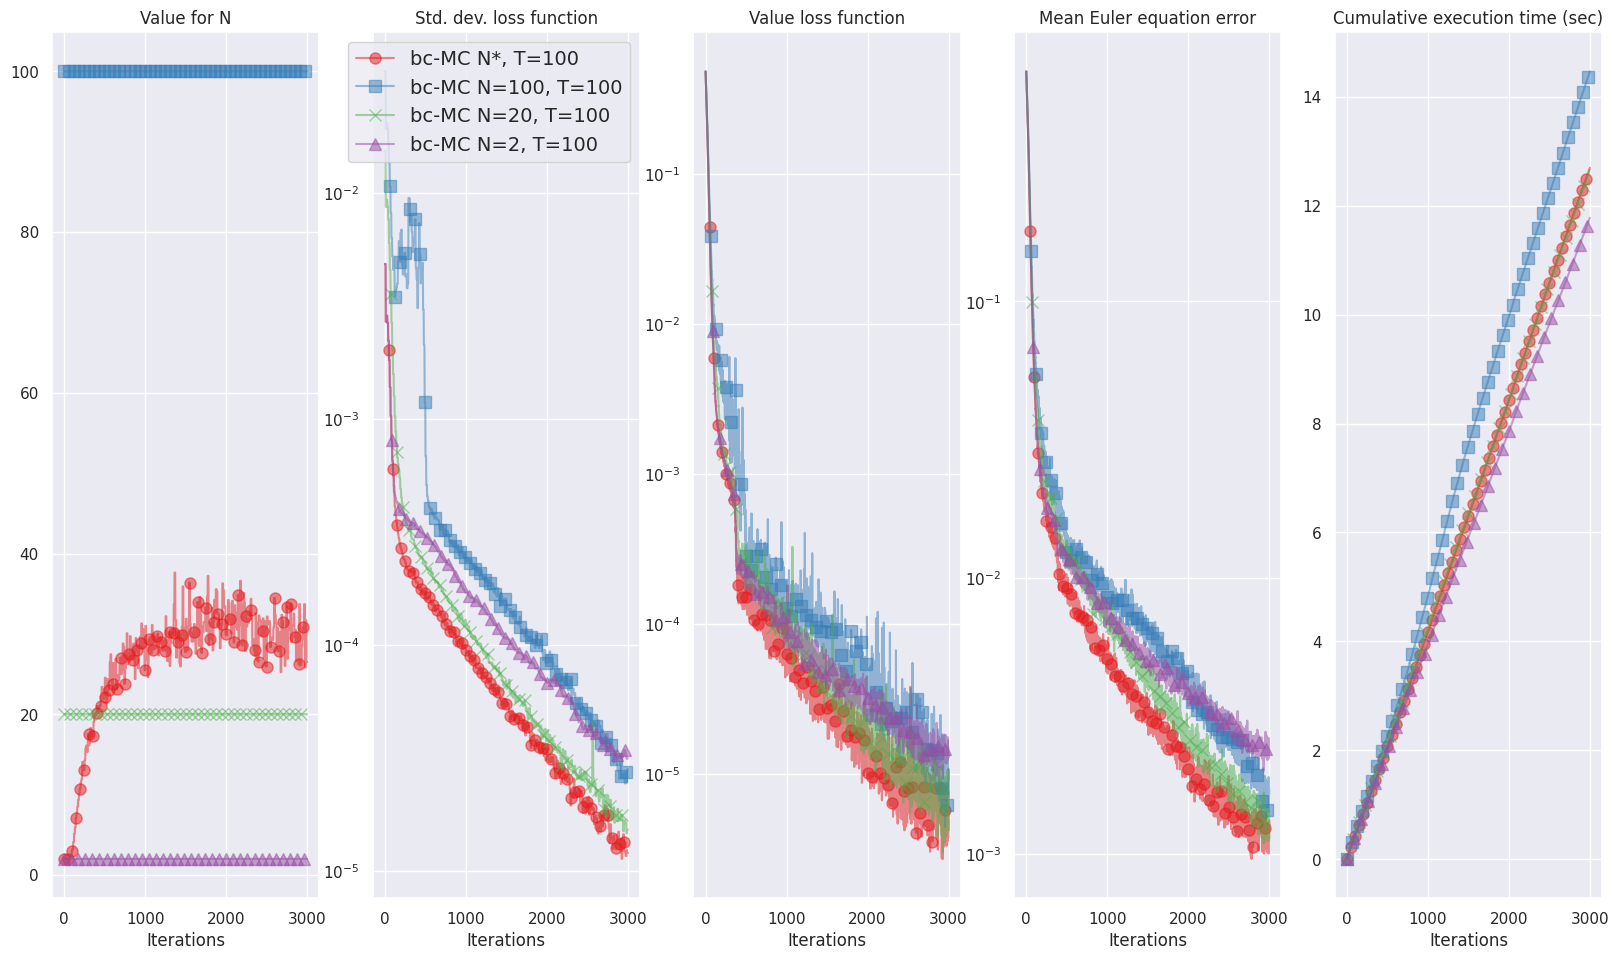

In [ ]:
if run_analysis == True: #start the analysis (can be very long)
    print("Starting analysis 2. Changing N.")

    # Plotting options
    #Plotting option
    tol_float = 10e-40 #sys.float_info.epsilon
    mult=0.5
    alpha_bands=0.05
    display_CI = False #False

    rate = 2 #20
    colors = sns.color_palette("Set1", 5)
    markers = ["o", "s", "x", "^", "D"]
    markersize= 8
    ref_freq = 50
    alpha_chosen=0.5
    list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
    prefix = "" #"" #"P50_" # ""

    #lr_loop = [0.1, 0.01, 0.001] #learning rate
    lr_loop = [0.1, 0.05, 0.01, 0.005] #[0.05, 0.01, 0.005] #learning rate
    optimizer_loop = ["Adam"] #["SGD", "Adam"]# ["SGD", "Adam"] #solvers

    α_loop = [0.995] #[0.36, 0.99]  #0.36 #0.4
    β_loop = [0.995] #[0.96, 0.99]

    T_loop = [100, 100, 100, 100] #[100, 100, 100, 100, 500]
    divs = [1, 50, 10, 1] #[1, 50, 10, 1, 1]
    N_star_loop = [True, False, False, False]

    M_loop = [int(T/(div)) for (div, T) in zip(divs, T_loop)]
    N_loop = [int(2*T/M) for (M,T) in zip(M_loop, T_loop)] #T=MN/2

    print(f"T: {T_loop}")
    print(f"M: {M_loop}")
    print(f"N: {N_loop}")
    print(f"N_star: {N_star_loop}")
    # Safety check
    print(np.array(M_loop)*np.array(N_loop)/2)

    # Nb repetition, holding hyperparams constant
    nb_reps = 100 #10 #50 #50 #4 #10 #50 #20 #Number of times I run independent SGD, holding constant the initial parameters of the NN.
    nb_epochs_chosen = 3000 #5000 #10000 #nb SGD itetations #5000
    nb_rep_loss = 1
    nb_draws = 10000 #nb draws when calculating variance of loss

    random.seed(seed_number) # For replicability reasons
    print(random.random())
    torch.manual_seed(seed_number)


    model_bcMC = NeuralNetwork(params).to(device)
    #set_initial_values(model_bcMC , initial_guess[0], initial_guess[1])
    model_bcMC_untrained = copy.deepcopy(model_bcMC)
    # Test approximation
    model_bcMC.eval()
    model_bcMC_untrained.eval()

    # Define the grid
    with torch.no_grad():
        xvec = torch.linspace(params.x_low, params.x_high, nb_points).unsqueeze(1) #add a dimension
        y_MC = model_bcMC(xvec)
        y_MC_untrained = model_bcMC_untrained(xvec)

    xvec = xvec.detach().numpy()
    y_MC = y_MC.detach().numpy()
    y_MC_untrained = y_MC_untrained.detach().numpy()

    # store hyperparams used
    list_sigma_used = []
    list_alpha_used = []
    list_beta_used = []
    list_optimizer_used = []
    list_lr_used = []
    list_N_used = []
    list_M_used = []
    list_T_used = []
    list_N_star_used = []

    list_dfs_hyperparams = [] #to store results in a dataframe

    # Loop over sigma
    for (α_chosen, β_chosen) in zip(α_loop, β_loop):
        for optimizer_chosen in optimizer_loop: # Loop over solvers
            for lr_chosen in lr_loop:  # Loop over learning rate
                for (N_chosen, M_chosen, use_N_star) in zip(N_loop, M_loop, N_star_loop):  #Loop over (M, N) for some choices of T

                    # create a reference params object
                    params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen,
                                      nb_epochs_chosen, order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                                      α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)

                    print("nb epochs: {}".format(params.nb_epochs))
                    print("W.shape: {}".format(params.W.shape))
                    print("W_expanded.shape: {}".format(params.W_expanded.shape))
                    print("M: {}".format(params.M))
                    print("N: {}".format(params.N))
                    print("MN: {}".format(params.MN))
                    print("T: {}".format(params.T))
                    print("use_Sobol: {}".format(params.use_Sobol))
                    print("Number nodes Gaussian Q: {}".format(params.nodes.shape))
                    print("N Gaussian: {}".format(params.N_gaussian))
                    print("lr: {}".format(params.lr))
                    print("σ_e: {}".format(params.σ_e))
                    print("optimizer: {}".format(params.optimizer))
                    print("Initial guess: {}".format(initial_guess))

                    # append list
                    list_sigma_used.append(params.σ_e)
                    list_alpha_used.append(α_chosen)
                    list_beta_used.append(β_chosen)
                    list_optimizer_used.append(params.optimizer)
                    list_lr_used.append(params.lr)
                    list_N_used.append(params.N)
                    list_M_used.append(params.M)
                    list_T_used.append(params.T)
                    list_N_star_used.append(use_N_star)

                    # Create grids
                    # OLD
                    grid_N = np.array([N for N in range(2, params.T+2, 2)])
                    # NEW
                    #grid_N = np.array([N for N in range(2, 2*params.T+2, 2)])
                    grid_M = 2*params.T/grid_N

                    is_int = grid_M % 1 == 0
                    grid_N = grid_N[is_int]
                    grid_M = grid_M[is_int]

                    print(grid_N)
                    print(grid_M)
                    print(grid_N*grid_M)

                    # Pre-calculate params associated with grid choices
                    list_params = []
                    for (ind, (N_chosen, M_chosen)) in enumerate(zip(grid_N.astype('int'), grid_M.astype('int'))):
                        params_local = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen, nb_epochs_chosen,
                                                order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                                                α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)
                        list_params.append(params_local)

                    list_list_losses = []
                    list_list_perc_abs_error_MC  = [] #percentage error policy function
                    list_list_perc_abs_error_MC_mean = []
                    list_list_perc_abs_error_MC_i = [] #gradient descent step
                    list_list_perc_abs_error_MC_loss = [] #loss
                    list_list_optimal_N = [] #optimal N
                    list_list_var_loss = [] #store variance of loss
                    list_list_time = [] #store time
                    list_list_Euler_mean = [] #Euler error

                    for rep in tqdm(range(0, nb_reps)): # Loop over different iterations of solver
                        random.seed(int(rep)) #same series of shocks for same rep
                        torch.manual_seed(int(rep)) #same series of shocks for same rep
                        # Create a new NN:
                        model_MC = NeuralNetwork(params).to(device)
                        #model_MC = copy.deepcopy(model_bcMC) #create a copy of NN
                        model_MC.train()

                        optimizer = create_optimizer(model_MC, params.optimizer, params.lr, params.momentum)

                        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
                        loss_epochs_MC = torch.zeros(params.nb_epochs)
                        list_perc_abs_error_MC = [] #store abs value percentage error
                        list_perc_abs_error_MC_mean = []
                        list_perc_abs_error_MC_i = [] #store index i
                        list_perc_abs_error_MC_loss = [] #store loss
                        list_MC_gradient = [] #store the norm of the gradient
                        list_time = [] #
                        list_Euler_mean = [] #Euler error
                        calculate_variance_grad = False
                        calculate_variance_loss = True #calculate for info. no update
                        list_var_loss = [] #store variance of the loss
                        list_optimal_N = [] #store the optimal N. Calculated every freq_var iterations
                        list_optimal_N_current = [] #store the current optimal N used.
                        optimal_N = params.N
                        index_best_N = np.where(grid_N == optimal_N)[0][0]
                        freq_loss = 1 #calculate loss every freq_loss iterations.
                        freq_var = 10 #freq_loss #10 #calculate variance every freq_var iterations.
                        ratio_freq_loss_freq_var = int(freq_var/freq_loss)
                        use_exact_accuracy_metrics = False # If False, use square loss to get the EEE

                        start = timer()
                        for i in range(0, params.nb_epochs):
                            optimizer.zero_grad()
                            # params associated with the current best N:
                            params_local = list_params[index_best_N]
                            loss = (1/nb_rep_loss)*Ξ_torch_MC(model_MC, params_local)
                            for j in range(1, nb_rep_loss):
                                loss += (1/nb_rep_loss)*Ξ_torch_MC(model_MC, params_local)
                            loss_epochs_MC[[i]] = float(loss.item())

                            # Backpropagation
                            loss.backward()
                            clip_grad_norm_(model_MC.parameters(), max_norm=1.0, error_if_nonfinite=False)
                            optimizer.step()

                            if i % freq_loss == 0: #Monitor the predictive power
                                list_perc_abs_error_MC_loss.append(float(loss.item()))# store loss
                                list_optimal_N_current.append(optimal_N) #N used
                                list_perc_abs_error_MC_i.append(i) #store nb gradient descent steps
                                # Alternative measurements of accuracy. Slower when True
                                if use_exact_accuracy_metrics == True:
                                    with torch.no_grad():
                                        y_MC = model_MC(params.xvec_test_torch)
                                    y_MC = y_MC.detach().numpy()
                                    perc_abs_error_MC = np.abs((y_MC -  params.f_true )/ params.f_true )
                                    list_perc_abs_error_MC.append(np.median(perc_abs_error_MC)) #median
                                    list_perc_abs_error_MC_mean.append(np.mean(perc_abs_error_MC)) #mean
                                    list_Euler_mean.append(np.mean(evaluate_accuracy_pytorch_frozen_Gaussian(model_MC, params)))
                                else:
                                    EEE = np.abs(float(loss.item()))**0.5
                                    list_perc_abs_error_MC.append(-1)
                                    list_perc_abs_error_MC_mean.append(-1)
                                    list_Euler_mean.append(EEE)

                                # Calculate time
                                now = timer()
                                elapsed_time = now - start
                                list_time.append(elapsed_time)
                                if calculate_variance_grad == True:
                                    total_norm = 0
                                    # Store the norm of the gradient
                                    for p in model_MC.parameters():
                                        param_norm = p.grad.detach().data.norm(2)
                                        total_norm += param_norm.item() ** 2
                                    total_norm = total_norm ** 0.5
                                    list_MC_gradient.append(total_norm)
                            if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
                                # Variance of the loss associated with each choice of M and N
                                # Gaussian formula
                                var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_MC, nb_draws, grid_M, grid_N)
                                # When N is kept cst, still append list
                                if use_N_star == False:
                                    index_best_N_dummy = np.argmin(var_loss_formula)
                                    optimal_N_dummy = grid_N[index_best_N_dummy]
                                    list_optimal_N.append(optimal_N_dummy)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                                # When N* algo is used, update the value of N during training
                                else:
                                    index_best_N = np.argmin(var_loss_formula)
                                    optimal_N = grid_N[index_best_N]
                                    list_optimal_N.append(optimal_N)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                            if i % 1000 == 0:
                                loss, current = float(loss.item()), i
                                print(f"N: {optimal_N} loss: {loss:>7f}, mean euler error {list_perc_abs_error_MC_mean[-1]:>7f}, [{current:>5d}/{params_local.nb_epochs:>5d}]")
                            if (i % params_local.freq_scheduler == 0) & (i != 0) & (params_local.use_scheduler == True):
                                scheduler.step()
                                print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

                        if params_local.optimizer == "SWA":
                            optimizer.swap_swa_sgd()

                        #Store values
                        list_list_perc_abs_error_MC.append(list_perc_abs_error_MC) #percentage error policy function
                        list_list_perc_abs_error_MC_mean.append(list_perc_abs_error_MC_mean) #percentage error policy function (mean)
                        list_list_perc_abs_error_MC_i.append(list_perc_abs_error_MC_i) #index
                        list_list_perc_abs_error_MC_loss.append(list_perc_abs_error_MC_loss) #loss
                        list_list_optimal_N.append(list_optimal_N_current) #optimal N
                        list_list_var_loss.append(list_var_loss)
                        list_list_time.append(list_time)
                        list_list_Euler_mean.append(list_Euler_mean)
                    # Create dataframe and summary stats
                    lst = list(range(0,nb_reps))
                    list_index_rep = list(np.repeat(lst, len(list_perc_abs_error_MC_i))) #gradient descent steps

                    df_bcMC_loop = pd.DataFrame({
                                        'repetition': list_index_rep,
                                        'iter': numpy_flat(list_list_perc_abs_error_MC_i),
                                        'loss': np.abs(numpy_flat(list_list_perc_abs_error_MC_loss)),
                                        'med_percentage_error': numpy_flat(list_list_perc_abs_error_MC),
                                        'mean_percentage_error': numpy_flat(list_list_perc_abs_error_MC_mean),
                                        'mean_Euler_error': numpy_flat(list_list_Euler_mean),
                                        'optimal_N': numpy_flat(list_list_optimal_N),
                                        'var_loss': np.repeat(numpy_flat(list_list_var_loss), ratio_freq_loss_freq_var),
                                        'time': numpy_flat(list_list_time),
                       })

                    print(df_bcMC_loop.head())

                    # Statistics on results
                    df_bcMC_loop_average = df_bcMC_loop.groupby('iter').mean().reset_index() #mean value by iteration
                    df_bcMC_loop_average.head()

                    list_cols = ["loss", "med_percentage_error", "mean_percentage_error", "mean_Euler_error", "optimal_N", "var_loss", "time"]

                    for col in list_cols:
                        df_bcMC_loop_average["min_" + col] = df_bcMC_loop.groupby('iter')[col].min().reset_index()[col]
                        df_bcMC_loop_average["max_" + col] = df_bcMC_loop.groupby('iter')[col].max().reset_index()[col]
                        df_bcMC_loop_average["std_" + col] = df_bcMC_loop.groupby('iter')[col].std().reset_index()[col]
                        for qq in [5, 10, 25, 50, 75, 90, 95]:
                            df_bcMC_loop_average["P" + str(qq) + "_" + col] = df_bcMC_loop.groupby('iter')[col].quantile(qq/100).reset_index()[col]


                    # append list
                    list_dfs_hyperparams.append(df_bcMC_loop_average)
                #------------------------------------
                # End of different choices for (M,N):
                # Plot
                #------------------------------------
                df_hyperparams = pd.DataFrame({"sigma_e":list_sigma_used,
                        "alpha": list_alpha_used,
                        "beta": list_beta_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

                # select combination
                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
                df_sel = df_sel[df_sel["alpha"] == α_chosen]
                df_sel = df_sel[df_sel["beta"] == β_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)

                list_dfs_plot = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                for (i, min_index) in enumerate([0]):
                    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:], df[f"{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax3.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")


                    #var = "mean_percentage_error"
                    var = "mean_Euler_error"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax4.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax4.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)

                    ax4.set_yscale('log')
                    ax4.set_title('Mean Euler equation error')
                    ax4.set_xlabel("Iterations")

                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:] - mult*df[f"std_{var}"][min_index:], df[f"{prefix}{var}"][min_index:] + mult*df[f"std_{var}"][min_index:], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

                    figname = output_folder + f'time_varying_N_simga_e_{σ_e_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.png'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)

                    figname = output_folder + f'time_varying_N_simga_e_{σ_e_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.pdf'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)
                    plt.show()


In [ ]:
extension_csv_file = "opt_N"
if save_to_csv == True:
    print("Writting CSV")

    df_hyperparams = pd.DataFrame({"sigma_e":list_sigma_used,
                        "alpha": list_alpha_used,
                        "beta": list_beta_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

    df_hyperparams.to_csv(output_folder + f"hyperparams_{extension_csv_file}.csv", index=False)
    print(df_hyperparams)

    index_df = 0
    for index, row in df_hyperparams.iterrows():
        σ_e_chosen = row['sigma_e']
        α_chosen = row['alpha']
        β_chosen = row['beta']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
        list_dfs_hyperparams[index_df].to_csv(filen, index=False)
        index_df+=1


Writting CSV
    sigma_e  alpha   beta optim     lr    N    M    T  N_star
0      0.05  0.995  0.995  Adam  0.100    2  100  100    True
1      0.05  0.995  0.995  Adam  0.100  100    2  100   False
2      0.05  0.995  0.995  Adam  0.100   20   10  100   False
3      0.05  0.995  0.995  Adam  0.100    2  100  100   False
4      0.05  0.995  0.995  Adam  0.050    2  100  100    True
5      0.05  0.995  0.995  Adam  0.050  100    2  100   False
6      0.05  0.995  0.995  Adam  0.050   20   10  100   False
7      0.05  0.995  0.995  Adam  0.050    2  100  100   False
8      0.05  0.995  0.995  Adam  0.010    2  100  100    True
9      0.05  0.995  0.995  Adam  0.010  100    2  100   False
10     0.05  0.995  0.995  Adam  0.010   20   10  100   False
11     0.05  0.995  0.995  Adam  0.010    2  100  100   False
12     0.05  0.995  0.995  Adam  0.005    2  100  100    True
13     0.05  0.995  0.995  Adam  0.005  100    2  100   False
14     0.05  0.995  0.995  Adam  0.005   20   10  100   F

In [ ]:
# Load files
if read_from_csv == True:
    print("Reading CSV")

    df_hyperparams = pd.read_csv(output_folder + f'hyperparams_{extension_csv_file}.csv')
    print(df_hyperparams)

    list_dfs_hyperparams = []
    for index, row in df_hyperparams.iterrows():
        σ_e_chosen = row['sigma_e']
        α_chosen = row['alpha']
        β_chosen = row['beta']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
        list_dfs_hyperparams.append(pd.read_csv(filen))


Reading CSV
    sigma_e  alpha   beta optim     lr    N    M    T  N_star
0      0.05  0.995  0.995  Adam  0.100    2  100  100    True
1      0.05  0.995  0.995  Adam  0.100  100    2  100   False
2      0.05  0.995  0.995  Adam  0.100   20   10  100   False
3      0.05  0.995  0.995  Adam  0.100    2  100  100   False
4      0.05  0.995  0.995  Adam  0.050    2  100  100    True
5      0.05  0.995  0.995  Adam  0.050  100    2  100   False
6      0.05  0.995  0.995  Adam  0.050   20   10  100   False
7      0.05  0.995  0.995  Adam  0.050    2  100  100   False
8      0.05  0.995  0.995  Adam  0.010    2  100  100    True
9      0.05  0.995  0.995  Adam  0.010  100    2  100   False
10     0.05  0.995  0.995  Adam  0.010   20   10  100   False
11     0.05  0.995  0.995  Adam  0.010    2  100  100   False
12     0.05  0.995  0.995  Adam  0.005    2  100  100    True
13     0.05  0.995  0.995  Adam  0.005  100    2  100   False
14     0.05  0.995  0.995  Adam  0.005   20   10  100   Fa

   sigma_e  alpha   beta optim   lr    N    M    T  N_star
0     0.05  0.995  0.995  Adam  0.1    2  100  100    True
1     0.05  0.995  0.995  Adam  0.1  100    2  100   False
2     0.05  0.995  0.995  Adam  0.1   20   10  100   False
3     0.05  0.995  0.995  Adam  0.1    2  100  100   False


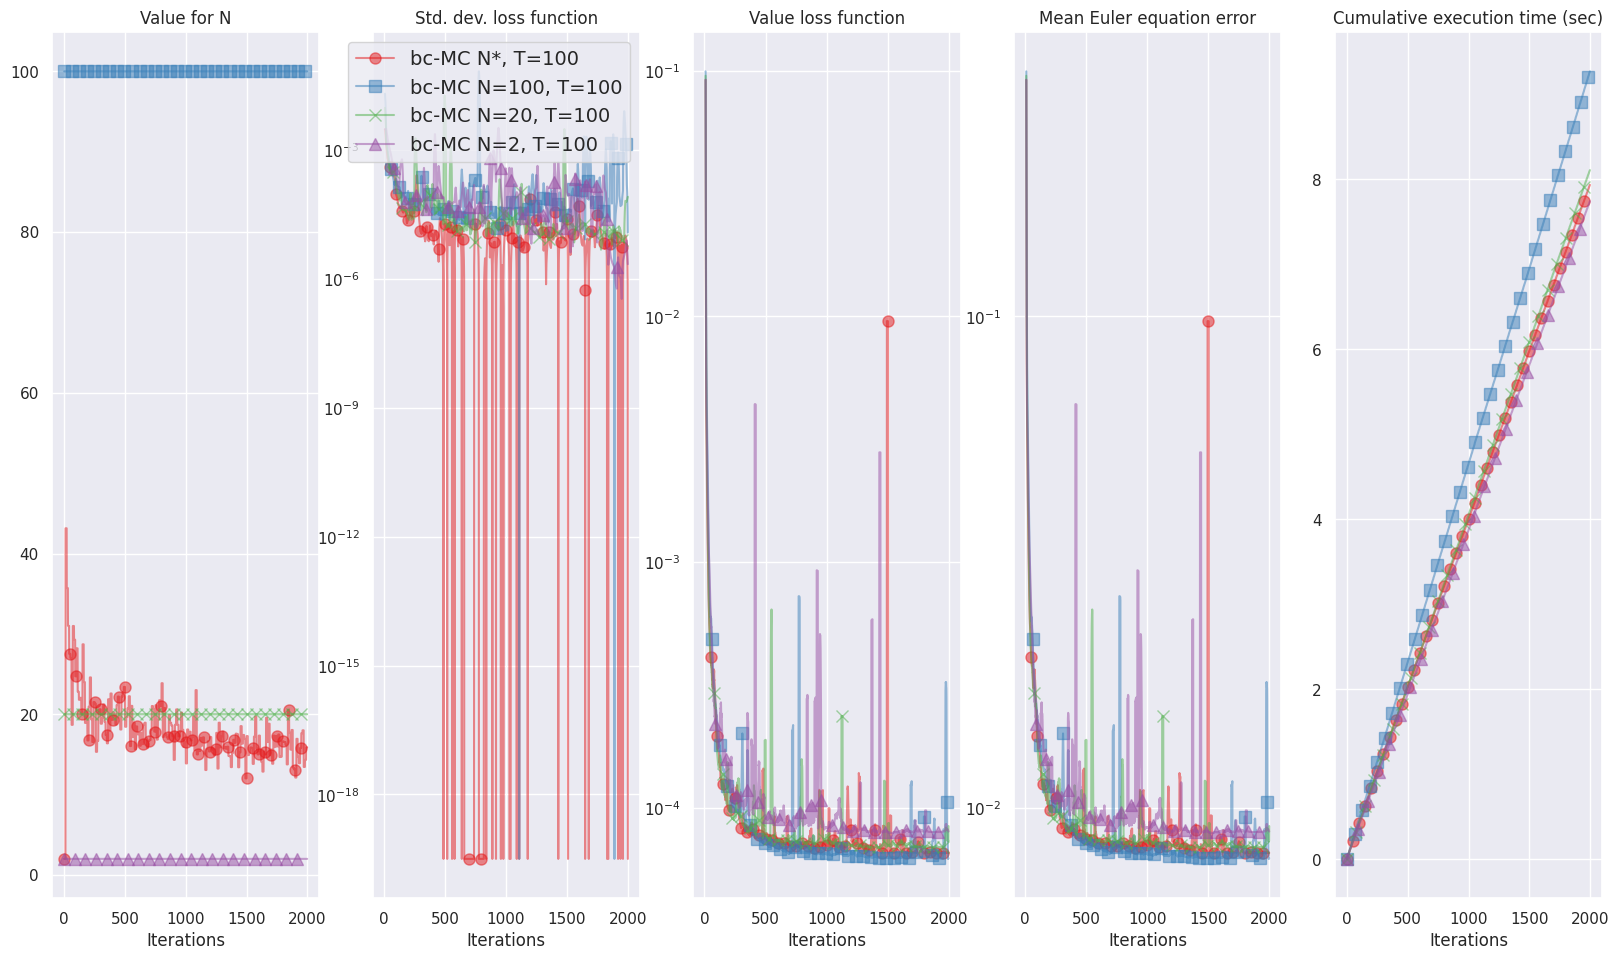

   sigma_e  alpha   beta optim    lr    N    M    T  N_star
4     0.05  0.995  0.995  Adam  0.05    2  100  100    True
5     0.05  0.995  0.995  Adam  0.05  100    2  100   False
6     0.05  0.995  0.995  Adam  0.05   20   10  100   False
7     0.05  0.995  0.995  Adam  0.05    2  100  100   False


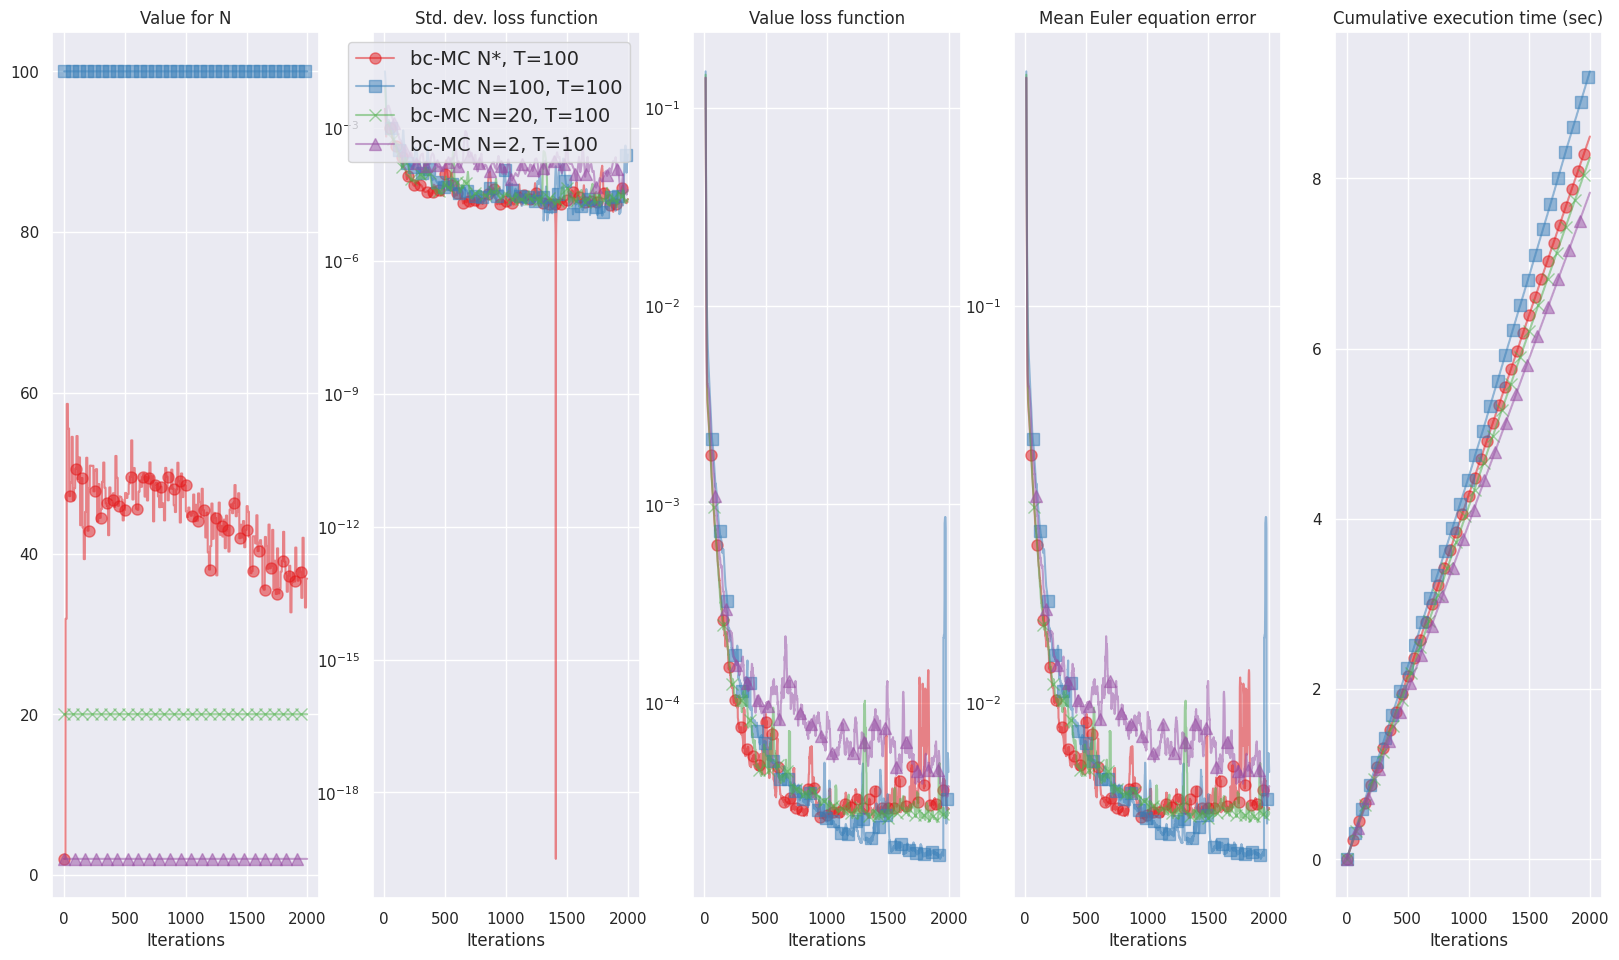

    sigma_e  alpha   beta optim    lr    N    M    T  N_star
8      0.05  0.995  0.995  Adam  0.01    2  100  100    True
9      0.05  0.995  0.995  Adam  0.01  100    2  100   False
10     0.05  0.995  0.995  Adam  0.01   20   10  100   False
11     0.05  0.995  0.995  Adam  0.01    2  100  100   False


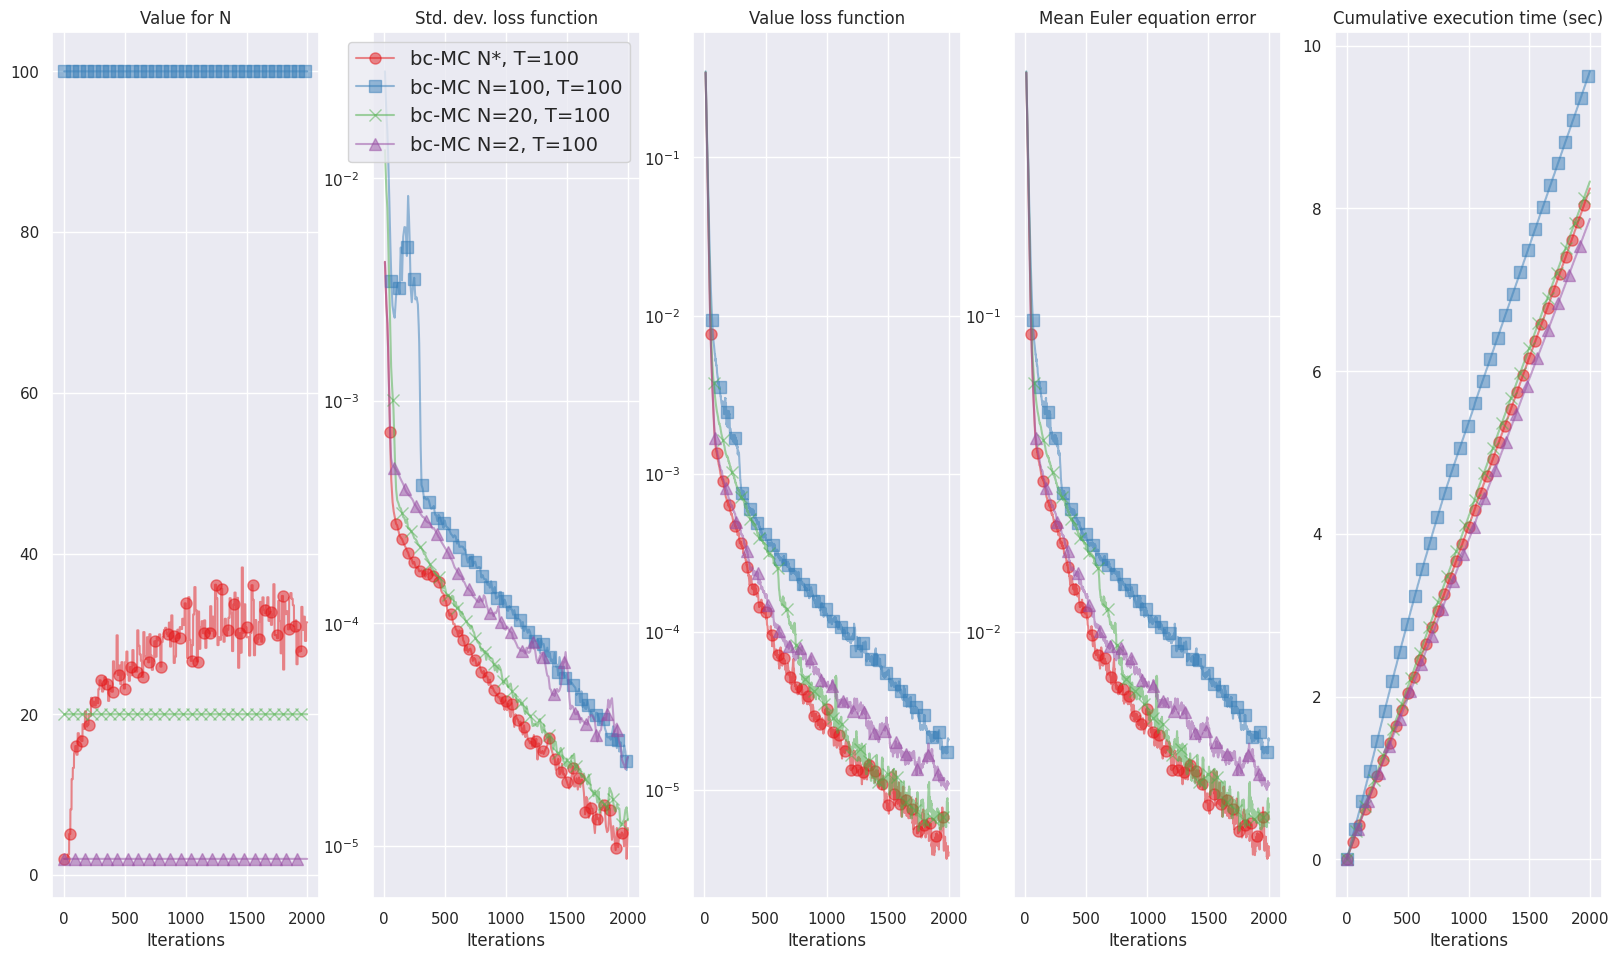

    sigma_e  alpha   beta optim     lr    N    M    T  N_star
12     0.05  0.995  0.995  Adam  0.005    2  100  100    True
13     0.05  0.995  0.995  Adam  0.005  100    2  100   False
14     0.05  0.995  0.995  Adam  0.005   20   10  100   False
15     0.05  0.995  0.995  Adam  0.005    2  100  100   False


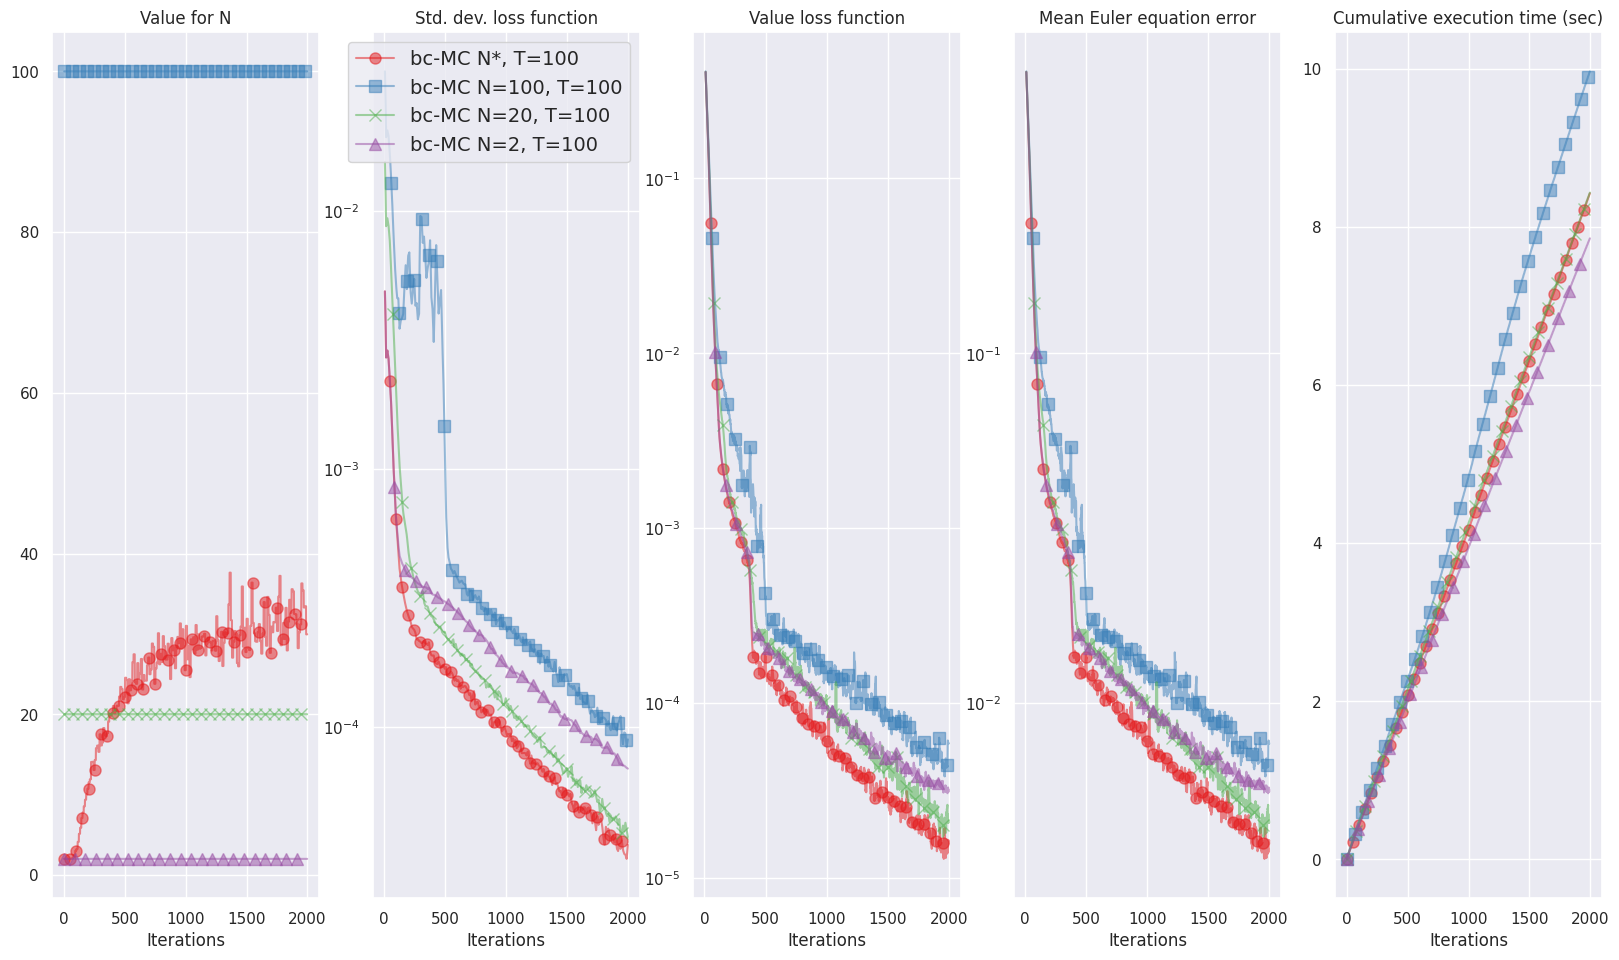

In [ ]:
mult=0.5
alpha_bands=0.10
display_CI = False #False

rate = 10
colors = sns.color_palette("Set1", 5)
markers = ["o", "s", "x", "^", "D"]
markersize= 8
ref_freq = 50
alpha_chosen=0.5
list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
prefix = "" #"" #"" #"P50_" # ""

list_combinations_used = []
for index, row in df_hyperparams.iterrows():
    σ_e_chosen = row['sigma_e']
    α_chosen = row['alpha']
    β_chosen = row['beta']
    optimizer_chosen = row["optim"]
    lr_chosen = row["lr"]
    N_chosen = row["N"]
    M_chosen = row["M"]
    use_N_star = row["N_star"]

    combination = f'{optimizer_chosen}-{σ_e_chosen}-{α_chosen}-{β_chosen}-{lr_chosen}'
    if combination not in list_combinations_used:
        list_combinations_used.append(combination)
    else:
        continue #If combination already used, pass
    df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
    df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
    df_sel = df_sel[df_sel["alpha"] == α_chosen]
    df_sel = df_sel[df_sel["beta"] == β_chosen]
    df_sel = df_sel[df_sel["lr"] == lr_chosen]
    print(df_sel)


    list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
    list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
    list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
    list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
    list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

    list_labels = []
    for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
        if N_star == True:
            list_labels += [f"bc-MC N*, T={T}"]
        else:
            list_labels += [f"bc-MC N={N}, T={T}"]
    #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

    #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
    for (i, (min_index, max_index)) in enumerate(zip([0], [2000])):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

        var = "optimal_N"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
        #ax1.set_yscale('log')
        ax1.set_title('Value for N')
        ax1.set_xlabel("Iterations")

        var = "var_loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax2.set_yscale('log')
        ax2.set_title('Std. dev. loss function')
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Iterations")

        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax3.set_yscale('log')
        ax3.set_title('Value loss function')
        ax3.set_xlabel("Iterations")


        """
        #var = "mean_percentage_error"
        var = "mean_Euler_error"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        """
        # square root series for loss
        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
            MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

        ax4.set_yscale('log')
        ax4.set_title('Mean Euler equation error')
        ax4.set_xlabel("Iterations")

        var = "time"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

        ax5.set_xlabel("Iterations")
        ax5.set_title("Cumulative execution time (sec)")

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
        plt.savefig(figname, bbox_inches="tight", dpi=300)

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
        plt.savefig(figname, bbox_inches="tight", dpi=300)
        plt.show()


In [ ]:
print(json.loads(getSystemInfo()))

{'platform': 'Linux', 'platform-release': '6.1.58+', 'platform-version': '#1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023', 'architecture': 'x86_64', 'hostname': 'ca93e03e1556', 'ip-address': '172.28.0.12', 'mac-address': '02:42:ac:1c:00:0c', 'processor': 'x86_64', 'ram': '13 GB'}


In [ ]:
# Copy to drive
if on_Colab==True:

    path = f"/gdrive/My Drive/{output_extension}"
    # Create folder if does not exist:
    if not os.path.exists(path):
      # If it doesn't exist, create it
      os.mkdir(path)

    ## A. Save to Grdive
    # Compress to zip
    !zip -r /content/file.zip /content/output

    shutil.copy("/content/file.zip", f"{path}/file.zip")

    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')


  adding: content/output/ (stored 0%)
  adding: content/output/BM_3/ (stored 0%)
  adding: content/output/BM_3/BM_3-opt_N_loop_4_0.pdf (deflated 6%)
  adding: content/output/BM_3/df_bcMC_changing_M_2_M_1_Nstar_False_lr_0.1_optim_Adam_σ_0.05_α_0.995.csv (deflated 70%)
  adding: content/output/BM_3/df_bcMC_opt_N_100_M_2_Nstar_False_lr_0.005_optim_Adam_σ_0.05_α_0.995.csv (deflated 69%)
  adding: content/output/BM_3/changing_M_simga_e_0.05_lr_0.01_optim_Adam_loop_0.pdf (deflated 4%)
  adding: content/output/BM_3/df_bcMC_opt_N_2_M_100_Nstar_True_lr_0.01_optim_Adam_σ_0.05_α_0.995.csv (deflated 69%)
  adding: content/output/BM_3/df_bcMC_opt_N_2_M_100_Nstar_False_lr_0.1_optim_Adam_σ_0.05_α_0.995.csv (deflated 71%)
  adding: content/output/BM_3/df_bcMC_changing_M_2_M_1_Nstar_False_lr_0.005_optim_Adam_σ_0.05_α_0.995.csv (deflated 68%)
  adding: content/output/BM_3/df_bcMC_changing_M_2_M_10_Nstar_False_lr_0.005_optim_Adam_σ_0.05_α_0.995.csv (deflated 69%)
  adding: content/output/BM_3/df_bcMC_opt

In [ ]:
if on_Colab==True:

    # Wait 2 minutes
    time.sleep(120)

    ## Close session
    from google.colab import runtime
    runtime.unassign()
